<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Unilever/Unilever_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UNANLEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-03 03:09:43,936 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-03 03:09:43,937 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for UNANLEUR
2019-09-03 03:09:53,983 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-03 03:13:07,362 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-03 03:20:01,498 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-03 03:23:23,745 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-03 03:26:45,357 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-03 03:30:20,193 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-03 03:33:16,655 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-03 03:36:48,780 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-09-03 03:50:39,703 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_UNANLEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-UNANLEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-UNANLEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.46972  0.47007  0.46432  0.46537  8.461237
2018-01-02 09:00:00  0.46543  0.46707  0.46472  0.46538  8.926034
2018-01-02 10:00:00  0.46538  0.46703  0.46522  0.46588  5.078299
2018-01-02 11:00:00  0.46587  0.46843  0.46587  0.46768  3.783289
2018-01-02 12:00:00  0.46767  0.46813  0.46642  0.46683  3.621654
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.46738  0.46933  0.46642  0.46882  5.645418
2018-12-31 09:00:00  0.46883  0.47022  0.46857  0.47018  3.749582
2018-12-31 10:00:00  0.47023  0.47238  0.47023  0.47198  3.953187
2018-12-31 11:00:00  0.47197  0.47253  0.47117  0.47233  3.578822
2018-12-31 12:00:00  0.47233  0.47418  0.47157  0.47398  3.073008

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.471129     0.472270     0.470103     0.471219     5.611320
std       0.018761     0.018682     0.018766     0.018727     2.427142
min       0.421830     0.423530     0.421030     0.422480     0.128877
25%       0.461372     0.462323     0.460340     0.461470     3.888166
50%       0.474845     0.475855     0.473925     0.474930     5.119281
75%       0.483908     0.484830     0.482770     0.483957     6.833594
max       0.500770     0.501380     0.500370     0.500680    23.282787

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.46938  0.46998  0.46882  0.46993  4.063199    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.470142  0.467005 -0.472966  0.470136  0.470273  0.470146    0.470680    0.471050  0.472389  0.470445  0.469727  0.470417  0.470217  0.470445  0.470013  0.470140                0.472035                 0.470445                0.468855                0.472830                 0.470445                0.468060                0.473625                 0.470445                0.467265                0.474420                 0.470445                0.466470  0.470273  0.469975  0.470318                0.471863                 0.470273                0.468684                0.472658                 0.470273                0.467889                0.473453                 0.470273                0.467094                0.474248                 0.470273   
2018-01-09 14:00:00  0.46993  0.47143  0.46942  0.46972  9.341429    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.470121  0.467082 -0.472717  0.469948  0.470150  0.470132    0.470680    0.471050  0.472104  0.470287  0.469579  0.470272  0.470056  0.470287  0.469825  0.470187                0.471884                 0.470287                0.468691                0.472682                 0.470287                0.467893                0.473480                 0.470287                0.467095                0.474278                 0.470287                0.466297  0.470150  0.469777  0.470335                0.471747                 0.470150                0.468554                0.472545                 0.470150                0.467756                0.473343                 0.470150                0.466958                0.474141                 0.470150   
2018-01-09 15:00:00  0.46973  0.47007  0.46902  0.47003 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.471224     0.472368     0.470195     0.471315     5.640287    16.002244     2.019300   185.559695      30.423698    11.375673      0.034111        0.023788        0.002244          0.004039     6.601436     2.534560    26.960503     2.019300      2.004488    26.960503     0.471341     0.471319    -0.002955     0.471313     0.471314     0.471172     0.471280     0.471182     0.471063     0.471313     0.471314     0.471313     0.471313     0.471313     0.471315     0.471316                0.474421                 0.471313                0.468206                0.475974                 0.471313                0.466652                0.477528                 0.471313                0.465099                0.479082                 0.471313                0.463545     0.471314     0.471315     0.471316                0.474421                 0.471314                0.468207                0.475975                 0.471314                0.466653                0.477529   
std       0.018953     0.018873     0.018959     0.018920     2.435490     8.579614     1.412334   101.858436       0.853958     2.619789      0.181556        0.152423        0.047330          0.063443     3.351177     1.102786    14.552207     1.412334      1.404009    14.552207     0.018858     0.018619     0.471659     0.018956     0.018791     0.018591     0.018777     0.018769     0.018891     0.018834     0.018941     0.018852     0.018847     0.018834     0.018899     0.018677                0.018624                 0.018834                0.019214                0.018586                 0.018834                0.019466                0.018593                 0.018834                0.019757                0.018644                 0.018834                0.020085     0.018791     0.018886     0.018700                0.018581                 0.018791                0.019173                0.018542                 0.018791                0.019426                0.018548   
min       0.421830     0.423530     0.4210

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.602356  0.596660  0.602344  0.606777  0.169920    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.604738  0.557853  0.028394  0.607937  0.609921  0.604907    0.616160    0.621724  0.639195  0.611510  0.600810  0.611021  0.609306  0.611510  0.606490  0.605544                0.614580                 0.611510                0.606493                0.599671                 0.611510                0.613967                0.577423                 0.611510                0.621273                0.557045                 0.611510                0.628092  0.609921  0.606014  0.608581                0.612235                 0.609921                0.609337                0.593263                 0.609921                0.617353                0.572887                 0.609921                0.624733                0.552736                 0.609921   
2018-01-09 14:00:00  0.609324  0.615286  0.609906  0.604092  0.397883    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.604461  0.558907  0.028642  0.605530  0.608315  0.604726    0.616160    0.621724  0.635641  0.609458  0.598916  0.609143  0.607212  0.609458  0.604062  0.606174                0.612621                 0.609458                0.604401                0.597811                 0.609458                0.611908                0.575683                 0.609458                0.619247                0.555414                 0.609458                0.626097  0.608315  0.603475  0.608798                0.610722                 0.608315                0.607687                0.591845                 0.608315                0.615723                0.571564                 0.608315                0.623121                0.551506                 0.608315   
2018-01-09 15:00:00  0.606790  0.597816  

140154

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 59 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_yr5hs0
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.778931  0.571548              0.335144  0.440744  0.194255
1  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.773700  0.613115              0.356671  0.449919  0.202427
2  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.769516  0.622951              0.327378  0.451652  0.203990
3  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.769435  0.579519              0.336351  0.444871  0.197910
4  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.767262  0.575941              0.339530  0.441315  0.194759
5  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.765411  0.751317              0.348503  0.479616  0.230031
6  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.762152  1.699815              0.285530  0.537528  0.288937
7  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.751167  0.599152              0.320014  0.453009  0.205217
8  DeepLearning_grid_1_AutoML_20190903_035954_mod...  0.741027  0.595040              0.369628  0.452406  0.204671
9              DeepLearning_1_AutoML_20190903_035954  0.670771  0.791300              0.379205  0.503234  0.253244

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.007930
1           CDLCLOSINGMARUBOZU             0.650846           0.650846    0.005161
2                  CDLLONGLINE             0.505883           0.505883    0.004012
3                 STOCHF_fastk             0.501852           0.501852    0.003980
4                          DIV             0.440302           0.440302    0.003492
...                        ...                  ...                ...         ...
1033   BBANDS_upperband_14_7_2             0.091632           0.091632    0.000727
1034                   MA_14_3             0.091510           0.091510    0.000726
1035                 CDLONNECK             0.090861           0.090861    0.000721
1036  BBANDS_middleband_14_0_5             0.090809           0.090809    0.000720
1037  BBANDS_middleband_14_0_3             0.090349           0.090349    0.000717

[1038 rows x 4 columns]

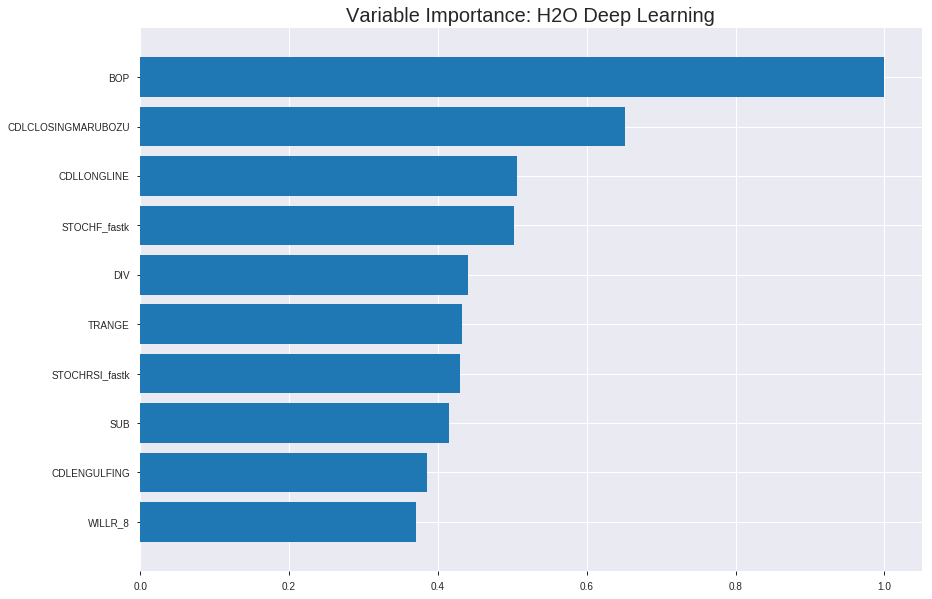

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_035954_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1966778318199141
RMSE: 0.4434837447076433
LogLoss: 0.5737679281681509
Mean Per-Class Error: 0.2776056558531983
AUC: 0.7861850182513329
pr_auc: 0.7844483276055099
Gini: 0.5723700365026658
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5292254272394028: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      473  300  0.3881   (300.0/773.0)
1      156  629  0.1987   (156.0/785.0)
Total  629  929  0.2927   (456.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529225     0.733956  194
max f2                       0.211261     0.851533  330
max f0point5                 0.529997     0.731474  193
max accuracy                 0.529997     0.72208   193
max precision                0.994041     1         0
max recall                   0.03806      1         384
max specificity              0.994041     1         0
max absolute_mcc             0.529997     0.446145  193
max min_per_class_accuracy   0.529997     0.681529  193
max mean_per_class_accuracy  0.529997     0.722394  193

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.954505           1.98471   1.98471            1                0.975719   1                           0.975719            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.937902           1.73662   1.86067            0.875            0.944792   0.9375                      0.960256            0.0178344       0.0382166                  73.6624   86.0669
    3        0.0301669                   0.9149             1.72008   1.8158             0.866667         0.925603   0.914894                    0.949196            0.0165605       0.0547771                  72.0085   81.5802
    4        0.0404365                   0.888766           1.86067   1.8272             0.9375           0.901972   0.920635                    0.937203            0.0191083       0.0738854                  86.0669   82.7196
    5        0.0500642                   0.867733           1.58777   1.78115            0.8              0.875416   0.897436                    0.925321            0.0152866       0.089172                   58.7771   78.1153
    6        0.100128                    0.759525           1.73026   1.75571            0.871795         0.809957   0.884615                    0.867639            0.0866242       0.175796                   73.0263   75.5708
    7        0.150193                    0.676863           1.85749   1.78963            0.935897         0.716643   0.901709                    0.817307            0.0929936       0.26879                    85.7488   78.9635
    8        0.200257                    0.623186           1.62848   1.74935            0.820513         0.647195   0.88141                     0.774779            0.0815287       0.350318                   62.8483   74.9347
    9        0.300385                    0.567432           1.33586   1.61152            0.673077         0.58952    0.811966                    0.713026            0.133758        0.484076                   33.5865   61.1519
    10       0.399872                    0.540994           1.12681   1.49092            0.567742         0.553318   0.751204                    0.673291            0.112102        0.596178                   12.6805   49.0924
    11       0.595635                    0.529224           1.04116   1.3431             0.52459          0.531032   0.676724                    0.626536            0.203822        0.8                        4.11611   34.3103
    12       0.600128                    0.528305           1.41765   1.34366            0.714286         0.528533   0.677005                    0.625802            0.00636943      0.806369                   41.7652   34.3662
    13       0.699615                    0.473558           0.524989  1.22724            0.264516         0.506715   0.618349                    0.608868            0.0522293       0.858599                   -47.5011  22.7245
    14       0.799743                    0.349777           0.750629  1.16757            0.378205         0.412866   0.588283                    0.584328            0.0751592       0.933758                   -24.9371  16.7572
    15       0.899872                    0.194778           0.496178  1.09287            0.25             0.280349   0.550642                    0.550504            0.0496815       0.983439                   -50.3822  9.28664
    16       1                           0.000509647        0.165393  1                  0.0833333        0.0843357  0.503851                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20594453676200433
RMSE: 0.45381112454632966
LogLoss: 0.6035805361935669
Mean Per-Class Error: 0.31755447941888626
AUC: 0.7429378531073446
pr_auc: 0.7323230417464335
Gini: 0.48587570621468923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4493436909228443: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  106  0.5048   (106.0/210.0)
1      32   204  0.1356   (32.0/236.0)
Total  136  310  0.3094   (138.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449344     0.747253  271
max f2                       0.124533     0.863469  367
max f0point5                 0.546731     0.703422  191
max accuracy                 0.485288     0.690583  252
max precision                0.989285     1         0
max recall                   0.0536917    1         381
max specificity              0.989285     1         0
max absolute_mcc             0.449344     0.389932  271
max min_per_class_accuracy   0.534333     0.669492  209
max mean_per_class_accuracy  0.485288     0.682446  252

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.978686           1.51186   1.51186            0.8              0.982804   0.8                         0.982804            0.0169492       0.0169492                  51.1864   51.1864
    2        0.0201794                   0.970768           1.41737   1.46987            0.75             0.97424    0.777778                    0.978998            0.0127119       0.029661                   41.7373   46.9868
    3        0.0313901                   0.961128           1.51186   1.48487            0.8              0.967596   0.785714                    0.974926            0.0169492       0.0466102                  51.1864   48.4867
    4        0.0403587                   0.954717           1.88983   1.57486            1                0.957364   0.833333                    0.971023            0.0169492       0.0635593                  88.9831   57.4859
    5        0.0515695                   0.945297           1.88983   1.64333            1                0.950624   0.869565                    0.966589            0.0211864       0.0847458                  88.9831   64.3331
    6        0.100897                    0.889644           1.46032   1.55386            0.772727         0.921413   0.822222                    0.944503            0.0720339       0.15678                    46.0324   55.3861
    7        0.150224                    0.819122           1.46032   1.52315            0.772727         0.861011   0.80597                     0.917088            0.0720339       0.228814                   46.0324   52.3147
    8        0.201794                    0.754466           1.06817   1.40687            0.565217         0.781914   0.744444                    0.882543            0.0550847       0.283898                   6.81651   40.6874
    9        0.300448                    0.649139           1.50327   1.43853            0.795455         0.698119   0.761194                    0.821986            0.148305        0.432203                   50.3274   43.8528
    10       0.401345                    0.580233           1.17589   1.3725             0.622222         0.611257   0.726257                    0.76901             0.118644        0.550847                   17.5895   37.2503
    11       0.5                         0.534755           1.15967   1.33051            0.613636         0.553621   0.704036                    0.726511            0.114407        0.665254                   15.9669   33.0508
    12       0.600897                    0.517562           0.923917  1.26224            0.488889         0.528655   0.66791                     0.693289            0.0932203       0.758475                   -7.60829  26.2238
    13       0.699552                    0.445981           1.07377   1.23566            0.568182         0.484661   0.653846                    0.663867            0.105932        0.864407                   7.37673   23.5658
    14       0.800448                    0.332392           0.629944  1.15931            0.333333         0.39342    0.613445                    0.629777            0.0635593       0.927966                   -37.0056  15.9308
    15       0.899103                    0.164518           0.558359  1.09337            0.295455         0.248114   0.578554                    0.587899            0.0550847       0.983051                   -44.1641  9.33683
    16       1                           0.00152439         0.167985  1                  0.0888889        0.0721768  0.529148                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:17:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:17:08  2 min 52.901 sec  327 obs/sec       0.293967  1             458        0.669785         2.37611             -0.794556      0.548586        0.551207           1.24045          0.496149                         0.707108           2.77978               -1.00683         0.623154          0.64556              1.88983            0.446188
    2019-09-03 04:17:30  3 min 14.500 sec  408 obs/sec       5.46534   18            8515       0.533564         0.777223            -0.138828      0.529502        0.537621           0.992357         0.496149                         0.529122           0.759598              -0.123698        0.574294          0.597276             1.51186            0.46861
    2019-09-03 04:17:51  3 min 36.086 sec  466 obs/sec       12.0603   40            18790      0.492064         0.674935            0.0314346      0.566608        0.557981           1.36449          0.455071                         0.494894           0.682169              0.0169774        0.581548          0.638111             1.88983            0.412556
    2019-09-03 04:18:13  3 min 58.234 sec  482 obs/sec       18.6451   62            29049      0.476915         0.644339            0.0901525      0.715147        0.700346           1.73662          0.356226                         0.473991           0.639515              0.0982666        0.719885          0.709272             1.1339             0.349776
    2019-09-03 04:18:36  4 min 21.320 sec  481 obs/sec       24.9884   83            38932      0.456883         0.601098            0.164981       0.744331        0.755322           1.86067          0.362644                         0.469044           0.628704              0.116991         0.718573          0.715704             1.88983            0.336323
    2019-09-03 04:19:00  4 min 45.282 sec  468 obs/sec       30.7972   102           47982      0.443484         0.573768            0.213242       0.786185        0.784448           1.98471          0.292683                         0.453811           0.603581              0.173413         0.742938          0.732323             1.51186            0.309417
    2019-09-03 04:19:25  5 min 10.126 sec  462 obs/sec       37.1348   123           57856      0.443512         0.572676            0.213143       0.803724        0.803959           1.98471          0.302953                         0.469229           0.650105              0.116295         0.728713          0.731842             1.88983            0.343049
    2019-09-03 04:19:48  5 min 32.783 sec  467 obs/sec       43.5154   144           67797      0.442696         0.572396            0.216036       0.793651        0.792              1.98471          0.291399                         0.472585           0.666817              0.103609         0.720561          0.714129             1.88983            0.311659
    2019-09-03 04:20:13 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.007930440904805344
CDLCLOSINGMARUBOZU        0.6508463621139526     0.6508463621139526   0.005161498612852241
CDLLONGLINE               0.5058827996253967     0.5058827996253967   0.004011873647186691
STOCHF_fastk              0.5018519759178162     0.5018519759178162   0.003979907437976035
DIV                       0.44030219316482544    0.44030219316482544  0.0034917905231498353
---                       ---                    ---                  ---
BBANDS_upperband_14_7_2   0.09163232147693634    0.09163232147693634  0.0007266847104429691
MA_14_3                   0.09150974452495575    0.09150974452495575  0.0007257126211689959
CDLONNECK                 0.09086091071367264    0.09086091071367264  0.0007205670829715755
BBANDS_middleband_14_0_5  0.09080856293439865    0.09080856293439865  0.0007201519420015454
BBANDS_middleband_14_0_3  0.09034919738769531    0.09034919738769531  0.000716508970679711


See the whole table with table.as_data_frame()


('accuracy', 0.7354260089686099)

('F1', 0.7246376811594203)

('auc', 0.7789312731369709)

('logloss', 0.5715477465991695)

('mean_per_class_error', 0.26621599871237733)

('rmse', 0.44074402908075716)

('mse', 0.1942552991703393)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


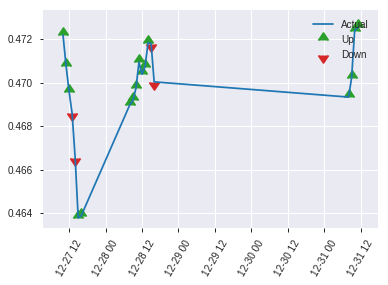


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1942552991703393
RMSE: 0.44074402908075716
LogLoss: 0.5715477465991695
Mean Per-Class Error: 0.26621599871237733
AUC: 0.7789312731369709
pr_auc: 0.7684786845759208
Gini: 0.5578625462739417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38389153017059324: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   67   0.5877   (67.0/114.0)
1      9    100  0.0826   (9.0/109.0)
Total  56   167  0.3408   (76.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383892     0.724638  164
max f2                       0.0917932    0.83589   213
max f0point5                 0.548838     0.743982  86
max accuracy                 0.544945     0.735426  93
max precision                0.984577     1         0
max recall                   0.0917932    1         213
max specificity              0.984577     1         0
max absolute_mcc             0.544945     0.473317  93
max min_per_class_accuracy   0.529224     0.692982  109
max mean_per_class_accuracy  0.544945     0.733784  93

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.966509           2.04587   2.04587            1                0.975848  1                           0.975848            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.944747           2.04587   2.04587            1                0.959245  1                           0.969207            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.92444            1.02294   1.7536             0.5              0.929428  0.857143                    0.957841            0.00917431      0.0550459                  2.29358   75.3604
    4        0.0403587                   0.913588           1.02294   1.59123            0.5              0.920745  0.777778                    0.949598            0.00917431      0.0642202                  2.29358   59.1233
    5        0.0538117                   0.908075           2.04587   1.70489            1                0.910554  0.833333                    0.939837            0.0275229       0.0917431                  104.587   70.4893
    6        0.103139                    0.832374           1.85988   1.77902            0.909091         0.862254  0.869565                    0.902732            0.0917431       0.183486                   85.9883   77.9019
    7        0.152466                    0.782375           2.04587   1.86535            1                0.816342  0.911765                    0.874782            0.100917        0.284404                   104.587   86.5353
    8        0.201794                    0.714161           1.48791   1.77309            0.727273         0.746186  0.866667                    0.843348            0.0733945       0.357798                   48.7907   77.3089
    9        0.300448                    0.609355           1.5809    1.70998            0.772727         0.646231  0.835821                    0.778623            0.155963        0.513761                   58.0901   70.9982
    10       0.399103                    0.547585           1.20892   1.58613            0.590909         0.572178  0.775281                    0.727591            0.119266        0.633028                   20.8924   58.6125
    11       0.502242                    0.529224           0.711607  1.40654            0.347826         0.538778  0.6875                      0.688817            0.0733945       0.706422                   -28.8393  40.6537
    12       0.600897                    0.471778           0.743953  1.29775            0.363636         0.498274  0.634328                    0.657534            0.0733945       0.779817                   -25.6047  29.7754
    13       0.699552                    0.417305           0.743953  1.21965            0.363636         0.443836  0.596154                    0.627397            0.0733945       0.853211                   -25.6047  21.9654
    14       0.798206                    0.313464           0.836947  1.17235            0.409091         0.372501  0.573034                    0.595893            0.0825688       0.93578                    -16.3053  17.2353
    15       0.896861                    0.189083           0.278982  1.07408            0.136364         0.259924  0.525                       0.558936            0.0275229       0.963303                   -72.1018  7.40826
    16       1                           0.0363048          0.355804  1                  0.173913         0.120173  0.488789                    0.513683         

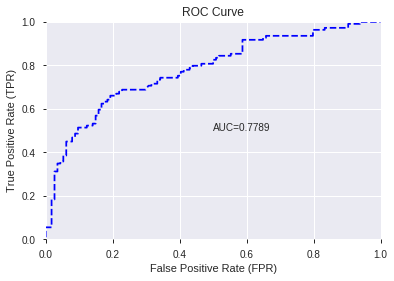

This function is available for GLM models only


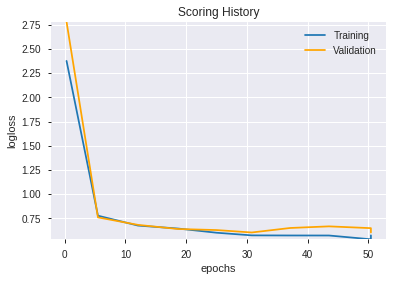

--2019-09-03 04:24:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_035954_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_035954_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_042507_model_6  0.773378  0.571950              0.309432  0.441619  0.195027
1  DeepLearning_grid_1_AutoML_20190903_042507_model_5  0.772252  0.568744              0.330356  0.440632  0.194156
2  DeepLearning_grid_1_AutoML_20190903_042507_model_9  0.771366  0.573432              0.330959  0.442529  0.195832
3  DeepLearning_grid_1_AutoML_20190903_042507_model_8  0.765693  0.586905              0.286335  0.447477  0.200236
4  DeepLearning_grid_1_AutoML_20190903_042507_model_3  0.765331  0.660015              0.307259  0.459439  0.211084
5               DeepLearning_1_AutoML_20190903_042507  0.763319  0.593023              0.304643  0.451054  0.203450
6  DeepLearning_grid_1_AutoML_20190903_042507_model_2  0.757605  0.665257              0.303477  0.472027  0.222810
7  DeepLearning_grid_1_AutoML_20190903_042507_model_4  0.748028  0.819713              0.335546  0.489580  0.239688
8  DeepLearning_grid_1_AutoML_20190903_042507_model_7  0.743441  0.688760              0.360856  0.473443  0.224149
9  DeepLearning_grid_1_AutoML_20190903_042507_model_1  0.741510  0.826017              0.357275  0.499734  0.249735

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.030134
1     CDLCLOSINGMARUBOZU             0.880071           0.880071    0.026520
2                 TRANGE             0.793345           0.793345    0.023907
3                    SUB             0.760224           0.760224    0.022909
4           CDLSHORTLINE             0.731540           0.731540    0.022044
5           STOCHF_fastk             0.720614           0.720614    0.021715
6                    DIV             0.697731           0.697731    0.021025
7       CDLDRAGONFLYDOJI             0.696606           0.696606    0.020991
8           CDLENGULFING             0.690120           0.690120    0.020796
9                   hour             0.686577           0.686577    0.020689
10             PLUS_DI_8             0.685947           0.685947    0.020670
11               BETA_30             0.683333           0.683333    0.020591
12                SAREXT             0.681586           0.681586    0.020539
13             CORREL_24             0.679315           0.679315    0.020470
14               WILLR_8             0.678681           0.678681    0.020451
15         CDLHANGINGMAN             0.672476           0.672476    0.020264
16           CDLMARUBOZU             0.666282           0.666282    0.020078
17          HT_TRENDMODE             0.664736           0.664736    0.020031
18            aroonup_24             0.662917           0.662917    0.019976
19                ULTOSC             0.662576           0.662576    0.019966
20              WILLR_12             0.655074           0.655074    0.019740
21           CDLLONGLINE             0.655001           0.655001    0.019738
22             CDLTAKURI             0.650338           0.650338    0.019597
23            AROONOSC_8             0.650163           0.650163    0.019592
24               BETA_14             0.647084           0.647084    0.019499
25             dayofweek             0.645366           0.645366    0.019447
26               weekday             0.644310           0.644310    0.019416
27                 ADOSC             0.638427           0.638427    0.019238
28                 MFI_8             0.636608           0.636608    0.019183
29                MFI_12             0.631054           0.631054    0.019016
30          weekday_name             0.628766           0.628766    0.018947
31            aroonup_30             0.627986           0.627986    0.018924
32              WILLR_14             0.627985           0.627985    0.018924
33           STOCH_slowk             0.626625           0.626625    0.018883
34          aroondown_12             0.626591           0.626591    0.018882
35  HT_PHASOR_quadrature             0.623137           0.623137    0.018778
36              WILLR_30             0.619899           0.619899    0.018680
37        STOCHRSI_fastd             0.619349           0.619349    0.018663
38           aroondown_8             0.619122           0.619122    0.018657
39           AROONOSC_12             0.617061           0.617061    0.018594
40           CDLBELTHOLD             0.615600           0.615600    0.018550
41             CORREL_20             0.615115           0.615115    0.018536
42           STOCH_slowd             0.613661           0.613661    0.018492
43                 CMO_8             0.612784           0.612784    0.018466
44              WILLR_20             0.612596           0.612596    0.018460
45             aroonup_8             0.611659           0.611659    0.018432
46              WILLR_24             0.611129           0.611129    0.018416
47          STOCHF_fastd             0.607003           0.607003    0.018291
48                 RSI_8             0.602414           0.602414    0.018153
49        STOCHRSI_fastk             0.598660           0.598660    0.018040

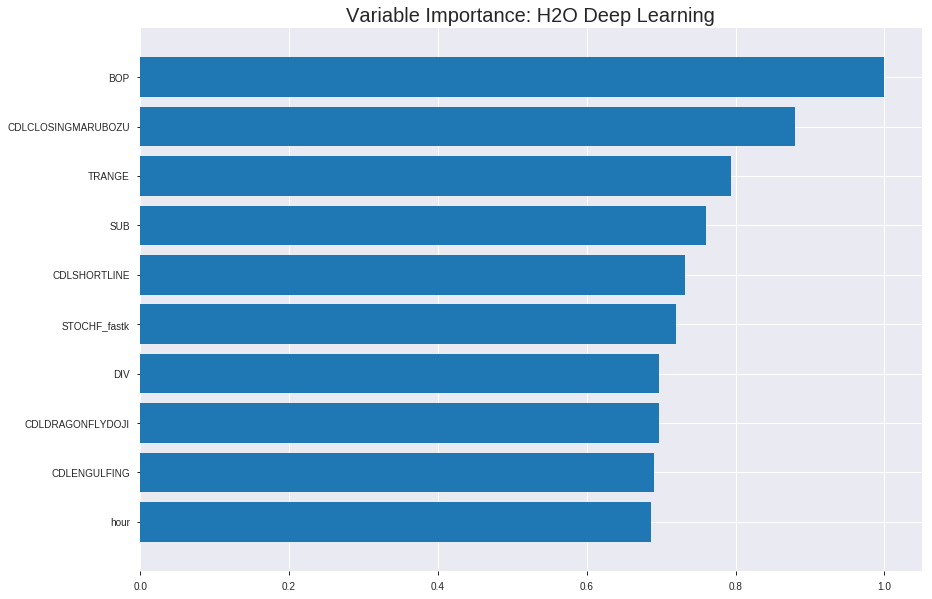

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_042507_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.185655380709784
RMSE: 0.4308774543994893
LogLoss: 0.5458051817714356
Mean Per-Class Error: 0.28237077809180877
AUC: 0.7918820708464829
pr_auc: 0.7937809219051559
Gini: 0.5837641416929658
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3892721529666525: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      394  379   0.4903   (379.0/773.0)
1      93   692   0.1185   (93.0/785.0)
Total  487  1071  0.303    (472.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389272     0.74569   259
max f2                       0.210089     0.85374   333
max f0point5                 0.582523     0.730023  160
max accuracy                 0.496281     0.717587  203
max precision                0.995646     1         0
max recall                   0.0493673    1         386
max specificity              0.995646     1         0
max absolute_mcc             0.496281     0.435258  203
max min_per_class_accuracy   0.492503     0.71465   204
max mean_per_class_accuracy  0.496281     0.717629  203

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.974627           1.98471   1.98471            1                0.985392   1                           0.985392            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.96132            1.86067   1.92269            0.9375           0.966811   0.96875                     0.976101            0.0191083       0.0394904                  86.0669   92.2691
    3        0.0301669                   0.946165           1.8524    1.90026            0.933333         0.953996   0.957447                    0.969047            0.0178344       0.0573248                  85.2399   90.0257
    4        0.0404365                   0.933253           1.98471   1.92171            1                0.940718   0.968254                    0.961852            0.0203822       0.077707                   98.4713   92.1707
    5        0.0500642                   0.915911           1.98471   1.93382            1                0.926642   0.974359                    0.955081            0.0191083       0.0968153                  98.4713   93.3823
    6        0.100128                    0.849289           1.8066    1.87021            0.910256         0.881396   0.942308                    0.918239            0.0904459       0.187261                   80.6598   87.0211
    7        0.150193                    0.77425            1.65393   1.79812            0.833333         0.810482   0.905983                    0.88232             0.0828025       0.270064                   65.3928   79.8116
    8        0.200257                    0.71497            1.34859   1.68573            0.679487         0.746364   0.849359                    0.848331            0.0675159       0.33758                    34.8587   68.5734
    9        0.300385                    0.625621           1.46309   1.61152            0.737179         0.670085   0.811966                    0.788916            0.146497        0.484076                   46.309    61.1519
    10       0.399872                    0.554008           1.13961   1.49411            0.574194         0.589885   0.752809                    0.739397            0.113376        0.597452                   13.961    49.411
    11       0.5                         0.4911             1.17047   1.4293             0.589744         0.523293   0.720154                    0.696121            0.117197        0.71465                    17.0472   42.9299
    12       0.600128                    0.438031           0.877854  1.33729            0.442308         0.464607   0.673797                    0.657494            0.0878981       0.802548                   -12.2146  33.7294
    13       0.699615                    0.381701           0.857908  1.26912            0.432258         0.409526   0.63945                     0.622233            0.0853503       0.887898                   -14.2092  26.9124
    14       0.799743                    0.302151           0.547068  1.17872            0.275641         0.343277   0.5939                      0.587307            0.0547771       0.942675                   -45.2932  17.8722
    15       0.899872                    0.146688           0.407121  1.09287            0.205128         0.232423   0.550642                    0.547819            0.0407643       0.983439                   -59.2879  9.28664
    16       1                           0.0177182          0.165393  1                  0.0833333        0.0760466  0.503851                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2119185348368291
RMSE: 0.4603461033144835
LogLoss: 0.616173015926643
Mean Per-Class Error: 0.3096045197740114
AUC: 0.7325968523002422
pr_auc: 0.7273434280935553
Gini: 0.46519370460048437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40302231775954506: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  102  0.4857   (102.0/210.0)
1      33   203  0.1398   (33.0/236.0)
Total  141  305  0.3027   (135.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403022     0.750462  270
max f2                       0.174923     0.859729  343
max f0point5                 0.416298     0.700431  257
max accuracy                 0.410719     0.699552  264
max precision                0.995406     1         0
max recall                   0.0379684    1         389
max specificity              0.995406     1         0
max absolute_mcc             0.408121     0.404498  266
max min_per_class_accuracy   0.475917     0.666667  204
max mean_per_class_accuracy  0.410719     0.690395  264

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.977467           1.88983   1.88983            1                0.986079   1                           0.986079            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.968008           1.88983   1.88983            1                0.973589   1                           0.980528            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.933504           1.1339    1.61985            0.6              0.949189   0.857143                    0.969335            0.0127119       0.0508475                  13.3898   61.9855
    4        0.0403587                   0.915801           1.41737   1.57486            0.75             0.924214   0.833333                    0.959308            0.0127119       0.0635593                  41.7373   57.4859
    5        0.0515695                   0.90788            1.51186   1.56116            0.8              0.913533   0.826087                    0.949357            0.0169492       0.0805085                  51.1864   56.1164
    6        0.100897                    0.819977           1.46032   1.51186            0.772727         0.859411   0.8                         0.905384            0.0720339       0.152542                   46.0324   51.1864
    7        0.150224                    0.756922           1.54622   1.52315            0.818182         0.789303   0.80597                     0.867268            0.0762712       0.228814                   54.6225   52.3147
    8        0.201794                    0.679848           1.39683   1.49087            0.73913          0.717143   0.788889                    0.828903            0.0720339       0.300847                   39.6831   49.0866
    9        0.300448                    0.586671           1.15967   1.38211            0.613636         0.628204   0.731343                    0.763002            0.114407        0.415254                   15.9669   38.2115
    10       0.401345                    0.529228           1.1339    1.31971            0.6              0.555219   0.698324                    0.710766            0.114407        0.529661                   13.3898   31.9714
    11       0.5                         0.4777             1.20262   1.29661            0.636364         0.504673   0.686099                    0.670102            0.118644        0.648305                   20.2619   29.661
    12       0.600897                    0.437068           1.21789   1.28339            0.644444         0.459084   0.679104                    0.63467             0.122881        0.771186                   21.7891   28.3392
    13       0.699552                    0.386481           0.944915  1.23566            0.5              0.414322   0.653846                    0.603595            0.0932203       0.864407                   -5.50847  23.5658
    14       0.800448                    0.276268           0.629944  1.15931            0.333333         0.339716   0.613445                    0.570333            0.0635593       0.927966                   -37.0056  15.9308
    15       0.899103                    0.118698           0.429507  1.07923            0.227273         0.186523   0.571072                    0.528219            0.0423729       0.970339                   -57.0493  7.92299
    16       1                           0.0221881          0.293974  1                  0.155556         0.0623641  0.529148                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:28:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:28:50  2 min  1.759 sec  965 obs/sec       1         1             1558       0.533448         1.17566             -0.138336      0.726302        0.727675           1.73662          0.355584                         0.588639           1.40634               -0.390708        0.684726          0.684037             1.88983            0.360987
    2019-09-03 04:28:55  2 min  7.193 sec  1873 obs/sec      8         8             12464      0.430877         0.545805            0.257334       0.791882        0.793781           1.98471          0.302953                         0.460346           0.616173              0.149435         0.732597          0.727343             1.88983            0.302691
    2019-09-03 04:29:01  2 min 12.503 sec  2560 obs/sec      19        19            29602      0.42225          0.527104            0.286779       0.80988         0.809911           1.86067          0.299743                         0.456032           0.617772              0.165302         0.746509          0.73941              1.88983            0.311659
    2019-09-03 04:29:06  2 min 17.893 sec  2919 obs/sec      31        31            48298      0.415171         0.510035            0.310492       0.820886        0.819376           1.98471          0.288832                         0.45473            0.627761              0.170064         0.749798          0.741353             1.88983            0.311659
    2019-09-03 04:29:11  2 min 23.060 sec  3146 obs/sec      43        43            66994      0.406015         0.490951            0.340567       0.839529        0.837967           1.98471          0.266367                         0.454669           0.629137              0.170286         0.748467          0.739647             1.88983            0.298206
    2019-09-03 04:29:16  2 min 28.188 sec  3295 obs/sec      55        55            85690      0.39673          0.471001            0.370385       0.852313        0.847524           1.98471          0.256739                         0.460003           0.648661              0.150703         0.741273          0.737291             1.88983            0.318386
    2019-09-03 04:29:21  2 min 33.287 sec  3400 obs/sec      67        67            104386     0.38704          0.449882            0.400763       0.865327        0.854619           1.98471          0.240051                         0.459019           0.650871              0.154332         0.748971          0.731603             1.88983            0.302691
    2019-09-03 04:29:22  2 min 33.704 sec  3399 obs/sec      67        67            104386     0.430877         0.545805            0.257334       0.791882        0.793781           1.98471          0.302953                         0.460346           0.616173              0.149435         0.732597          0.727343             1.88983            0.302691

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.030133876983121293
CDLCLOSINGMARUBOZU  0.8800711631774902     0.8800711631774902   0.026519956167582955
TRANGE              0.7933451533317566     0.7933451533317566   0.02390656525565465
SUB                 0.7602242231369019     0.7602242231369019   0.02290850321959635
CDLSHORTLINE        0.7315396666526794     0.7315396666526794   0.0220441263231854
---                 ---                    ---                  ---
aroonup_8           0.6116592288017273     0.6116592288017273   0.01843166395630209
WILLR_24            0.6111285090446472     0.6111285090446472   0.018415671312429726
STOCHF_fastd        0.6070029735565186     0.6070029735565186   0.018291352933540957
RSI_8               0.602414071559906      0.602414071559906    0.018153071525287435
STOCHRSI_fastk      0.5986596345901489     0.5986596345901489   0.018039935783499893


See the whole table with table.as_data_frame()


('accuracy', 0.7174887892376681)

('F1', 0.734848484848485)

('auc', 0.7733784001287622)

('logloss', 0.5719497159928125)

('mean_per_class_error', 0.2839610494125222)

('rmse', 0.4416187296306308)

('mse', 0.19502710236057222)

deeplearning prediction progress: |███████████████████████████████████████| 100%


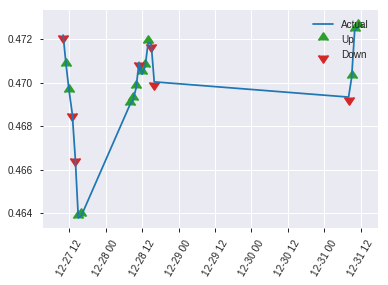


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19502710236057222
RMSE: 0.4416187296306308
LogLoss: 0.5719497159928125
Mean Per-Class Error: 0.2839610494125222
AUC: 0.7733784001287622
pr_auc: 0.7549252967362472
Gini: 0.5467568002575245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3192160979086081: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   58   0.5088   (58.0/114.0)
1      12   97   0.1101   (12.0/109.0)
Total  68   155  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319216     0.734848  154
max f2                       0.0850005    0.842434  204
max f0point5                 0.494313     0.721649  93
max accuracy                 0.494313     0.717489  93
max precision                0.988136     1         0
max recall                   0.0660898    1         210
max specificity              0.988136     1         0
max absolute_mcc             0.494313     0.436983  93
max min_per_class_accuracy   0.450409     0.701754  110
max mean_per_class_accuracy  0.484683     0.716039  95

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 46.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.970372           2.04587   2.04587            1                0.979348   1                           0.979348            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.964078           2.04587   2.04587            1                0.969211   1                           0.975294            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.939323           1.02294   1.7536             0.5              0.949203   0.857143                    0.967839            0.00917431      0.0550459                  2.29358   75.3604
    4        0.0403587                   0.923701           2.04587   1.81855            1                0.938252   0.888889                    0.961264            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.919688           2.04587   1.87538            1                0.920433   0.916667                    0.951056            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.839534           2.04587   1.95692            1                0.878842   0.956522                    0.916519            0.100917        0.201835                   104.587   95.6921
    7        0.152466                    0.757538           1.30192   1.74501            0.636364         0.802634   0.852941                    0.879674            0.0642202       0.266055                   30.1918   74.5008
    8        0.201794                    0.706661           1.48791   1.68216            0.727273         0.727194   0.822222                    0.842401            0.0733945       0.33945                    48.7907   68.2161
    9        0.300448                    0.577058           1.30192   1.55731            0.636364         0.632586   0.761194                    0.773507            0.12844         0.46789                    30.1918   55.7305
    10       0.399103                    0.504959           1.30192   1.49418            0.636364         0.540056   0.730337                    0.7158              0.12844         0.59633                    30.1918   49.4176
    11       0.502242                    0.4502             1.06741   1.40654            0.521739         0.477274   0.6875                      0.666817            0.110092        0.706422                   6.74112   40.6537
    12       0.600897                    0.385306           0.929942  1.32829            0.454545         0.420739   0.649254                    0.626416            0.0917431       0.798165                   -7.00584  32.829
    13       0.699552                    0.313055           0.929942  1.27211            0.454545         0.35509    0.621795                    0.588152            0.0917431       0.889908                   -7.00584  27.2112
    14       0.798206                    0.208565           0.371977  1.16086            0.181818         0.268466   0.567416                    0.54864             0.0366972       0.926606                   -62.8023  16.086
    15       0.896861                    0.103039           0.464971  1.08431            0.227273         0.169963   0.53                        0.506986            0.0458716       0.972477                   -53.5029  8.43119
    16       1                           0.0140895          0.266853  1                  0.130435         0.0624423  0.488789                    0

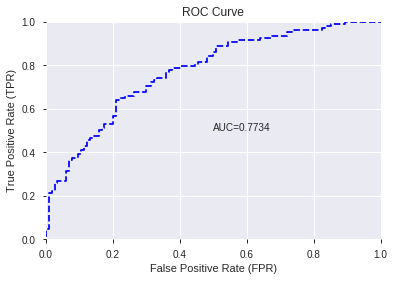

This function is available for GLM models only


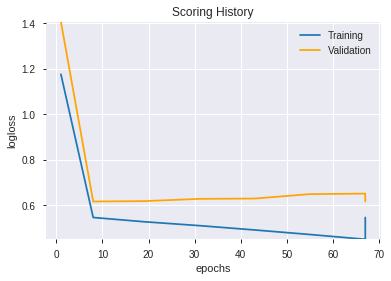

--2019-09-03 04:32:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_042507_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_042507_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'SUB',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'DIV',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'hour',
 'PLUS_DI_8',
 'BETA_30',
 'SAREXT',
 'CORREL_24',
 'WILLR_8',
 'CDLHANGINGMAN',
 'CDLMARUBOZU',
 'HT_TRENDMODE',
 'aroonup_24',
 'ULTOSC',
 'WILLR_12',
 'CDLLONGLINE',
 'CDLTAKURI',
 'AROONOSC_8',
 'BETA_14',
 'dayofweek',
 'weekday',
 'ADOSC',
 'MFI_8',
 'MFI_12',
 'weekday_name',
 'aroonup_30',
 'WILLR_14',
 'STOCH_slowk',
 'aroondown_12',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'STOCHRSI_fastd',
 'aroondown_8',
 'AROONOSC_12',
 'CDLBELTHOLD',
 'CORREL_20',
 'STOCH_slowd',
 'CMO_8',
 'WILLR_20',
 'aroonup_8',
 'WILLR_24',
 'STOCHF_fastd',
 'RSI_8',
 'STOCHRSI_fastk']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_043218_model_1  0.778287  0.566663              0.296073  0.440043  0.193638

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.736893           1.000000    0.116407
1                 ULTOSC             0.371737           0.504465    0.058723
2           STOCHF_fastk             0.363398           0.493148    0.057406
3           STOCHF_fastd             0.283177           0.384285    0.044733
4                WILLR_8             0.281751           0.382349    0.044508
5            STOCH_slowk             0.281344           0.381798    0.044444
6                    SUB             0.268195           0.363954    0.042367
7     CDLCLOSINGMARUBOZU             0.263047           0.356968    0.041553
8              PLUS_DI_8             0.240021           0.325721    0.037916
9                 SAREXT             0.228645           0.310282    0.036119
10        STOCHRSI_fastd             0.221408           0.300462    0.034976
11             CORREL_24             0.218493           0.296506    0.034515
12        STOCHRSI_fastk             0.206460           0.280176    0.032614
13             CORREL_20             0.197280           0.267719    0.031164
14                  hour             0.141839           0.192483    0.022406
15           CDLBELTHOLD             0.135151           0.183407    0.021350
16                TRANGE             0.128934           0.174970    0.020368
17      CDLDRAGONFLYDOJI             0.118396           0.160670    0.018703
18             CDLTAKURI             0.117912           0.160013    0.018627
19          aroondown_12             0.117885           0.159976    0.018622
20         CDLHANGINGMAN             0.111345           0.151100    0.017589
21          CDLENGULFING             0.110351           0.149751    0.017432
22              WILLR_24             0.106602           0.144664    0.016840
23            aroonup_30             0.104484           0.141790    0.016505
24               BETA_30             0.100153           0.135913    0.015821
25              WILLR_20             0.090426           0.122713    0.014285
26                 MFI_8             0.073643           0.099936    0.011633
27  HT_PHASOR_quadrature             0.070168           0.095221    0.011084
28              WILLR_30             0.052980           0.071896    0.008369
29           AROONOSC_12             0.050301           0.068260    0.007946
30             dayofweek             0.048521           0.065845    0.007665
31               weekday             0.047937           0.065053    0.007573
32           CDLLONGLINE             0.046424           0.063000    0.007334
33              WILLR_12             0.041278           0.056016    0.006521
34             aroonup_8             0.039649           0.053806    0.006263
35              WILLR_14             0.038553           0.052318    0.006090
36               BETA_14             0.037002           0.050213    0.005845
37          HT_TRENDMODE             0.035543           0.048234    0.005615
38            aroonup_24             0.030493           0.041381    0.004817
39                 ADOSC             0.022055           0.029930    0.003484
40           CDLMARUBOZU             0.021609           0.029325    0.003414
41                 CMO_8             0.018541           0.025160    0.002929
42            AROONOSC_8             0.018310           0.024847    0.002892
43                 RSI_8             0.017254           0.023415    0.002726
44                   DIV             0.016987           0.023052    0.002683
45          weekday_name             0.016462           0.022339    0.002600
46          CDLSHORTLINE             0.016009           0.021725    0.002529
47           STOCH_slowd             0.012460           0.016909    0.001968
48           aroondown_8             0.008275           0.011229    0.001307
49                MFI_12             0.004554           0.006180    0.000719

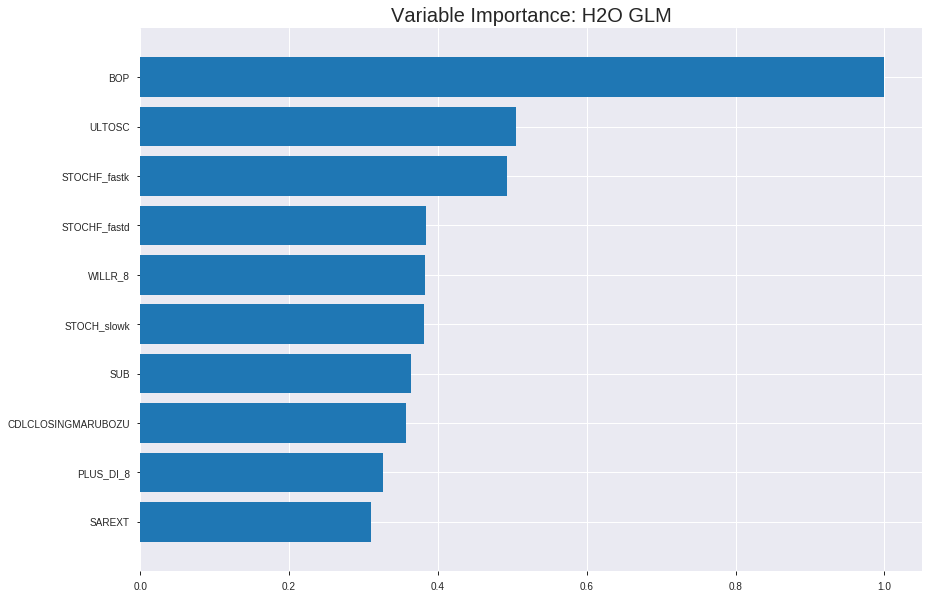

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_043218_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18590286563981165
RMSE: 0.4311645458984443
LogLoss: 0.5497036676577874
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.7541875235074
Residual deviance: 1712.8766284216658
AIC: 1814.8766284216658
AUC: 0.7920905397944974
pr_auc: 0.7872281717479324
Gini: 0.5841810795889948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36892667607759355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      411  362   0.4683   (362.0/773.0)
1      100  685   0.1274   (100.0/785.0)
Total  511  1047  0.2965   (462.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368927     0.747817  256
max f2                       0.147337     0.850714  351
max f0point5                 0.559517     0.723629  177
max accuracy                 0.470577     0.722721  214
max precision                0.986601     1         0
max recall                   0.0395268    1         391
max specificity              0.986601     1         0
max absolute_mcc             0.460959     0.448722  218
max min_per_class_accuracy   0.517269     0.712102  194
max mean_per_class_accuracy  0.470577     0.72229   214

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.936589           1.98471   1.98471            1                0.956335   1                           0.956335            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.917859           1.73662   1.86067            0.875            0.924559   0.9375                      0.940447            0.0178344       0.0382166                  73.6624   86.0669
    3        0.0301669                   0.905815           1.72008   1.8158             0.866667         0.911385   0.914894                    0.931172            0.0165605       0.0547771                  72.0085   81.5802
    4        0.0404365                   0.897721           1.86067   1.8272             0.9375           0.901609   0.920635                    0.923664            0.0191083       0.0738854                  86.0669   82.7196
    5        0.0500642                   0.888417           1.98471   1.85749            1                0.894234   0.935897                    0.918004            0.0191083       0.0929936                  98.4713   85.7488
    6        0.100128                    0.828696           1.75571   1.8066             0.884615         0.857222   0.910256                    0.887613            0.0878981       0.180892                   75.5708   80.6598
    7        0.150193                    0.77954            1.73026   1.78115            0.871795         0.805065   0.897436                    0.860097            0.0866242       0.267516                   73.0263   78.1153
    8        0.200257                    0.737891           1.47581   1.70482            0.74359          0.759473   0.858974                    0.834941            0.0738854       0.341401                   47.5813   70.4818
    9        0.300385                    0.67098            1.33586   1.58183            0.673077         0.703609   0.797009                    0.791163            0.133758        0.475159                   33.5865   58.1834
    10       0.399872                    0.594854           1.24205   1.4973             0.625806         0.631174   0.754414                    0.751359            0.123567        0.598726                   24.2046   49.7296
    11       0.5                         0.517115           1.11958   1.42166            0.564103         0.556381   0.716303                    0.712313            0.112102        0.710828                   11.9582   42.1656
    12       0.600128                    0.435329           1.03052   1.3564             0.519231         0.475002   0.683422                    0.672719            0.103185        0.814013                   3.05243   35.6398
    13       0.699615                    0.343946           0.717058  1.26548            0.36129          0.391985   0.637615                    0.632798            0.0713376       0.88535                    -28.2942  26.5482
    14       0.799743                    0.262949           0.559791  1.17713            0.282051         0.304792   0.593098                    0.591732            0.056051        0.941401                   -44.0209  17.7129
    15       0.899872                    0.161406           0.407121  1.09145            0.205128         0.212748   0.549929                    0.549562            0.0407643       0.982166                   -59.2879  9.14508
    16       1                           0.00153089         0.178115  1                  0.0897436        0.0930368  0.503851                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2013448326204025
RMSE: 0.4487146449809751
LogLoss: 0.5853710937896841
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 617.9132227761654
Residual deviance: 522.1510156603982
AIC: 624.1510156603982
AUC: 0.7554479418886199
pr_auc: 0.7452632341509473
Gini: 0.5108958837772397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.274199716617704: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   131  0.6238   (131.0/210.0)
1      13   223  0.0551   (13.0/236.0)
Total  92   354  0.3229   (144.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2742       0.755932  314
max f2                       0.11686      0.864745  364
max f0point5                 0.536671     0.716292  188
max accuracy                 0.418406     0.704036  237
max precision                0.973654     1         0
max recall                   0.0702064    1         378
max specificity              0.973654     1         0
max absolute_mcc             0.418406     0.405109  237
max min_per_class_accuracy   0.494697     0.680952  206
max mean_per_class_accuracy  0.418406     0.699092  237

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 48.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.921622           1.88983   1.88983            1                0.939964   1                           0.939964            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.887234           1.88983   1.88983            1                0.90173    1                           0.922971            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.877525           1.51186   1.75484            0.8              0.884039   0.928571                    0.909067            0.0169492       0.0550847                  51.1864   75.4843
    4        0.0403587                   0.861809           0.944915  1.57486            0.5              0.867989   0.833333                    0.899938            0.00847458      0.0635593                  -5.50847  57.4859
    5        0.0515695                   0.858929           1.51186   1.56116            0.8              0.860273   0.826087                    0.891315            0.0169492       0.0805085                  51.1864   56.1164
    6        0.100897                    0.805627           1.54622   1.55386            0.818182         0.832261   0.822222                    0.862445            0.0762712       0.15678                    54.6225   55.3861
    7        0.150224                    0.751245           1.28852   1.46673            0.681818         0.77586    0.776119                    0.834014            0.0635593       0.220339                   28.8521   46.6734
    8        0.201794                    0.717577           1.64333   1.51186            0.869565         0.736398   0.8                         0.809068            0.0847458       0.305085                   64.3331   51.1864
    9        0.300448                    0.63169            1.28852   1.43853            0.681818         0.67568    0.761194                    0.765269            0.127119        0.432203                   28.8521   43.8528
    10       0.401345                    0.580608           1.30188   1.40418            0.688889         0.602693   0.743017                    0.724398            0.131356        0.563559                   30.1883   40.4176
    11       0.5                         0.499426           1.11672   1.34746            0.590909         0.545281   0.713004                    0.689056            0.110169        0.673729                   11.6718   34.7458
    12       0.600897                    0.416663           1.0919    1.30455            0.577778         0.462676   0.690299                    0.651045            0.110169        0.783898                   9.19021   30.4547
    13       0.699552                    0.341729           0.859014  1.24172            0.454545         0.378839   0.657051                    0.612657            0.0847458       0.868644                   -14.0986  24.1716
    14       0.800448                    0.262345           0.755932  1.18048            0.4              0.302887   0.62465                     0.57361             0.0762712       0.944915                   -24.4068  18.0482
    15       0.899103                    0.134321           0.343606  1.08866            0.181818         0.208367   0.57606                     0.533534            0.0338983       0.978814                   -65.6394  8.86555
    16       1                           0.00174765         0.209981  1                  0.111111         0.0752336  0.529148                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 04:32:18  0.000 sec   2            .2E2      51            1.3647735628998092  1.3654477410623136
     2019-09-03 04:32:18  0.009 sec   4            .13E2     51            1.3541007482315162  1.3556351591277511
     2019-09-03 04:32:18  0.020 sec   6            .78E1     51            1.339456738625012   1.3423371627249527
     2019-09-03 04:32:18  0.031 sec   8            .49E1     51            1.3203590452456075  1.3253276324414733
     2019-09-03 04:32:18  0.041 sec   10           .3E1      51            1.296775153920804   1.3048743795238114
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 04:32:19  0.188 sec   38           .38E-2    51            1.09738446336654    1.1707893935947797
     2019-09-03 04:32:19  0.203 sec   40           .24E-2    51            1.095909498476235   1.1712117856588957
     2019-09-03 04:32:19  0.217 sec   42           .15E-2    51            1.0948327677165108  1.1717985329850817
     2019-09-03 04:32:19  0.227 sec   44           .92E-3    51            1.0940292995724834  1.1724253553665644
     2019-09-03 04:32:19  0.237 sec   46           .57E-3    51            1.093416640051608   1.1730287940907052


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.7452471482889734)

('auc', 0.7782874617737003)

('logloss', 0.566663307569617)

('mean_per_class_error', 0.2881055850635763)

('rmse', 0.4400428165237782)

('mse', 0.19363768037417953)

glm prediction progress: |████████████████████████████████████████████████| 100%


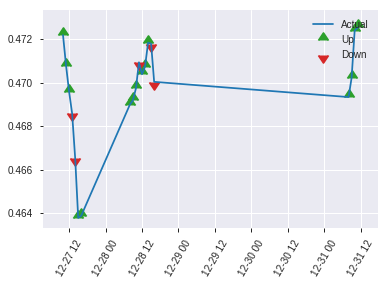


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19363768037417953
RMSE: 0.4400428165237782
LogLoss: 0.566663307569617
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.23389543359224
Residual deviance: 252.73183517604917
AIC: 354.7318351760492
AUC: 0.7782874617737003
pr_auc: 0.7547009676077749
Gini: 0.5565749235474007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2970920021837743: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   56   0.4912   (56.0/114.0)
1      11   98   0.1009   (11.0/109.0)
Total  69   154  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297092     0.745247  153
max f2                       0.109678     0.846273  207
max f0point5                 0.580829     0.704388  80
max accuracy                 0.315469     0.70852   143
max precision                0.950044     1         0
max recall                   0.109678     1         207
max specificity              0.950044     1         0
max absolute_mcc             0.315469     0.442915  143
max min_per_class_accuracy   0.418075     0.692982  110
max mean_per_class_accuracy  0.315469     0.711894  143

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 45.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.93946            2.04587   2.04587            1                0.943968   1                           0.943968            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.918584           2.04587   2.04587            1                0.931672   1                           0.93905             0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.901581           1.02294   1.7536             0.5              0.905744   0.857143                    0.929534            0.00917431      0.0550459                  2.29358   75.3604
    4        0.0403587                   0.891516           2.04587   1.81855            1                0.897875   0.888889                    0.922498            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.860727           2.04587   1.87538            1                0.871602   0.916667                    0.909774            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.818263           1.67389   1.77902            0.818182         0.834906   0.869565                    0.873968            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.772569           1.85988   1.80518            0.909091         0.789585   0.882353                    0.846667            0.0917431       0.275229                   85.9883   80.5181
    8        0.201794                    0.71648            1.30192   1.68216            0.636364         0.735337   0.822222                    0.819453            0.0642202       0.33945                    30.1918   68.2161
    9        0.300448                    0.60539            1.39491   1.58784            0.681818         0.658274   0.776119                    0.766529            0.137615        0.477064                   39.4912   58.7841
    10       0.399103                    0.522247           1.02294   1.4482             0.5              0.577832   0.707865                    0.719885            0.100917        0.577982                   2.29358   44.8201
    11       0.502242                    0.411486           1.15636   1.38827            0.565217         0.462354   0.678571                    0.666999            0.119266        0.697248                   15.6362   38.827
    12       0.600897                    0.346325           1.02294   1.32829            0.5              0.378282   0.649254                    0.619598            0.100917        0.798165                   2.29358   32.829
    13       0.699552                    0.280711           1.02294   1.28523            0.5              0.315104   0.628205                    0.576656            0.100917        0.899083                   2.29358   28.5227
    14       0.798206                    0.211618           0.464971  1.18385            0.227273         0.251056   0.578652                    0.536413            0.0458716       0.944954                   -53.5029  18.3847
    15       0.896861                    0.137005           0.185988  1.07408            0.0909091        0.173889   0.525                       0.496536            0.0183486       0.963303                   -81.4012  7.40826
    16       1                           0.0234061          0.355804  1                  0.173913         0.0834896  0.488789                    0

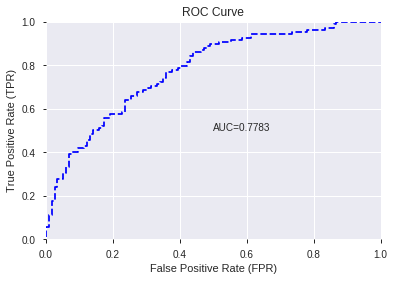

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


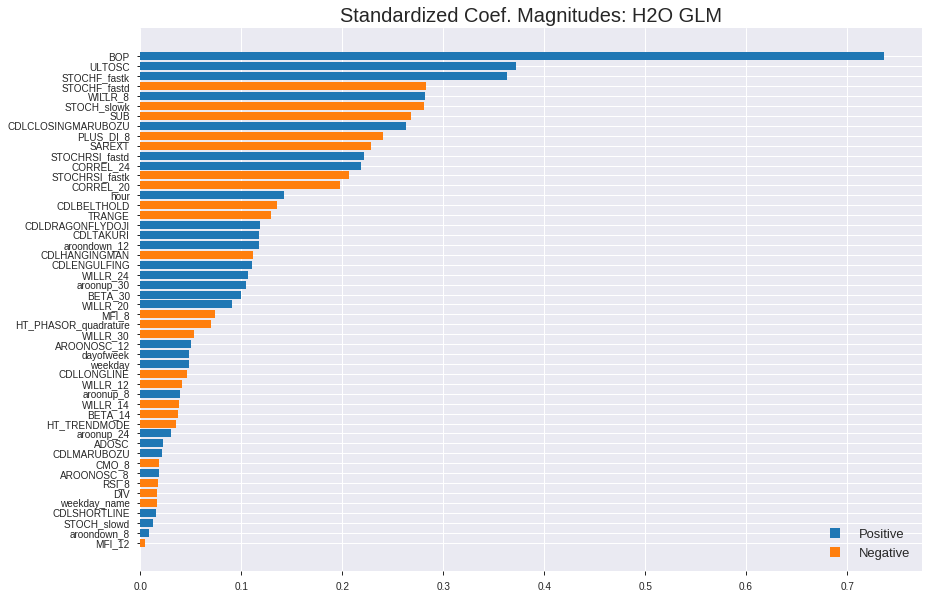

'log_likelihood'
--2019-09-03 04:32:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_043218_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_043218_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'WILLR_8',
 'STOCH_slowk',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_8',
 'SAREXT',
 'STOCHRSI_fastd',
 'CORREL_24',
 'STOCHRSI_fastk',
 'CORREL_20',
 'hour',
 'CDLBELTHOLD',
 'TRANGE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'aroondown_12',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'WILLR_24',
 'aroonup_30',
 'BETA_30',
 'WILLR_20',
 'MFI_8',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'AROONOSC_12',
 'dayofweek',
 'weekday',
 'CDLLONGLINE',
 'WILLR_12',
 'aroonup_8',
 'WILLR_14',
 'BETA_14',
 'HT_TRENDMODE',
 'aroonup_24',
 'ADOSC',
 'CDLMARUBOZU',
 'CMO_8',
 'AROONOSC_8',
 'RSI_8',
 'DIV',
 'weekday_name',
 'CDLSHORTLINE',
 'STOCH_slowd',
 'aroondown_8',
 'MFI_12']

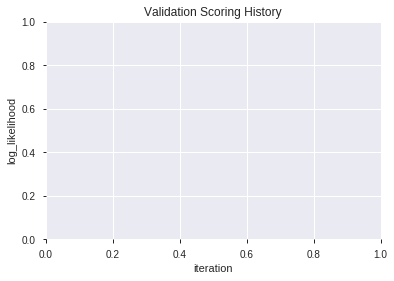

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_043229_model_6  0.789876  0.564482              0.274143  0.438414  0.192207
1               XGBoost_1_AutoML_20190903_043229  0.785852  0.568260              0.282311  0.440174  0.193754
2               XGBoost_2_AutoML_20190903_043229  0.784243  0.571565              0.278529  0.440439  0.193986
3  XGBoost_grid_1_AutoML_20190903_043229_model_2  0.783357  0.571134              0.270159  0.440954  0.194440
4  XGBoost_grid_1_AutoML_20190903_043229_model_1  0.779817  0.571445              0.292894  0.441285  0.194733
5  XGBoost_grid_1_AutoML_20190903_043229_model_3  0.777483  0.571353              0.321986  0.441853  0.195234
6               XGBoost_3_AutoML_20190903_043229  0.773861  0.576884              0.325769  0.443536  0.196724
7  XGBoost_grid_1_AutoML_20190903_043229_model_4  0.770079  0.584451              0.317198  0.447427  0.200191
8  XGBoost_grid_1_AutoML_20190903_043229_model_7  0.766699  0.588022              0.308426  0.449102  0.201693
9  XGBoost_grid_1_AutoML_20190903_043229_model_5  0.758088  0.609920              0.304040  0.458255  0.209998

variable  relative_importance  scaled_importance  percentage
0                    BOP          1878.419189           1.000000    0.193008
1           STOCHF_fastk           562.087708           0.299234    0.057755
2                 TRANGE           546.097534           0.290722    0.056112
3                    DIV           474.981781           0.252863    0.048804
4                 SAREXT           452.215363           0.240743    0.046465
5                BETA_30           375.162964           0.199723    0.038548
6                  MFI_8           338.703278           0.180313    0.034802
7              PLUS_DI_8           308.640076           0.164308    0.031713
8   HT_PHASOR_quadrature           303.061523           0.161339    0.031140
9         STOCHRSI_fastk           294.140625           0.156589    0.030223
10               BETA_14           281.706146           0.149970    0.028945
11                   SUB           258.146637           0.137428    0.026525
12                ULTOSC           249.625122           0.132891    0.025649
13                 ADOSC           246.972641           0.131479    0.025376
14                  hour           229.886017           0.122383    0.023621
15                MFI_12           214.201965           0.114033    0.022009
16               WILLR_8           209.663666           0.111617    0.021543
17              WILLR_12           171.775085           0.091447    0.017650
18        STOCHRSI_fastd           145.470627           0.077443    0.014947
19                 CMO_8           136.791748           0.072823    0.014055
20             CORREL_24           133.660294           0.071156    0.013734
21              WILLR_20           129.054855           0.068704    0.013260
22           STOCH_slowk           126.186378           0.067177    0.012966
23           STOCH_slowd           125.247780           0.066677    0.012869
24    CDLCLOSINGMARUBOZU           123.547295           0.065772    0.012695
25          aroondown_12           116.316315           0.061922    0.011952
26             aroonup_8           109.993484           0.058556    0.011302
27            aroonup_30           105.608093           0.056222    0.010851
28           AROONOSC_12           104.967979           0.055881    0.010785
29              WILLR_30           103.870491           0.055297    0.010673
30              WILLR_24            95.165977           0.050663    0.009778
31            aroonup_24            87.543823           0.046605    0.008995
32            AROONOSC_8            81.313972           0.043289    0.008355
33                 RSI_8            75.703773           0.040302    0.007779
34             dayofweek            75.496948           0.040192    0.007757
35              WILLR_14            71.141388           0.037873    0.007310
36             CORREL_20            67.650665           0.036015    0.006951
37          weekday_name            57.425125           0.030571    0.005900
38      CDLDRAGONFLYDOJI            51.155727           0.027233    0.005256
39           aroondown_8            46.959652           0.025000    0.004825
40           CDLBELTHOLD            42.866905           0.022821    0.004405
41          STOCHF_fastd            34.652481           0.018448    0.003561
42         CDLHANGINGMAN            22.039333           0.011733    0.002265
43               weekday            18.078600           0.009624    0.001858
44           CDLLONGLINE            17.248337           0.009182    0.001772
45          CDLSHORTLINE            13.672640           0.007279    0.001405
46          CDLENGULFING             7.336114           0.003905    0.000754
47             CDLTAKURI             5.668436           0.003018    0.000582
48           CDLMARUBOZU             3.920778           0.002087    0.000403
49          HT_TRENDMODE             1.098589           0.000585    0.000113

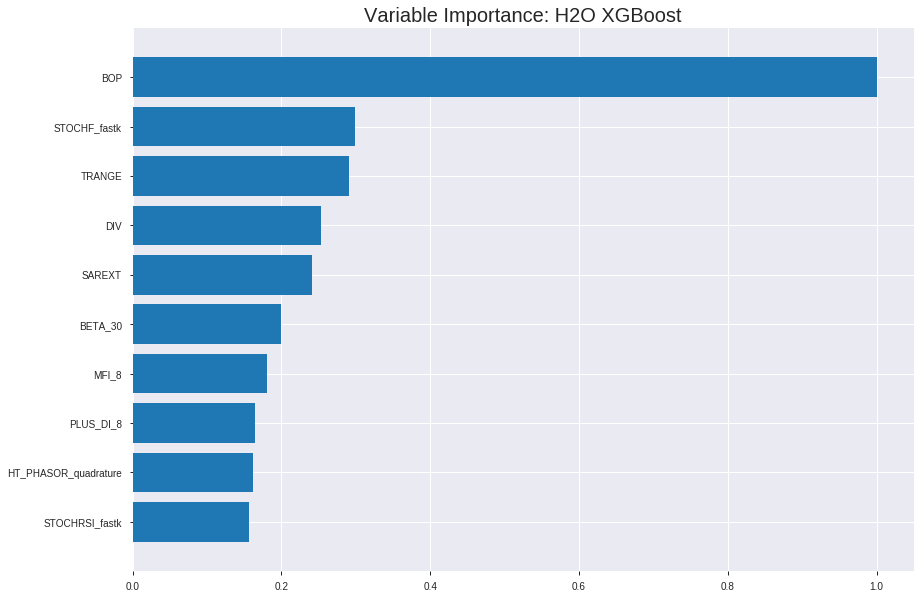

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_043229_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12728485066817904
RMSE: 0.3567700249014469
LogLoss: 0.41641729922652176
Mean Per-Class Error: 0.14262736793533337
AUC: 0.9296792214961973
pr_auc: 0.9328905485633323
Gini: 0.8593584429923946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5100728869438171: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      649  124  0.1604   (124.0/773.0)
1      98   687  0.1248   (98.0/785.0)
Total  747  811  0.1425   (222.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510073     0.860902  197
max f2                       0.32599      0.90222   276
max f0point5                 0.611296     0.863566  148
max accuracy                 0.510073     0.85751   197
max precision                0.933921     1         0
max recall                   0.179367     1         340
max specificity              0.933921     1         0
max absolute_mcc             0.510073     0.715328  197
max min_per_class_accuracy   0.519985     0.851229  192
max mean_per_class_accuracy  0.510073     0.857373  197

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.900158           1.98471    1.98471            1                0.910089  1                           0.910089            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.882238           1.98471    1.98471            1                0.890048  1                           0.900069            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.872185           1.98471    1.98471            1                0.876022  1                           0.892394            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.863313           1.98471    1.98471            1                0.867216  1                           0.886               0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.85892            1.98471    1.98471            1                0.861333  1                           0.881256            0.0191083       0.0993631                  98.4713   98.4713
    6        0.100128                    0.823548           1.98471    1.98471            1                0.840713  1                           0.860984            0.0993631       0.198726                   98.4713   98.4713
    7        0.150193                    0.790756           1.98471    1.98471            1                0.807677  1                           0.843215            0.0993631       0.298089                   98.4713   98.4713
    8        0.200257                    0.762116           1.90838    1.96563            0.961538         0.777511  0.990385                    0.826789            0.0955414       0.393631                   90.8378   96.563
    9        0.300385                    0.685779           1.75571    1.89566            0.884615         0.723609  0.955128                    0.792396            0.175796        0.569427                   75.5708   89.5656
    10       0.399872                    0.604119           1.51094    1.79994            0.76129          0.645462  0.906902                    0.755839            0.150318        0.719745                   51.0943   79.9941
    11       0.5                         0.523414           1.28497    1.69682            0.647436         0.566065  0.854942                    0.717835            0.128662        0.848408                   28.4975   69.6815
    12       0.600128                    0.433716           0.750629   1.53895            0.378205         0.479131  0.775401                    0.678009            0.0751592       0.923567                   -24.9371  53.8949
    13       0.699615                    0.326548           0.486575   1.3893             0.245161         0.382764  0.7                         0.636025            0.0484076       0.971975                   -51.3425  38.9299
    14       0.799743                    0.238723           0.216283   1.24244            0.108974         0.287675  0.626003                    0.592411            0.0216561       0.993631                   -78.3717  24.2437
    15       0.899872                    0.15341            0.0636126  1.11127            0.0320513        0.195708  0.559914                    0.54827             0.00636943      1                          -93.6387  11.127
    16       1                           0.0474046          0          1                  0                0.107358  0.503851                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19777252351162253
RMSE: 0.44471622807316413
LogLoss: 0.580001897913275
Mean Per-Class Error: 0.27681598062953994
AUC: 0.7683716707021792
pr_auc: 0.743547718044487
Gini: 0.5367433414043583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36861640214920044: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  89   0.4238   (89.0/210.0)
1      32   204  0.1356   (32.0/236.0)
Total  153  293  0.2713   (121.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368616     0.771267  261
max f2                       0.166963     0.869237  337
max f0point5                 0.421406     0.731061  240
max accuracy                 0.421406     0.7287    240
max precision                0.893205     1         0
max recall                   0.0772651    1         394
max specificity              0.893205     1         0
max absolute_mcc             0.368616     0.463263  261
max min_per_class_accuracy   0.484054     0.690476  201
max mean_per_class_accuracy  0.421406     0.723184  240

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 46.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.866015           1.88983   1.88983            1                0.879297  1                           0.879297            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.847546           1.88983   1.88983            1                0.856514  1                           0.869171            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.833602           1.1339    1.61985            0.6              0.839776  0.857143                    0.858673            0.0127119       0.0508475                  13.3898   61.9855
    4        0.0403587                   0.824103           1.41737   1.57486            0.75             0.829094  0.833333                    0.8521              0.0127119       0.0635593                  41.7373   57.4859
    5        0.0515695                   0.81286            0.755932  1.39683            0.4              0.818898  0.73913                     0.844882            0.00847458      0.0720339                  -24.4068  39.6831
    6        0.100897                    0.762714           1.37442   1.38588            0.727273         0.785129  0.733333                    0.81567             0.0677966       0.139831                   37.4422   38.5876
    7        0.150224                    0.730432           1.71803   1.49494            0.909091         0.746205  0.791045                    0.79286             0.0847458       0.224576                   71.8028   49.4941
    8        0.201794                    0.6929             1.479     1.49087            0.782609         0.709717  0.788889                    0.771613            0.0762712       0.300847                   47.8998   49.0866
    9        0.300448                    0.61778            1.50327   1.49494            0.795455         0.652403  0.791045                    0.732469            0.148305        0.449153                   50.3274   49.4941
    10       0.401345                    0.55695            1.17589   1.41473            0.622222         0.587347  0.748603                    0.695986            0.118644        0.567797                   17.5895   41.4733
    11       0.5                         0.488109           1.11672   1.35593            0.590909         0.524971  0.717489                    0.662243            0.110169        0.677966                   11.6718   35.5932
    12       0.600897                    0.425502           1.30188   1.34686            0.688889         0.454887  0.712687                    0.627426            0.131356        0.809322                   30.1883   34.6857
    13       0.699552                    0.321929           0.816063  1.272              0.431818         0.373586  0.673077                    0.591628            0.0805085       0.889831                   -18.3937  27.2001
    14       0.800448                    0.213094           0.503955  1.17519            0.266667         0.261144  0.621849                    0.54997             0.0508475       0.940678                   -49.6045  17.5189
    15       0.899103                    0.131066           0.386556  1.08866            0.204545         0.167668  0.57606                     0.508022            0.0381356       0.978814                   -61.3444  8.86555
    16       1                           0.0534744          0.209981  1                  0.111111         0.102181  0.529148                    0.467074         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:32:41  7.989 sec   0                  0.5              0.693147            0.5             0                  1                0.496149                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 04:32:41  8.105 sec   5                  0.469398         0.633417            0.853328        0.844318           1.98471          0.231707                         0.480051           0.653773              0.748194          0.714063             1.51186            0.316143
    2019-09-03 04:32:41  8.174 sec   10                 0.445802         0.588486            0.869186        0.859257           1.98471          0.222721                         0.466501           0.627063              0.759816          0.718338             1.51186            0.29148
    2019-09-03 04:32:41  8.239 sec   15                 0.42801          0.554622            0.878559        0.879432           1.98471          0.209243                         0.457468           0.608818              0.764992          0.730014             1.51186            0.284753
    2019-09-03 04:32:41  8.316 sec   20                 0.414801         0.529124            0.886434        0.886915           1.98471          0.195764                         0.452667           0.598697              0.764619          0.729263             1.88983            0.262332
    2019-09-03 04:32:41  8.384 sec   25                 0.403327         0.506752            0.892814        0.895128           1.98471          0.184852                         0.447575           0.587891              0.770732          0.733952             1.88983            0.266816
    2019-09-03 04:32:42  8.444 sec   30                 0.394321         0.488726            0.897531        0.898384           1.98471          0.189987                         0.445647           0.583342              0.769905          0.736845             1.51186            0.275785
    2019-09-03 04:32:42  8.509 sec   35                 0.385633         0.471637            0.904119        0.907927           1.98471          0.179718                         0.443948           0.579589              0.771065          0.740368             1.88983            0.29148
    2019-09-03 04:32:42  8.579 sec   40                 0.378696         0.45813             0.910699        0.9144             1.98471          0.178434                         0.444958           0.581358              0.767776          0.736987             1.51186            0.29148
    2019-09-03 04:32:42  8.639 sec   45                 0.373063         0.447121            0.914818        0.919188           1.98471          0.165597                         0.445023           0.581205              0.766737          0.736031             1.88983            0.282511
    2019-09-03 04:32:42  8.703 sec   50                 0.366053         0.434086            0.921574        0.925754           1.98471          0.156611                         0.446027           0.582925              0.765274          0.734706             1.88983            0.284753
    2019-09-03 04:32:42  8.767 sec   55                 0.361475         0.425151            0.925183        0.929223           1.98471          0.15276                          0.445387           0.581321              0.767575          0.73

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           1878.419189453125      1.0                    0.19300793207306086
STOCHF_fastk  562.0877075195312      0.2992344364216036     0.05775461977878151
TRANGE        546.0975341796875      0.29072186721999793    0.05611162640055078
DIV           474.9817810058594      0.2528625046383515     0.04880446911906299
SAREXT        452.2153625488281      0.2407425164137533     0.04646521525508344
---           ---                    ---                    ---
CDLSHORTLINE  13.672639846801758     0.00727880119814063    0.0014048663672240407
CDLENGULFING  7.336114406585693      0.0039054724567211744  0.0007537871626400505
CDLTAKURI     5.668436050415039      0.003017662980788289   0.0005824328916153765
CDLMARUBOZU   3.920778274536133      0.002087275458295127   0.00040286071987239287
HT_TRENDMODE  1.098589301109314      0.0005848477843910616  0.00011288026144283017


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7596899224806203)

('auc', 0.7898760663125705)

('logloss', 0.56448201731774)

('mean_per_class_error', 0.2701995815226139)

('rmse', 0.4384141118618801)

('mse', 0.19220693347964113)

xgboost prediction progress: |████████████████████████████████████████████| 100%


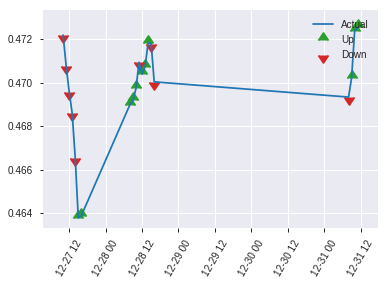


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19220693347964113
RMSE: 0.4384141118618801
LogLoss: 0.56448201731774
Mean Per-Class Error: 0.2701995815226139
AUC: 0.7898760663125705
pr_auc: 0.7537006940434877
Gini: 0.5797521326251409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24902132153511047: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   51   0.4474   (51.0/114.0)
1      11   98   0.1009   (11.0/109.0)
Total  74   149  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249021     0.75969   148
max f2                       0.160219     0.85622   182
max f0point5                 0.497801     0.732673  98
max accuracy                 0.497801     0.730942  98
max precision                0.915653     1         0
max recall                   0.0946513    1         214
max specificity              0.915653     1         0
max absolute_mcc             0.249021     0.479535  148
max min_per_class_accuracy   0.394621     0.715596  108
max mean_per_class_accuracy  0.497801     0.7298    98

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.884835           2.04587    2.04587            1                0.898696  1                           0.898696            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.868133           1.02294    1.6367             0.5              0.870741  0.8                         0.887514            0.00917431      0.0366972                  2.29358   63.6697
    3        0.0313901                   0.86206            2.04587    1.7536             1                0.865615  0.857143                    0.881257            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.841612           2.04587    1.81855            1                0.85193   0.888889                    0.87474             0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.835653           2.04587    1.87538            1                0.838733  0.916667                    0.865738            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.793969           1.67389    1.77902            0.818182         0.809765  0.869565                    0.838969            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.732849           1.48791    1.68484            0.727273         0.765385  0.823529                    0.815162            0.0733945       0.256881                   48.7907   68.4835
    8        0.201794                    0.703233           1.48791    1.6367             0.727273         0.725113  0.8                         0.79315             0.0733945       0.330275                   48.7907   63.6697
    9        0.300448                    0.603496           1.5809     1.61838            0.772727         0.657105  0.791045                    0.748479            0.155963        0.486239                   58.0901   61.8376
    10       0.399103                    0.534728           1.11593    1.49418            0.545455         0.566751  0.730337                    0.703557            0.110092        0.59633                    11.593    49.4176
    11       0.502242                    0.372096           1.15636    1.4248             0.565217         0.465985  0.696429                    0.65477             0.119266        0.715596                   15.6362   42.4803
    12       0.600897                    0.293766           0.929942   1.34356            0.454545         0.325434  0.656716                    0.6007              0.0917431       0.807339                   -7.00584  34.3557
    13       0.699552                    0.233228           1.02294    1.29834            0.5              0.262395  0.634615                    0.55299             0.100917        0.908257                   2.29358   29.8342
    14       0.798206                    0.176945           0.557965   1.20683            0.272727         0.20289   0.589888                    0.509719            0.0550459       0.963303                   -44.2035  20.6834
    15       0.896861                    0.122991           0.278982   1.10477            0.136364         0.147005  0.54                        0.469821            0.0275229       0.990826                   -72.1018  10.4771
    16       1                           0.0681154          0.0889509  1                  0.0434783        0.100968  0.488789                   

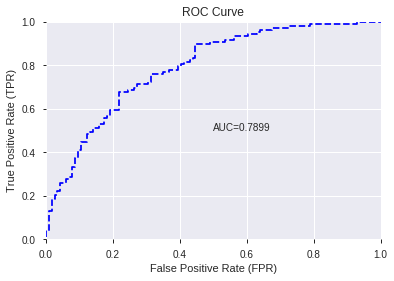

This function is available for GLM models only


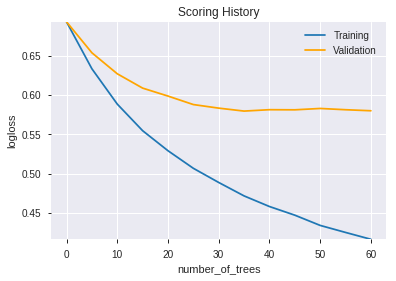

--2019-09-03 04:32:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_043229_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_043229_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'SAREXT',
 'BETA_30',
 'MFI_8',
 'PLUS_DI_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'BETA_14',
 'SUB',
 'ULTOSC',
 'ADOSC',
 'hour',
 'MFI_12',
 'WILLR_8',
 'WILLR_12',
 'STOCHRSI_fastd',
 'CMO_8',
 'CORREL_24',
 'WILLR_20',
 'STOCH_slowk',
 'STOCH_slowd',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'aroonup_8',
 'aroonup_30',
 'AROONOSC_12',
 'WILLR_30',
 'WILLR_24',
 'aroonup_24',
 'AROONOSC_8',
 'RSI_8',
 'dayofweek',
 'WILLR_14',
 'CORREL_20',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'aroondown_8',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLHANGINGMAN',
 'weekday',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_043254_model_1  0.779575  0.564149              0.310035  0.436358  0.190408

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.367423           1.000000  3.270822e-02
1           CDLCLOSINGMARUBOZU             0.193980           0.527948  1.726823e-02
2                       ULTOSC             0.151303           0.411796  1.346910e-02
3                 STOCHF_fastk             0.150419           0.409390  1.339043e-02
4                      WILLR_8             0.138561           0.377115  1.233476e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_20_2_2             0.000020           0.000054  1.771035e-06
1034   BBANDS_upperband_14_0_2             0.000017           0.000046  1.513378e-06
1035                 STDDEV_14             0.000017           0.000046  1.506793e-06
1036    BBANDS_upperband_8_1_3             0.000013           0.000035  1.133366e-06
1037                   MA_20_2             0.000010           0.000028  9.208546e-07

[1038 rows x 4 columns]

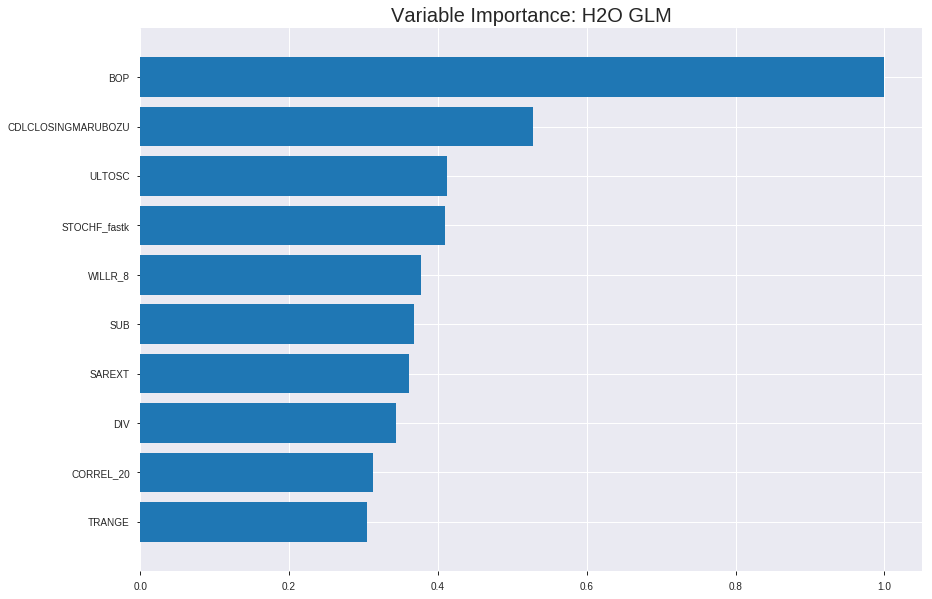

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_043254_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1798463679033682
RMSE: 0.4240829728996063
LogLoss: 0.5359819605569718
Null degrees of freedom: 1557
Residual degrees of freedom: 519
Null deviance: 2159.7541875235074
Residual deviance: 1670.119789095524
AIC: 3748.119789095524
AUC: 0.8098985670849779
pr_auc: 0.8075554734766686
Gini: 0.6197971341699557
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43649324826384417: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      482  291  0.3765   (291.0/773.0)
1      133  652  0.1694   (133.0/785.0)
Total  615  943  0.2721   (424.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436493     0.75463   229
max f2                       0.191023     0.85522   340
max f0point5                 0.553589     0.748954  173
max accuracy                 0.489325     0.737484  205
max precision                0.961264     1         0
max recall                   0.0375846    1         395
max specificity              0.961264     1         0
max absolute_mcc             0.489325     0.475999  205
max min_per_class_accuracy   0.51721      0.730918  191
max mean_per_class_accuracy  0.489325     0.737177  205

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.924909           1.86067   1.86067            0.9375           0.937851  0.9375                      0.937851            0.0191083       0.0191083                  86.0669   86.0669
    2        0.0205392                   0.903134           1.98471   1.92269            1                0.916137  0.96875                     0.926994            0.0203822       0.0394904                  98.4713   92.2691
    3        0.0301669                   0.886553           1.8524    1.90026            0.933333         0.89498   0.957447                    0.916777            0.0178344       0.0573248                  85.2399   90.0257
    4        0.0404365                   0.874832           1.86067   1.8902             0.9375           0.881322  0.952381                    0.907772            0.0191083       0.0764331                  86.0669   89.0203
    5        0.0500642                   0.864219           1.8524    1.88293            0.933333         0.869585  0.948718                    0.900429            0.0178344       0.0942675                  85.2399   88.2933
    6        0.100128                    0.800594           1.8066    1.84477            0.910256         0.833175  0.929487                    0.866802            0.0904459       0.184713                   80.6598   84.4766
    7        0.150193                    0.75458            1.65393   1.78115            0.833333         0.775671  0.897436                    0.836425            0.0828025       0.267516                   65.3928   78.1153
    8        0.200257                    0.714426           1.55215   1.7239             0.782051         0.735356  0.86859                     0.811158            0.077707        0.345223                   55.2148   72.3902
    9        0.300385                    0.649794           1.43764   1.62848            0.724359         0.681903  0.820513                    0.768073            0.143949        0.489172                   43.7645   62.8483
    10       0.399872                    0.586656           1.30607   1.54827            0.658065         0.619615  0.780096                    0.731137            0.129936        0.619108                   30.6069   54.8268
    11       0.5                         0.51749            1.11958   1.46242            0.564103         0.551829  0.736842                    0.695229            0.112102        0.73121                    11.9582   46.242
    12       0.600128                    0.439488           0.928744  1.37338            0.467949         0.481084  0.691979                    0.6595              0.0929936       0.824204                   -7.12559  37.3379
    13       0.699615                    0.366979           0.653035  1.27094            0.329032         0.403239  0.640367                    0.62306             0.0649682       0.889172                   -34.6965  27.0945
    14       0.799743                    0.290605           0.597959  1.18669            0.301282         0.327208  0.597913                    0.586019            0.0598726       0.949045                   -40.2041  18.6687
    15       0.899872                    0.178893           0.394398  1.09853            0.198718         0.240484  0.553495                    0.547571            0.0394904       0.988535                   -60.5602  9.85289
    16       1                           0.00598418         0.114503  1                  0.0576923        0.110931  0.503851                    0.503851          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1980626657206966
RMSE: 0.4450423190222438
LogLoss: 0.5779488165913447
Null degrees of freedom: 445
Residual degrees of freedom: -593
Null deviance: 617.9132227761654
Residual deviance: 515.5303443994793
AIC: 2593.5303443994794
AUC: 0.7611884584342211
pr_auc: 0.7589707142975303
Gini: 0.5223769168684422
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3959341141975761: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  95   0.4524   (95.0/210.0)
1      37   199  0.1568   (37.0/236.0)
Total  152  294  0.296    (132.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395934     0.750943  263
max f2                       0.112353     0.86701   373
max f0point5                 0.458003     0.72205   234
max accuracy                 0.458003     0.715247  234
max precision                0.951527     1         0
max recall                   0.112353     1         373
max specificity              0.951527     1         0
max absolute_mcc             0.458003     0.427689  234
max min_per_class_accuracy   0.505982     0.7       204
max mean_per_class_accuracy  0.458003     0.710734  234

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.920158           1.88983   1.88983            1                0.936173   1                           0.936173            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.895114           1.88983   1.88983            1                0.903981   1                           0.921866            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.878042           1.88983   1.88983            1                0.886277   1                           0.909155            0.0211864       0.059322                   88.9831   88.9831
    4        0.0403587                   0.869473           0.944915  1.67985            0.5              0.874721   0.888889                    0.901503            0.00847458      0.0677966                  -5.50847  67.9849
    5        0.0515695                   0.855467           1.51186   1.64333            0.8              0.86299    0.869565                    0.893131            0.0169492       0.0847458                  51.1864   64.3331
    6        0.100897                    0.782945           1.46032   1.55386            0.772727         0.8153     0.822222                    0.85508             0.0720339       0.15678                    46.0324   55.3861
    7        0.150224                    0.749754           1.37442   1.49494            0.727273         0.766065   0.791045                    0.825851            0.0677966       0.224576                   37.4422   49.4941
    8        0.201794                    0.717158           1.7255    1.55386            0.913043         0.736311   0.822222                    0.802969            0.0889831       0.313559                   72.5497   55.3861
    9        0.300448                    0.649236           1.41737   1.50904            0.75             0.677543   0.798507                    0.761784            0.139831        0.45339                    41.7373   50.9044
    10       0.401345                    0.587244           1.21789   1.43585            0.644444         0.61884    0.759777                    0.725848            0.122881        0.576271                   21.7891   43.5849
    11       0.5                         0.512248           1.03082   1.35593            0.545455         0.560633   0.717489                    0.69325             0.101695        0.677966                   3.08166   35.5932
    12       0.600897                    0.447176           1.0919    1.3116             0.577778         0.485615   0.69403                     0.658386            0.110169        0.788136                   9.19021   31.1599
    13       0.699552                    0.361823           0.687211  1.22354            0.363636         0.4033     0.647436                    0.622412            0.0677966       0.855932                   -31.2789  22.3544
    14       0.800448                    0.293164           0.545951  1.13813            0.288889         0.327278   0.602241                    0.58521             0.0550847       0.911017                   -45.4049  13.8133
    15       0.899103                    0.174377           0.730162  1.09337            0.386364         0.237073   0.578554                    0.547011            0.0720339       0.983051                   -26.9838  9.33683
    16       1                           0.00531438         0.167985  1                  0.0888889        0.0954628  0.529148                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 04:32:57  0.000 sec   2            .2E2      1025          1.358470504121649   1.3624263467554536
     2019-09-03 04:32:59  1.878 sec   4            .15E2     1032          1.350821031192809   1.355778665548852
     2019-09-03 04:33:01  3.706 sec   6            .11E2     1033          1.3413951846122258  1.347466900922871
     2019-09-03 04:33:03  5.645 sec   8            .78E1     1037          1.329957500228998   1.3372984332523263
     2019-09-03 04:33:04  7.412 sec   10           .57E1     1039          1.3163106802729247  1.3251383642188352
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 04:33:32  34.985 sec  40           .49E-1    1039          1.0621993211660266  1.156752168535688
     2019-09-03 04:33:34  36.824 sec  42           .35E-1    1039          1.0532389543773553  1.159317698970093
     2019-09-03 04:33:36  38.655 sec  44           .26E-1    1039          1.0449392556908674  1.1635959091427068
     2019-09-03 04:33:37  40.515 sec  46           .19E-1    1039          1.0371737545647783  1.1694670081157648
     2019-09-03 04:33:39  42.348 sec  48           .14E-1    1039          1.0298054198882796  1.1766874758854609


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7286821705426357)

('auc', 0.7795750845002414)

('logloss', 0.5641494061265272)

('mean_per_class_error', 0.27060196362465794)

('rmse', 0.4363579488037067)

('mse', 0.1904082594841783)

glm prediction progress: |████████████████████████████████████████████████| 100%


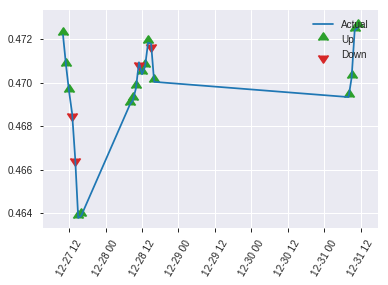


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1904082594841783
RMSE: 0.4363579488037067
LogLoss: 0.5641494061265272
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 309.23389543359224
Residual deviance: 251.6106351324311
AIC: 2329.610635132431
AUC: 0.7795750845002414
pr_auc: 0.7618689083471575
Gini: 0.5591501690004828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36606768203194023: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   55   0.4825   (55.0/114.0)
1      15   94   0.1376   (15.0/109.0)
Total  74   149  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366068     0.728682  148
max f2                       0.122003     0.834609  216
max f0point5                 0.639345     0.755668  71
max accuracy                 0.547726     0.730942  94
max precision                0.938444     1         0
max recall                   0.122003     1         216
max specificity              0.938444     1         0
max absolute_mcc             0.639345     0.47595   71
max min_per_class_accuracy   0.478574     0.715596  107
max mean_per_class_accuracy  0.547726     0.729398  94

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.924476           2.04587   2.04587            1                0.933928  1                           0.933928            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.903027           1.02294   1.6367             0.5              0.907141  0.8                         0.923213            0.00917431      0.0366972                  2.29358   63.6697
    3        0.0313901                   0.895068           2.04587   1.7536             1                0.897647  0.857143                    0.915908            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.881953           2.04587   1.81855            1                0.892386  0.888889                    0.910681            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.875825           2.04587   1.87538            1                0.877926  0.916667                    0.902492            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.821903           1.67389   1.77902            0.818182         0.847158  0.869565                    0.876028            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.775384           1.67389   1.74501            0.818182         0.788375  0.852941                    0.84767             0.0825688       0.266055                   67.3895   74.5008
    8        0.201794                    0.748073           1.48791   1.68216            0.727273         0.759258  0.822222                    0.826058            0.0733945       0.33945                    48.7907   68.2161
    9        0.300448                    0.652621           1.67389   1.67945            0.818182         0.700454  0.820896                    0.784815            0.165138        0.504587                   67.3895   67.9447
    10       0.399103                    0.576944           1.20892   1.56314            0.590909         0.618607  0.764045                    0.74373             0.119266        0.623853                   20.8924   56.3138
    11       0.502242                    0.471258           0.889509  1.4248             0.434783         0.52001   0.696429                    0.697787            0.0917431       0.715596                   -11.0491  42.4803
    12       0.600897                    0.423197           0.929942  1.34356            0.454545         0.444224  0.656716                    0.656157            0.0917431       0.807339                   -7.00584  34.3557
    13       0.699552                    0.343218           0.650959  1.24588            0.318182         0.374267  0.608974                    0.616404            0.0642202       0.87156                    -34.9041  24.5883
    14       0.798206                    0.286818           0.650959  1.17235            0.318182         0.320483  0.573034                    0.579829            0.0642202       0.93578                    -34.9041  17.2353
    15       0.896861                    0.178408           0.185988  1.06385            0.0909091        0.22513   0.52                        0.540812            0.0183486       0.954128                   -81.4012  6.38532
    16       1                           0.0337524          0.444755  1                  0.217391         0.133034  0.488789                    0.498754         

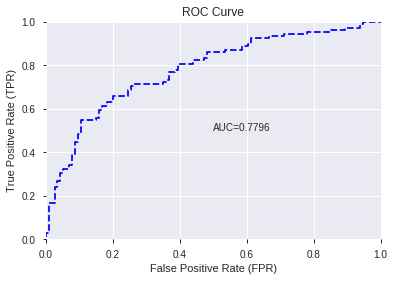

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


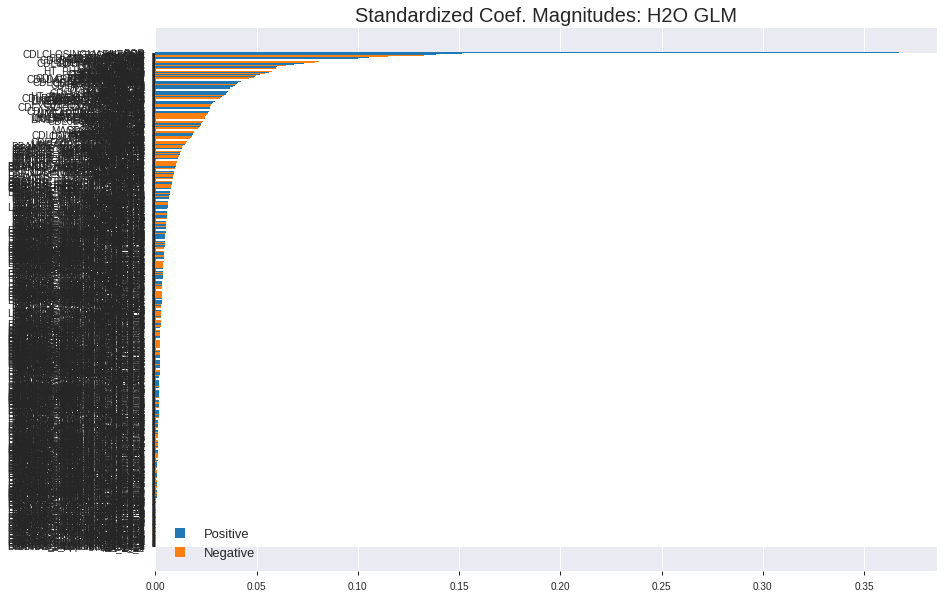

'log_likelihood'
--2019-09-03 04:34:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_043254_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_043254_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

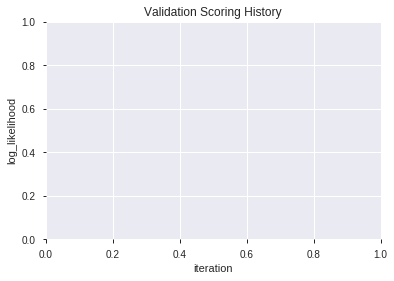

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_043408_model_6  0.781265  0.574792              0.312611  0.443128  0.196363
1               XGBoost_2_AutoML_20190903_043408  0.777885  0.571795              0.274746  0.442518  0.195822
2  XGBoost_grid_1_AutoML_20190903_043408_model_2  0.777724  0.579843              0.296073  0.444873  0.197912
3  XGBoost_grid_1_AutoML_20190903_043408_model_7  0.776517  0.579160              0.301263  0.446067  0.198976
4  XGBoost_grid_1_AutoML_20190903_043408_model_3  0.775471  0.571587              0.279736  0.440713  0.194228
5               XGBoost_3_AutoML_20190903_043408  0.772413  0.577436              0.287502  0.444650  0.197713
6  XGBoost_grid_1_AutoML_20190903_043408_model_4  0.772010  0.584479              0.287502  0.447120  0.199916
7  XGBoost_grid_1_AutoML_20190903_043408_model_1  0.772010  0.579024              0.279736  0.444350  0.197447
8               XGBoost_1_AutoML_20190903_043408  0.761226  0.583514              0.283518  0.446476  0.199341
9  XGBoost_grid_1_AutoML_20190903_043408_model_5  0.750282  0.603834              0.347497  0.455074  0.207093

variable  relative_importance  scaled_importance  percentage
0                        BOP          1668.474854           1.000000    0.163922
1                     TRANGE           584.183228           0.350130    0.057394
2             STOCHRSI_fastk           235.121033           0.140920    0.023100
3                        DIV           216.911240           0.130006    0.021311
4               STOCHF_fastk           206.497101           0.123764    0.020288
..                       ...                  ...                ...         ...
326  BBANDS_lowerband_14_5_2             3.118444           0.001869    0.000306
327                  MACDEXT             3.009245           0.001804    0.000296
328  BBANDS_upperband_20_3_4             2.634055           0.001579    0.000259
329   BBANDS_lowerband_8_1_5             2.373965           0.001423    0.000233
330  BBANDS_lowerband_20_0_5             2.319019           0.001390    0.000228

[331 rows x 4 columns]

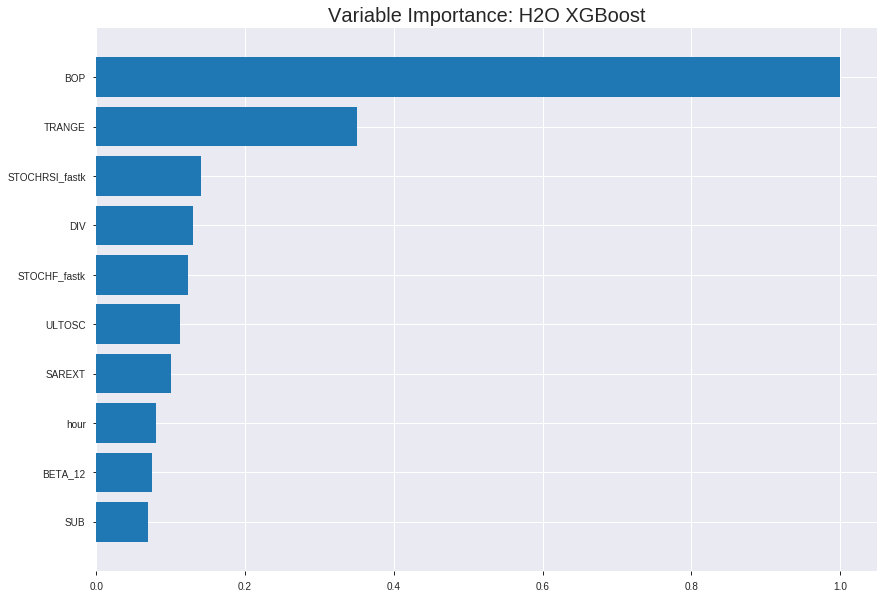

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_043408_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11833318816893583
RMSE: 0.34399591301196564
LogLoss: 0.39946601822290545
Mean Per-Class Error: 0.11926236599896178
AUC: 0.9529181532782359
pr_auc: 0.9551118593318991
Gini: 0.9058363065564718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.495884008705616: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      656  117  0.1514   (117.0/773.0)
1      71   714  0.0904   (71.0/785.0)
Total  727  831  0.1207   (188.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495884     0.883663  198
max f2                       0.403826     0.924176  241
max f0point5                 0.622079     0.901716  142
max accuracy                 0.533645     0.880616  181
max precision                0.910666     1         0
max recall                   0.198194     1         339
max specificity              0.910666     1         0
max absolute_mcc             0.533645     0.761704  181
max min_per_class_accuracy   0.523413     0.876433  186
max mean_per_class_accuracy  0.533645     0.880738  181

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.882082           1.98471    1.98471            1                0.895353  1                           0.895353            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.86985            1.98471    1.98471            1                0.875751  1                           0.885552            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.855435           1.98471    1.98471            1                0.862614  1                           0.878231            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.848158           1.98471    1.98471            1                0.852001  1                           0.87157             0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.840123           1.98471    1.98471            1                0.844243  1                           0.866315            0.0191083       0.0993631                  98.4713   98.4713
    6        0.100128                    0.815755           1.98471    1.98471            1                0.827831  1                           0.847073            0.0993631       0.198726                   98.4713   98.4713
    7        0.150193                    0.785313           1.98471    1.98471            1                0.801169  1                           0.831772            0.0993631       0.298089                   98.4713   98.4713
    8        0.200257                    0.750966           1.93382    1.97199            0.974359         0.767073  0.99359                     0.815597            0.0968153       0.394904                   93.3823   97.1991
    9        0.300385                    0.682845           1.90838    1.95079            0.961538         0.717682  0.982906                    0.782959            0.191083        0.585987                   90.8378   95.0787
    10       0.399872                    0.609915           1.6646     1.87958            0.83871          0.649555  0.94703                     0.749769            0.165605        0.751592                   66.4598   87.9584
    11       0.5                         0.523736           1.22136    1.74777            0.615385         0.567835  0.880616                    0.713335            0.122293        0.873885                   22.1362   74.7771
    12       0.600128                    0.438772           0.737906   1.57928            0.371795         0.480875  0.795722                    0.67455             0.0738854       0.947771                   -26.2094  57.928
    13       0.699615                    0.324285           0.30731    1.3984             0.154839         0.383373  0.704587                    0.633144            0.0305732       0.978344                   -69.269   39.8404
    14       0.799743                    0.247573           0.15267    1.24244            0.0769231        0.283188  0.626003                    0.58933             0.0152866       0.993631                   -84.733   24.2437
    15       0.899872                    0.160483           0.0636126  1.11127            0.0320513        0.20415   0.559914                    0.546471            0.00636943      1                          -93.6387  11.127
    16       1                           0.0571803          0          1                  0                0.116633  0.503851                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20599923132565023
RMSE: 0.45387138191964715
LogLoss: 0.6003358937626612
Mean Per-Class Error: 0.2932001614205004
AUC: 0.749041565778854
pr_auc: 0.7152020902200006
Gini: 0.4980831315577079
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3587324619293213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  93   0.4429   (93.0/210.0)
1      34   202  0.1441   (34.0/236.0)
Total  151  295  0.2848   (127.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358732     0.760829  265
max f2                       0.190374     0.860902  346
max f0point5                 0.482198     0.726534  198
max accuracy                 0.364641     0.715247  263
max precision                0.899215     1         0
max recall                   0.0946119    1         398
max specificity              0.899215     1         0
max absolute_mcc             0.358732     0.435708  265
max min_per_class_accuracy   0.472377     0.699153  206
max mean_per_class_accuracy  0.364641     0.7068    263

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 46.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.854285           1.1339    1.1339             0.6              0.878365  0.6                         0.878365            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.83768            1.41737   1.25989            0.75             0.845855  0.666667                    0.863916            0.0127119       0.0254237                  41.7373   25.9887
    3        0.0313901                   0.821859           1.88983   1.48487            1                0.829305  0.785714                    0.851555            0.0211864       0.0466102                  88.9831   48.4867
    4        0.0403587                   0.815095           1.41737   1.46987            0.75             0.819226  0.777778                    0.844371            0.0127119       0.059322                   41.7373   46.9868
    5        0.0515695                   0.800046           0.755932  1.31466            0.4              0.806528  0.695652                    0.836144            0.00847458      0.0677966                  -24.4068  31.4665
    6        0.100897                    0.755666           1.37442   1.34388            0.727273         0.777223  0.711111                    0.807339            0.0677966       0.135593                   37.4422   34.3879
    7        0.150224                    0.715245           1.54622   1.41032            0.818182         0.731012  0.746269                    0.782276            0.0762712       0.211864                   54.6225   41.0321
    8        0.201794                    0.688857           1.39683   1.40687            0.73913          0.700773  0.744444                    0.761448            0.0720339       0.283898                   39.6831   40.6874
    9        0.300448                    0.623492           1.41737   1.41032            0.75             0.655819  0.746269                    0.726764            0.139831        0.423729                   41.7373   41.0321
    10       0.401345                    0.561522           1.30188   1.38306            0.688889         0.585891  0.731844                    0.691349            0.131356        0.555085                   30.1883   38.306
    11       0.5                         0.476267           1.37442   1.38136            0.727273         0.518324  0.730942                    0.657209            0.135593        0.690678                   37.4422   38.1356
    12       0.600897                    0.396962           0.923917  1.30455            0.488889         0.43604   0.690299                    0.620073            0.0932203       0.783898                   -7.60829  30.4547
    13       0.699552                    0.314008           0.901965  1.24777            0.477273         0.359737  0.660256                    0.583359            0.0889831       0.872881                   -9.80354  24.7773
    14       0.800448                    0.235199           0.587947  1.1646             0.311111         0.274135  0.616246                    0.544381            0.059322        0.932203                   -41.2053  16.4601
    15       0.899103                    0.169948           0.472458  1.08866            0.25             0.198243  0.57606                     0.506401            0.0466102       0.978814                   -52.7542  8.86555
    16       1                           0.088932           0.209981  1                  0.111111         0.133698  0.529148                    0.468796          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:34:52  28.359 sec  0                  0.5              0.693147            0.5             0                  1                0.496149                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 04:34:53  29.467 sec  5                  0.469077         0.632804            0.857955        0.829027           1.98471          0.225289                         0.481339           0.656271              0.729691          0.68921              1.34988            0.293722
    2019-09-03 04:34:54  29.696 sec  10                 0.444396         0.586067            0.880798        0.875761           1.98471          0.196406                         0.467871           0.629815              0.746509          0.700033             1.1339             0.295964
    2019-09-03 04:34:54  29.909 sec  15                 0.424826         0.549176            0.89492         0.893243           1.98471          0.180359                         0.461109           0.615975              0.744734          0.695266             1.1339             0.295964
    2019-09-03 04:34:54  30.127 sec  20                 0.408522         0.518406            0.904042        0.902288           1.98471          0.17715                          0.455452           0.604345              0.748517          0.704708             1.51186            0.269058
    2019-09-03 04:34:54  30.345 sec  25                 0.395002         0.49301             0.91365         0.91494            1.98471          0.174583                         0.4536             0.600229              0.750767          0.707649             1.51186            0.278027
    2019-09-03 04:34:55  30.555 sec  30                 0.384429         0.472906            0.921635        0.921821           1.98471          0.171374                         0.45331            0.599337              0.7489            0.70395              1.51186            0.278027
    2019-09-03 04:34:55  30.856 sec  35                 0.374977         0.455378            0.929387        0.931152           1.98471          0.161104                         0.453547           0.599518              0.750131          0.709007             1.51186            0.282511
    2019-09-03 04:34:55  31.081 sec  40                 0.365853         0.438578            0.936762        0.938624           1.98471          0.147625                         0.452394           0.597237              0.752885          0.71674              1.1339             0.273543
    2019-09-03 04:34:55  31.290 sec  45                 0.359435         0.426316            0.940485        0.943217           1.98471          0.133504                         0.451418           0.595644              0.754046          0.718401             1.1339             0.275785
    2019-09-03 04:34:56  31.514 sec  50                 0.350424         0.410429            0.948168        0.9495             1.98471          0.126444                         0.452683           0.597988              0.751695          0.717417             1.1339             0.289238
    2019-09-03 04:34:56  31.729 sec  55                 0.343996         0.399466            0.952918        0.955112           1.98471          0.120668                         0.453871           0.600336              0.749042          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1668.474853515625      1.0                    0.16392233849409935
TRANGE                   584.1832275390625      0.35013007616395087    0.057394140861911934
STOCHRSI_fastk           235.12103271484375     0.14091973410292807    0.02309989235411865
DIV                      216.91123962402344     0.13000569901726247    0.0213108382004697
STOCHF_fastk             206.49710083007812     0.12376398744935853    0.020287682244053213
---                      ---                    ---                    ---
BBANDS_lowerband_14_5_2  3.1184444427490234     0.0018690389226892951  0.00030637723094372143
MACDEXT                  3.009244918823242      0.00180359021442996    0.0002956487256344331
BBANDS_upperband_20_3_4  2.634054660797119      0.0015787200240069137  0.0002587874781626739
BBANDS_lowerband_8_1_5   2.37396502494812       0.0014228353636531977  0.00023323450010213442
BBANDS_lowerband_20_0_5  2.319018602371216      0.0013899032385683472  0.0002278361891466455


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7436823104693141)

('auc', 0.7812650893288267)

('logloss', 0.5747923404398376)

('mean_per_class_error', 0.27615483663286655)

('rmse', 0.4431283229599785)

('mse', 0.196362710609323)

xgboost prediction progress: |████████████████████████████████████████████| 100%


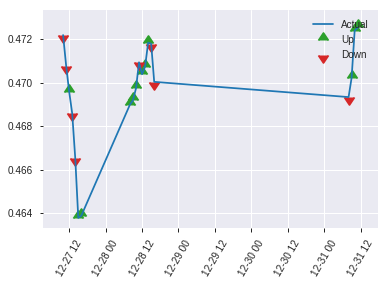


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.196362710609323
RMSE: 0.4431283229599785
LogLoss: 0.5747923404398376
Mean Per-Class Error: 0.27615483663286655
AUC: 0.7812650893288267
pr_auc: 0.7451540980510767
Gini: 0.5625301786576533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22137176990509033: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   65   0.5702   (65.0/114.0)
1      6    103  0.055    (6.0/109.0)
Total  55   168  0.3184   (71.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.221372     0.743682  167
max f2                       0.203294     0.853659  178
max f0point5                 0.542555     0.71116   86
max accuracy                 0.332862     0.721973  128
max precision                0.869365     1         0
max recall                   0.12678      1         213
max specificity              0.869365     1         0
max absolute_mcc             0.332862     0.453194  128
max min_per_class_accuracy   0.4072       0.688073  107
max mean_per_class_accuracy  0.332862     0.723845  128

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.850113           1.36391   1.36391            0.666667         0.858028  0.666667                    0.858028            0.0183486       0.0183486                  36.3914   36.3914
    2        0.0224215                   0.841734           2.04587   1.6367             1                0.84618   0.8                         0.853289            0.0183486       0.0366972                  104.587   63.6697
    3        0.0313901                   0.830199           2.04587   1.7536             1                0.835956  0.857143                    0.848336            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.818263           2.04587   1.81855            1                0.82395   0.888889                    0.842917            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.799366           2.04587   1.87538            1                0.810429  0.916667                    0.834795            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.744588           1.67389   1.77902            0.818182         0.764963  0.869565                    0.801397            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.720378           1.67389   1.74501            0.818182         0.728767  0.852941                    0.777899            0.0825688       0.266055                   67.3895   74.5008
    8        0.201794                    0.674957           1.30192   1.6367             0.636364         0.697609  0.8                         0.758273            0.0642202       0.330275                   30.1918   63.6697
    9        0.300448                    0.606812           1.39491   1.55731            0.681818         0.642987  0.761194                    0.720418            0.137615        0.46789                    39.4912   55.7305
    10       0.399103                    0.540089           1.30192   1.49418            0.636364         0.57432   0.730337                    0.684304            0.12844         0.59633                    30.1918   49.4176
    11       0.502242                    0.39537            0.889509  1.37               0.434783         0.456785  0.669643                    0.637581            0.0917431       0.688073                   -11.0491  37.0003
    12       0.600897                    0.315896           1.30192   1.35883            0.636364         0.353258  0.664179                    0.590901            0.12844         0.816514                   30.1918   35.8825
    13       0.699552                    0.254775           0.743953  1.27211            0.363636         0.28775   0.621795                    0.548149            0.0733945       0.889908                   -25.6047  27.2112
    14       0.798206                    0.203537           0.650959  1.19534            0.318182         0.227132  0.58427                     0.508473            0.0642202       0.954128                   -34.9041  19.5341
    15       0.896861                    0.160109           0.185988  1.08431            0.0909091        0.182111  0.53                        0.472573            0.0183486       0.972477                   -81.4012  8.43119
    16       1                           0.102592           0.266853  1                  0.130435         0.132195  0.488789                    0.437467         

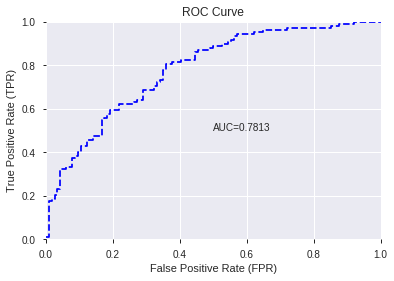

This function is available for GLM models only


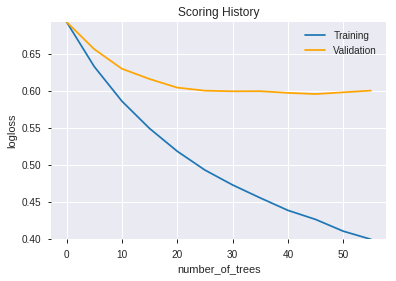

--2019-09-03 04:35:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_043408_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_043408_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_043510_model_6  0.774586  0.569871              0.330758  0.441484  0.194908
1  DeepLearning_grid_1_AutoML_20190903_043510_model_9  0.774344  0.578825              0.335748  0.444840  0.197883
2  DeepLearning_grid_1_AutoML_20190903_043510_model_8  0.769998  0.569285              0.289313  0.441230  0.194684
3  DeepLearning_grid_1_AutoML_20190903_043510_model_7  0.765653  0.730765              0.306052  0.481698  0.232033
4  DeepLearning_grid_1_AutoML_20190903_043510_model_5  0.762112  0.601381              0.290117  0.454440  0.206516
5  DeepLearning_grid_1_AutoML_20190903_043510_model_3  0.757122  0.659339              0.331563  0.465534  0.216722
6               DeepLearning_1_AutoML_20190903_043510  0.755674  0.605166              0.348302  0.456081  0.208010
7  DeepLearning_grid_1_AutoML_20190903_043510_model_1  0.751086  0.788183              0.340737  0.490024  0.240123
8  DeepLearning_grid_1_AutoML_20190903_043510_model_4  0.745212  0.811888              0.271970  0.497461  0.247468
9  DeepLearning_grid_1_AutoML_20190903_043510_model_2  0.729760  0.726670              0.353895  0.481524  0.231865

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.031981
1     CDLCLOSINGMARUBOZU             0.744172           0.744172    0.023799
2                    DIV             0.720119           0.720119    0.023030
3                 TRANGE             0.712130           0.712130    0.022774
4           CDLSHORTLINE             0.692615           0.692615    0.022150
5                    SUB             0.683803           0.683803    0.021869
6       CDLDRAGONFLYDOJI             0.669954           0.669954    0.021426
7                 SAREXT             0.663832           0.663832    0.021230
8                WILLR_8             0.660213           0.660213    0.021114
9           HT_TRENDMODE             0.659231           0.659231    0.021083
10          STOCHF_fastk             0.656261           0.656261    0.020988
11         CDLHANGINGMAN             0.647018           0.647018    0.020692
12          CDLENGULFING             0.643841           0.643841    0.020591
13                 ADOSC             0.634903           0.634903    0.020305
14                  hour             0.633914           0.633914    0.020273
15             PLUS_DI_8             0.631655           0.631655    0.020201
16             CORREL_24             0.625285           0.625285    0.019997
17           CDLLONGLINE             0.622775           0.622775    0.019917
18                ULTOSC             0.620292           0.620292    0.019837
19             CORREL_20             0.617608           0.617608    0.019752
20            AROONOSC_8             0.616424           0.616424    0.019714
21           CDLMARUBOZU             0.614744           0.614744    0.019660
22             CDLTAKURI             0.613480           0.613480    0.019620
23               weekday             0.612540           0.612540    0.019589
24             aroonup_8             0.611617           0.611617    0.019560
25             dayofweek             0.611118           0.611118    0.019544
26               BETA_14             0.606650           0.606650    0.019401
27               BETA_30             0.604548           0.604548    0.019334
28          aroondown_12             0.602864           0.602864    0.019280
29        STOCHRSI_fastd             0.601053           0.601053    0.019222
30              WILLR_20             0.598382           0.598382    0.019137
31            aroonup_24             0.598312           0.598312    0.019134
32              WILLR_30             0.595485           0.595485    0.019044
33  HT_PHASOR_quadrature             0.595142           0.595142    0.019033
34        STOCHRSI_fastk             0.588939           0.588939    0.018835
35            aroonup_30             0.588913           0.588913    0.018834
36          STOCHF_fastd             0.586863           0.586863    0.018768
37                 CMO_8             0.585528           0.585528    0.018726
38           AROONOSC_12             0.585515           0.585515    0.018725
39              WILLR_12             0.585333           0.585333    0.018719
40           CDLBELTHOLD             0.584233           0.584233    0.018684
41          weekday_name             0.583435           0.583435    0.018659
42           STOCH_slowd             0.581399           0.581399    0.018594
43                MFI_12             0.577117           0.577117    0.018457
44                 RSI_8             0.576100           0.576100    0.018424
45           STOCH_slowk             0.573767           0.573767    0.018350
46           aroondown_8             0.565961           0.565961    0.018100
47              WILLR_24             0.564592           0.564592    0.018056
48                 MFI_8             0.563739           0.563739    0.018029
49              WILLR_14             0.555406           0.555406    0.017762

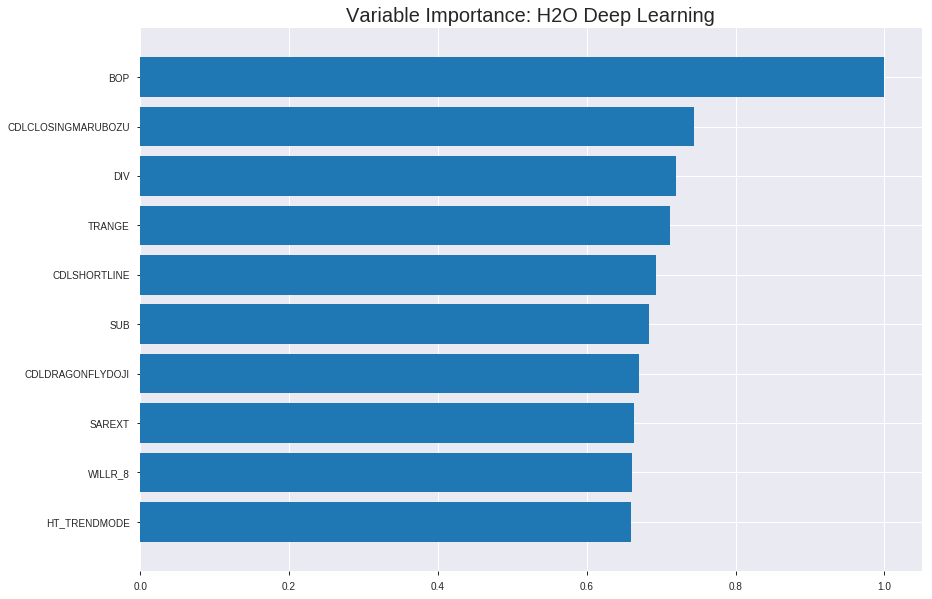

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_043510_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18496837434046456
RMSE: 0.43007949769834947
LogLoss: 0.5462023567601615
Mean Per-Class Error: 0.2698436894883859
AUC: 0.7946028790138512
pr_auc: 0.7902770254070781
Gini: 0.5892057580277024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31971296828119994: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      329  444   0.5744   (444.0/773.0)
1      70   715   0.0892   (70.0/785.0)
Total  399  1159  0.3299   (514.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319713     0.735597  288
max f2                       0.175189     0.854521  345
max f0point5                 0.512854     0.741203  193
max accuracy                 0.512854     0.729782  193
max precision                0.993415     1         0
max recall                   0.0505807    1         387
max specificity              0.993415     1         0
max absolute_mcc             0.512854     0.462333  193
max min_per_class_accuracy   0.486        0.71465   207
max mean_per_class_accuracy  0.512854     0.730156  193

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.975031           1.86067   1.86067            0.9375           0.987396   0.9375                      0.987396            0.0191083       0.0191083                  86.0669   86.0669
    2        0.0205392                   0.964781           1.86067   1.86067            0.9375           0.968537   0.9375                      0.977966            0.0191083       0.0382166                  86.0669   86.0669
    3        0.0301669                   0.951498           1.98471   1.90026            1                0.960073   0.957447                    0.972256            0.0191083       0.0573248                  98.4713   90.0257
    4        0.0404365                   0.934473           1.86067   1.8902             0.9375           0.943512   0.952381                    0.964956            0.0191083       0.0764331                  86.0669   89.0203
    5        0.0500642                   0.917472           1.8524    1.88293            0.933333         0.927816   0.948718                    0.957813            0.0178344       0.0942675                  85.2399   88.2933
    6        0.100128                    0.858065           1.83204   1.85749            0.923077         0.886439   0.935897                    0.922126            0.0917197       0.185987                   83.2043   85.7488
    7        0.150193                    0.79765            1.60304   1.77267            0.807692         0.828766   0.893162                    0.891006            0.0802548       0.266242                   60.3038   77.2671
    8        0.200257                    0.730463           1.47581   1.69846            0.74359          0.764568   0.855769                    0.859397            0.0738854       0.340127                   47.5813   69.8457
    9        0.300385                    0.626506           1.43764   1.61152            0.724359         0.672157   0.811966                    0.796984            0.143949        0.484076                   43.7645   61.1519
    10       0.399872                    0.54823            1.28046   1.52915            0.645161         0.587858   0.770465                    0.744954            0.127389        0.611465                   28.046    52.9153
    11       0.5                         0.484729           1.04325   1.43185            0.525641         0.515853   0.721438                    0.699075            0.104459        0.715924                   4.32468   43.1847
    12       0.600128                    0.420341           0.890577  1.34154            0.448718         0.453003   0.675936                    0.658019            0.089172        0.805096                   -10.9423  34.1539
    13       0.699615                    0.350068           0.704253  1.25092            0.354839         0.383104   0.630275                    0.618926            0.0700637       0.875159                   -29.5747  25.0916
    14       0.799743                    0.274297           0.674294  1.17872            0.339744         0.315132   0.5939                      0.58089             0.0675159       0.942675                   -32.5706  17.8722
    15       0.899872                    0.158556           0.432566  1.0957             0.217949         0.219249   0.552068                    0.540651            0.0433121       0.985987                   -56.7434  9.56977
    16       1                           0.0144911          0.139948  1                  0.0705128        0.0878153  0.503851                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2105144626774072
RMSE: 0.45881855092989343
LogLoss: 0.6125484716665255
Mean Per-Class Error: 0.3110169491525424
AUC: 0.74227199354318
pr_auc: 0.7376563887363347
Gini: 0.48454398708635993
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3504453109767659: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  106  0.5048   (106.0/210.0)
1      31   205  0.1314   (31.0/236.0)
Total  135  311  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350445     0.749543  278
max f2                       0.129955     0.864382  355
max f0point5                 0.494485     0.711462  174
max accuracy                 0.350445     0.692825  278
max precision                0.989994     1         0
max recall                   0.0236594    1         397
max specificity              0.989994     1         0
max absolute_mcc             0.350445     0.395348  278
max min_per_class_accuracy   0.458015     0.677966  201
max mean_per_class_accuracy  0.458015     0.688983  201

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 47.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.979004           1.88983   1.88983            1                0.98266    1                           0.98266             0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.963129           1.88983   1.88983            1                0.971426   1                           0.977667            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.950579           1.1339    1.61985            0.6              0.957268   0.857143                    0.970381            0.0127119       0.0508475                  13.3898   61.9855
    4        0.0403587                   0.945649           1.88983   1.67985            1                0.948055   0.888889                    0.96542             0.0169492       0.0677966                  88.9831   67.9849
    5        0.0515695                   0.935369           1.88983   1.7255             1                0.940033   0.913043                    0.959901            0.0211864       0.0889831                  88.9831   72.5497
    6        0.100897                    0.845837           1.11672   1.42787            0.590909         0.883482   0.755556                    0.92254             0.0550847       0.144068                   11.6718   42.7872
    7        0.150224                    0.766278           1.46032   1.43853            0.772727         0.80556    0.761194                    0.884129            0.0720339       0.216102                   46.0324   43.8528
    8        0.201794                    0.709584           1.479     1.44887            0.782609         0.740978   0.766667                    0.847546            0.0762712       0.292373                   47.8998   44.887
    9        0.300448                    0.610227           1.41737   1.43853            0.75             0.662571   0.761194                    0.786808            0.139831        0.432203                   41.7373   43.8528
    10       0.401345                    0.51437            1.17589   1.3725             0.622222         0.554899   0.726257                    0.728507            0.118644        0.550847                   17.5895   37.2503
    11       0.5                         0.457751           1.28852   1.35593            0.681818         0.486564   0.717489                    0.680769            0.127119        0.677966                   28.8521   35.5932
    12       0.600897                    0.409847           0.755932  1.25519            0.4              0.435706   0.664179                    0.639621            0.0762712       0.754237                   -24.4068  25.5186
    13       0.699552                    0.348398           1.15967   1.24172            0.613636         0.38116    0.657051                    0.603171            0.114407        0.868644                   15.9669   24.1716
    14       0.800448                    0.253331           0.629944  1.1646             0.333333         0.305855   0.616246                    0.565694            0.0635593       0.932203                   -37.0056  16.4601
    15       0.899103                    0.122728           0.515408  1.09337            0.272727         0.18448    0.578554                    0.523865            0.0508475       0.983051                   -48.4592  9.33683
    16       1                           0.0136786          0.167985  1                  0.0888889        0.0677077  0.529148                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:38:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:38:47  1 min 48.379 sec  1061 obs/sec      1.28755   1             2006       0.519998         0.958911            -0.0816564     0.768576        0.763956           1.86067          0.329268                         0.564226           1.15493               -0.277746        0.745299          0.731027             1.51186            0.295964
    2019-09-03 04:38:52  1 min 53.752 sec  1810 obs/sec      7.86585   6             12255      0.430079         0.546202            0.260083       0.794603        0.790277           1.86067          0.32991                          0.458819           0.612548              0.155071         0.742272          0.737656             1.88983            0.307175
    2019-09-03 04:38:57  1 min 59.014 sec  2461 obs/sec      18.3582   14            28602      0.424329         0.532823            0.279737       0.804858        0.805137           1.98471          0.313222                         0.458206           0.637304              0.157325         0.750928          0.733753             1.88983            0.29148
    2019-09-03 04:39:03  2 min  4.534 sec  2810 obs/sec      30.1772   23            47016      0.413473         0.507695            0.316121       0.824453        0.823987           1.98471          0.279204                         0.456682           0.628311              0.162922         0.751523          0.734353             1.51186            0.304933
    2019-09-03 04:39:08  2 min  9.605 sec  2960 obs/sec      40.6091   31            63269      0.407181         0.495517            0.336774       0.836225        0.835444           1.98471          0.275995                         0.46042            0.638495              0.149162         0.754903          0.734408             1.51186            0.286996
    2019-09-03 04:39:13  2 min 14.949 sec  3103 obs/sec      52.3864   40            81618      0.399246         0.478609            0.362374       0.84849         0.845658           1.98471          0.254172                         0.454036           0.630956              0.172593         0.754833          0.739014             1.88983            0.284753
    2019-09-03 04:39:18  2 min 20.042 sec  3225 obs/sec      64.1399   49            99930      0.389133         0.457195            0.394266       0.861137        0.857248           1.98471          0.257381                         0.460547           0.648793              0.148692         0.750797          0.741228             1.88983            0.293722
    2019-09-03 04:39:19  2 min 20.476 sec  3223 obs/sec      64.1399   49            99930      0.430079         0.546202            0.260083       0.794603        0.790277           1.86067          0.32991                          0.458819           0.612548              0.155071         0.742272          0.737656             1.88983            0.307175

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.031980737919959326
CDLCLOSINGMARUBOZU  0.744171679019928      0.744171679019928    0.02379915943419241
DIV                 0.7201194763183594     0.7201194763183594   0.023029952243195807
TRANGE              0.7121303677558899     0.7121303677558899   0.022774454656045367
CDLSHORTLINE        0.692615270614624      0.692615270614624    0.022150347448887997
---                 ---                    ---                  ---
STOCH_slowk         0.5737674236297607     0.5737674236297607   0.018349505602113656
aroondown_8         0.5659612417221069     0.5659612417221069   0.01809985814436945
WILLR_24            0.5645918846130371     0.5645918846130371   0.018056065093545456
MFI_8               0.5637387037277222     0.5637387037277222   0.018028779739253882
WILLR_14            0.5554060339927673     0.5554060339927673   0.01776229481228671


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.7272727272727273)

('auc', 0.7745855464348945)

('logloss', 0.5698705754242123)

('mean_per_class_error', 0.296314179945276)

('rmse', 0.4414838503263574)

('mse', 0.19490799009898555)

deeplearning prediction progress: |███████████████████████████████████████| 100%


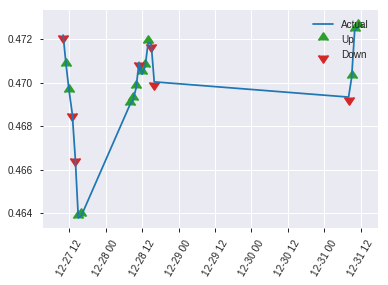


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19490799009898555
RMSE: 0.4414838503263574
LogLoss: 0.5698705754242123
Mean Per-Class Error: 0.296314179945276
AUC: 0.7745855464348945
pr_auc: 0.7622040001056326
Gini: 0.549171092869789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.257621542199065: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   66   0.5789   (66.0/114.0)
1      9    100  0.0826   (9.0/109.0)
Total  57   166  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257622     0.727273  165
max f2                       0.135363     0.84252   198
max f0point5                 0.613735     0.727273  68
max accuracy                 0.613735     0.704036  68
max precision                0.983755     1         0
max recall                   0.0725825    1         213
max specificity              0.983755     1         0
max absolute_mcc             0.613735     0.432259  68
max min_per_class_accuracy   0.43426      0.688073  106
max mean_per_class_accuracy  0.43426      0.703686  106

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 45.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.97683            2.04587   2.04587            1                0.980424   1                           0.980424            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.969509           2.04587   2.04587            1                0.971559   1                           0.976878            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.959258           2.04587   2.04587            1                0.965553   1                           0.973642            0.0183486       0.0642202                  104.587   104.587
    4        0.0403587                   0.941436           2.04587   2.04587            1                0.95146    1                           0.968713            0.0183486       0.0825688                  104.587   104.587
    5        0.0538117                   0.937346           1.36391   1.87538            0.666667         0.939305   0.916667                    0.961361            0.0183486       0.100917                   36.3914   87.5382
    6        0.103139                    0.867197           1.67389   1.77902            0.818182         0.897176   0.869565                    0.930664            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.779104           1.67389   1.74501            0.818182         0.829549   0.852941                    0.89795             0.0825688       0.266055                   67.3895   74.5008
    8        0.201794                    0.697005           1.67389   1.72762            0.818182         0.729247   0.844444                    0.856711            0.0825688       0.348624                   67.3895   72.7625
    9        0.300448                    0.616913           1.48791   1.64891            0.727273         0.658543   0.80597                     0.791641            0.146789        0.495413                   48.7907   64.8911
    10       0.399103                    0.478248           1.02294   1.49418            0.5              0.539193   0.730337                    0.729238            0.100917        0.59633                    2.29358   49.4176
    11       0.502242                    0.411596           0.97846   1.38827            0.478261         0.44576    0.678571                    0.671024            0.100917        0.697248                   -2.15397  38.827
    12       0.600897                    0.35676            0.836947  1.29775            0.409091         0.386906   0.634328                    0.624378            0.0825688       0.779817                   -16.3053  29.7754
    13       0.699552                    0.283833           0.836947  1.23277            0.409091         0.320272   0.602564                    0.581491            0.0825688       0.862385                   -16.3053  23.2769
    14       0.798206                    0.209403           0.836947  1.18385            0.409091         0.247046   0.578652                    0.540155            0.0825688       0.944954                   -16.3053  18.3847
    15       0.896861                    0.13204            0.371977  1.09454            0.181818         0.170095   0.535                       0.499449            0.0366972       0.981651                   -62.8023  9.45413
    16       1                           0.0164396          0.177902  1                  0.0869565        0.0762972  0.488789                    

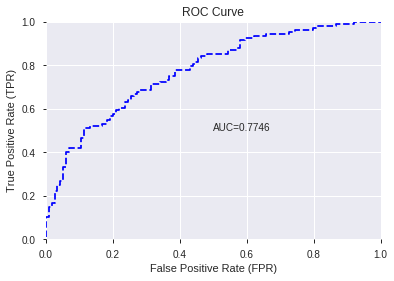

This function is available for GLM models only


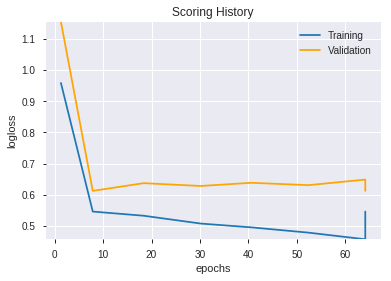

--2019-09-03 04:42:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_043510_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_043510_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'TRANGE',
 'CDLSHORTLINE',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'SAREXT',
 'WILLR_8',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'ADOSC',
 'hour',
 'PLUS_DI_8',
 'CORREL_24',
 'CDLLONGLINE',
 'ULTOSC',
 'CORREL_20',
 'AROONOSC_8',
 'CDLMARUBOZU',
 'CDLTAKURI',
 'weekday',
 'aroonup_8',
 'dayofweek',
 'BETA_14',
 'BETA_30',
 'aroondown_12',
 'STOCHRSI_fastd',
 'WILLR_20',
 'aroonup_24',
 'WILLR_30',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'aroonup_30',
 'STOCHF_fastd',
 'CMO_8',
 'AROONOSC_12',
 'WILLR_12',
 'CDLBELTHOLD',
 'weekday_name',
 'STOCH_slowd',
 'MFI_12',
 'RSI_8',
 'STOCH_slowk',
 'aroondown_8',
 'WILLR_24',
 'MFI_8',
 'WILLR_14']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_044206_model_1  0.778287  0.566663              0.296073  0.440043  0.193638

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.736893           1.000000    0.116407
1                 ULTOSC             0.371737           0.504465    0.058723
2           STOCHF_fastk             0.363398           0.493148    0.057406
3           STOCHF_fastd             0.283177           0.384285    0.044733
4                WILLR_8             0.281751           0.382349    0.044508
5            STOCH_slowk             0.281344           0.381798    0.044444
6                    SUB             0.268195           0.363954    0.042367
7     CDLCLOSINGMARUBOZU             0.263047           0.356968    0.041553
8              PLUS_DI_8             0.240021           0.325721    0.037916
9                 SAREXT             0.228645           0.310282    0.036119
10        STOCHRSI_fastd             0.221408           0.300462    0.034976
11             CORREL_24             0.218493           0.296506    0.034515
12        STOCHRSI_fastk             0.206460           0.280176    0.032614
13             CORREL_20             0.197280           0.267719    0.031164
14                  hour             0.141839           0.192483    0.022406
15           CDLBELTHOLD             0.135151           0.183407    0.021350
16                TRANGE             0.128934           0.174970    0.020368
17      CDLDRAGONFLYDOJI             0.118396           0.160670    0.018703
18             CDLTAKURI             0.117912           0.160013    0.018627
19          aroondown_12             0.117885           0.159976    0.018622
20         CDLHANGINGMAN             0.111345           0.151100    0.017589
21          CDLENGULFING             0.110351           0.149751    0.017432
22              WILLR_24             0.106602           0.144664    0.016840
23            aroonup_30             0.104484           0.141790    0.016505
24               BETA_30             0.100153           0.135913    0.015821
25              WILLR_20             0.090426           0.122713    0.014285
26                 MFI_8             0.073643           0.099936    0.011633
27  HT_PHASOR_quadrature             0.070168           0.095221    0.011084
28              WILLR_30             0.052980           0.071896    0.008369
29           AROONOSC_12             0.050301           0.068260    0.007946
30             dayofweek             0.048521           0.065845    0.007665
31               weekday             0.047937           0.065053    0.007573
32           CDLLONGLINE             0.046424           0.063000    0.007334
33              WILLR_12             0.041278           0.056016    0.006521
34             aroonup_8             0.039649           0.053806    0.006263
35              WILLR_14             0.038553           0.052318    0.006090
36               BETA_14             0.037002           0.050213    0.005845
37          HT_TRENDMODE             0.035543           0.048234    0.005615
38            aroonup_24             0.030493           0.041381    0.004817
39                 ADOSC             0.022055           0.029930    0.003484
40           CDLMARUBOZU             0.021609           0.029325    0.003414
41                 CMO_8             0.018541           0.025160    0.002929
42            AROONOSC_8             0.018310           0.024847    0.002892
43                 RSI_8             0.017254           0.023415    0.002726
44                   DIV             0.016987           0.023052    0.002683
45          weekday_name             0.016462           0.022339    0.002600
46          CDLSHORTLINE             0.016009           0.021725    0.002529
47           STOCH_slowd             0.012460           0.016909    0.001968
48           aroondown_8             0.008275           0.011229    0.001307
49                MFI_12             0.004554           0.006180    0.000719

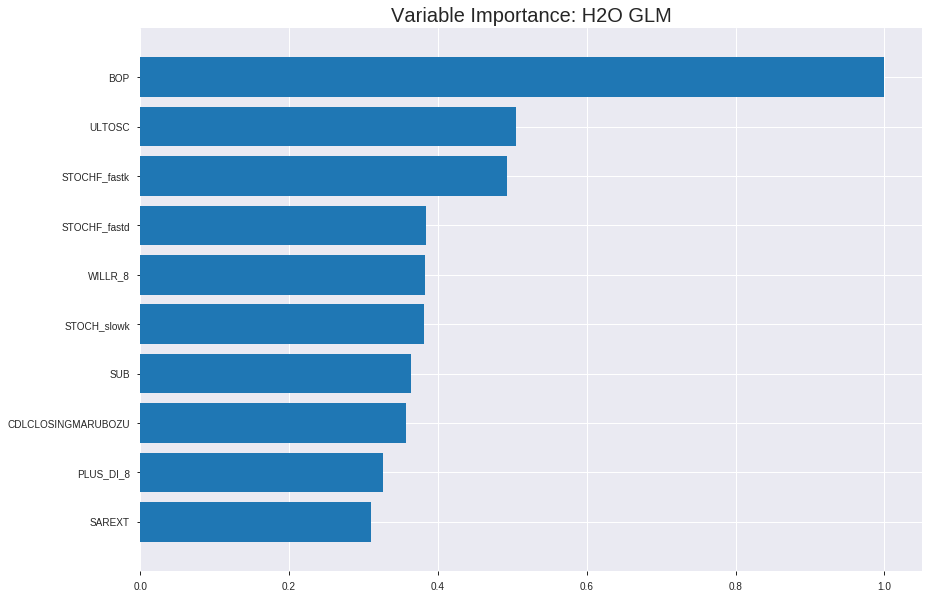

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_044206_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18590286563981165
RMSE: 0.4311645458984443
LogLoss: 0.5497036676577874
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2159.7541875235074
Residual deviance: 1712.8766284216658
AIC: 1814.8766284216658
AUC: 0.7920905397944974
pr_auc: 0.7872281717479324
Gini: 0.5841810795889948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36892667607759355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      411  362   0.4683   (362.0/773.0)
1      100  685   0.1274   (100.0/785.0)
Total  511  1047  0.2965   (462.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368927     0.747817  256
max f2                       0.147337     0.850714  351
max f0point5                 0.559517     0.723629  177
max accuracy                 0.470577     0.722721  214
max precision                0.986601     1         0
max recall                   0.0395268    1         391
max specificity              0.986601     1         0
max absolute_mcc             0.460959     0.448722  218
max min_per_class_accuracy   0.517269     0.712102  194
max mean_per_class_accuracy  0.470577     0.72229   214

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.936589           1.98471   1.98471            1                0.956335   1                           0.956335            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.917859           1.73662   1.86067            0.875            0.924559   0.9375                      0.940447            0.0178344       0.0382166                  73.6624   86.0669
    3        0.0301669                   0.905815           1.72008   1.8158             0.866667         0.911385   0.914894                    0.931172            0.0165605       0.0547771                  72.0085   81.5802
    4        0.0404365                   0.897721           1.86067   1.8272             0.9375           0.901609   0.920635                    0.923664            0.0191083       0.0738854                  86.0669   82.7196
    5        0.0500642                   0.888417           1.98471   1.85749            1                0.894234   0.935897                    0.918004            0.0191083       0.0929936                  98.4713   85.7488
    6        0.100128                    0.828696           1.75571   1.8066             0.884615         0.857222   0.910256                    0.887613            0.0878981       0.180892                   75.5708   80.6598
    7        0.150193                    0.77954            1.73026   1.78115            0.871795         0.805065   0.897436                    0.860097            0.0866242       0.267516                   73.0263   78.1153
    8        0.200257                    0.737891           1.47581   1.70482            0.74359          0.759473   0.858974                    0.834941            0.0738854       0.341401                   47.5813   70.4818
    9        0.300385                    0.67098            1.33586   1.58183            0.673077         0.703609   0.797009                    0.791163            0.133758        0.475159                   33.5865   58.1834
    10       0.399872                    0.594854           1.24205   1.4973             0.625806         0.631174   0.754414                    0.751359            0.123567        0.598726                   24.2046   49.7296
    11       0.5                         0.517115           1.11958   1.42166            0.564103         0.556381   0.716303                    0.712313            0.112102        0.710828                   11.9582   42.1656
    12       0.600128                    0.435329           1.03052   1.3564             0.519231         0.475002   0.683422                    0.672719            0.103185        0.814013                   3.05243   35.6398
    13       0.699615                    0.343946           0.717058  1.26548            0.36129          0.391985   0.637615                    0.632798            0.0713376       0.88535                    -28.2942  26.5482
    14       0.799743                    0.262949           0.559791  1.17713            0.282051         0.304792   0.593098                    0.591732            0.056051        0.941401                   -44.0209  17.7129
    15       0.899872                    0.161406           0.407121  1.09145            0.205128         0.212748   0.549929                    0.549562            0.0407643       0.982166                   -59.2879  9.14508
    16       1                           0.00153089         0.178115  1                  0.0897436        0.0930368  0.503851                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2013448326204025
RMSE: 0.4487146449809751
LogLoss: 0.5853710937896841
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 617.9132227761654
Residual deviance: 522.1510156603982
AIC: 624.1510156603982
AUC: 0.7554479418886199
pr_auc: 0.7452632341509473
Gini: 0.5108958837772397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.274199716617704: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   131  0.6238   (131.0/210.0)
1      13   223  0.0551   (13.0/236.0)
Total  92   354  0.3229   (144.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2742       0.755932  314
max f2                       0.11686      0.864745  364
max f0point5                 0.536671     0.716292  188
max accuracy                 0.418406     0.704036  237
max precision                0.973654     1         0
max recall                   0.0702064    1         378
max specificity              0.973654     1         0
max absolute_mcc             0.418406     0.405109  237
max min_per_class_accuracy   0.494697     0.680952  206
max mean_per_class_accuracy  0.418406     0.699092  237

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 48.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.921622           1.88983   1.88983            1                0.939964   1                           0.939964            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.887234           1.88983   1.88983            1                0.90173    1                           0.922971            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.877525           1.51186   1.75484            0.8              0.884039   0.928571                    0.909067            0.0169492       0.0550847                  51.1864   75.4843
    4        0.0403587                   0.861809           0.944915  1.57486            0.5              0.867989   0.833333                    0.899938            0.00847458      0.0635593                  -5.50847  57.4859
    5        0.0515695                   0.858929           1.51186   1.56116            0.8              0.860273   0.826087                    0.891315            0.0169492       0.0805085                  51.1864   56.1164
    6        0.100897                    0.805627           1.54622   1.55386            0.818182         0.832261   0.822222                    0.862445            0.0762712       0.15678                    54.6225   55.3861
    7        0.150224                    0.751245           1.28852   1.46673            0.681818         0.77586    0.776119                    0.834014            0.0635593       0.220339                   28.8521   46.6734
    8        0.201794                    0.717577           1.64333   1.51186            0.869565         0.736398   0.8                         0.809068            0.0847458       0.305085                   64.3331   51.1864
    9        0.300448                    0.63169            1.28852   1.43853            0.681818         0.67568    0.761194                    0.765269            0.127119        0.432203                   28.8521   43.8528
    10       0.401345                    0.580608           1.30188   1.40418            0.688889         0.602693   0.743017                    0.724398            0.131356        0.563559                   30.1883   40.4176
    11       0.5                         0.499426           1.11672   1.34746            0.590909         0.545281   0.713004                    0.689056            0.110169        0.673729                   11.6718   34.7458
    12       0.600897                    0.416663           1.0919    1.30455            0.577778         0.462676   0.690299                    0.651045            0.110169        0.783898                   9.19021   30.4547
    13       0.699552                    0.341729           0.859014  1.24172            0.454545         0.378839   0.657051                    0.612657            0.0847458       0.868644                   -14.0986  24.1716
    14       0.800448                    0.262345           0.755932  1.18048            0.4              0.302887   0.62465                     0.57361             0.0762712       0.944915                   -24.4068  18.0482
    15       0.899103                    0.134321           0.343606  1.08866            0.181818         0.208367   0.57606                     0.533534            0.0338983       0.978814                   -65.6394  8.86555
    16       1                           0.00174765         0.209981  1                  0.111111         0.0752336  0.529148                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 04:42:06  0.000 sec   2            .2E2      51            1.3647735628998092  1.3654477410623136
     2019-09-03 04:42:06  0.010 sec   4            .13E2     51            1.3541007482315162  1.3556351591277511
     2019-09-03 04:42:06  0.027 sec   6            .78E1     51            1.339456738625012   1.3423371627249527
     2019-09-03 04:42:06  0.041 sec   8            .49E1     51            1.3203590452456075  1.3253276324414733
     2019-09-03 04:42:06  0.052 sec   10           .3E1      51            1.296775153920804   1.3048743795238114
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 04:42:07  0.197 sec   38           .38E-2    51            1.09738446336654    1.1707893935947797
     2019-09-03 04:42:07  0.208 sec   40           .24E-2    51            1.095909498476235   1.1712117856588957
     2019-09-03 04:42:07  0.220 sec   42           .15E-2    51            1.0948327677165108  1.1717985329850817
     2019-09-03 04:42:07  0.231 sec   44           .92E-3    51            1.0940292995724834  1.1724253553665644
     2019-09-03 04:42:07  0.243 sec   46           .57E-3    51            1.093416640051608   1.1730287940907052


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.7452471482889734)

('auc', 0.7782874617737003)

('logloss', 0.566663307569617)

('mean_per_class_error', 0.2881055850635763)

('rmse', 0.4400428165237782)

('mse', 0.19363768037417953)

glm prediction progress: |████████████████████████████████████████████████| 100%


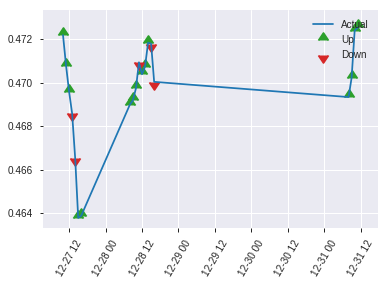


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19363768037417953
RMSE: 0.4400428165237782
LogLoss: 0.566663307569617
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.23389543359224
Residual deviance: 252.73183517604917
AIC: 354.7318351760492
AUC: 0.7782874617737003
pr_auc: 0.7547009676077749
Gini: 0.5565749235474007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2970920021837743: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   56   0.4912   (56.0/114.0)
1      11   98   0.1009   (11.0/109.0)
Total  69   154  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297092     0.745247  153
max f2                       0.109678     0.846273  207
max f0point5                 0.580829     0.704388  80
max accuracy                 0.315469     0.70852   143
max precision                0.950044     1         0
max recall                   0.109678     1         207
max specificity              0.950044     1         0
max absolute_mcc             0.315469     0.442915  143
max min_per_class_accuracy   0.418075     0.692982  110
max mean_per_class_accuracy  0.315469     0.711894  143

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 45.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.93946            2.04587   2.04587            1                0.943968   1                           0.943968            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.918584           2.04587   2.04587            1                0.931672   1                           0.93905             0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.901581           1.02294   1.7536             0.5              0.905744   0.857143                    0.929534            0.00917431      0.0550459                  2.29358   75.3604
    4        0.0403587                   0.891516           2.04587   1.81855            1                0.897875   0.888889                    0.922498            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.860727           2.04587   1.87538            1                0.871602   0.916667                    0.909774            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.818263           1.67389   1.77902            0.818182         0.834906   0.869565                    0.873968            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.772569           1.85988   1.80518            0.909091         0.789585   0.882353                    0.846667            0.0917431       0.275229                   85.9883   80.5181
    8        0.201794                    0.71648            1.30192   1.68216            0.636364         0.735337   0.822222                    0.819453            0.0642202       0.33945                    30.1918   68.2161
    9        0.300448                    0.60539            1.39491   1.58784            0.681818         0.658274   0.776119                    0.766529            0.137615        0.477064                   39.4912   58.7841
    10       0.399103                    0.522247           1.02294   1.4482             0.5              0.577832   0.707865                    0.719885            0.100917        0.577982                   2.29358   44.8201
    11       0.502242                    0.411486           1.15636   1.38827            0.565217         0.462354   0.678571                    0.666999            0.119266        0.697248                   15.6362   38.827
    12       0.600897                    0.346325           1.02294   1.32829            0.5              0.378282   0.649254                    0.619598            0.100917        0.798165                   2.29358   32.829
    13       0.699552                    0.280711           1.02294   1.28523            0.5              0.315104   0.628205                    0.576656            0.100917        0.899083                   2.29358   28.5227
    14       0.798206                    0.211618           0.464971  1.18385            0.227273         0.251056   0.578652                    0.536413            0.0458716       0.944954                   -53.5029  18.3847
    15       0.896861                    0.137005           0.185988  1.07408            0.0909091        0.173889   0.525                       0.496536            0.0183486       0.963303                   -81.4012  7.40826
    16       1                           0.0234061          0.355804  1                  0.173913         0.0834896  0.488789                    0

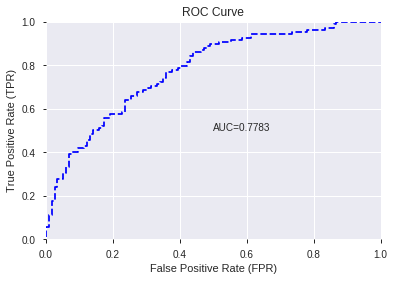

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


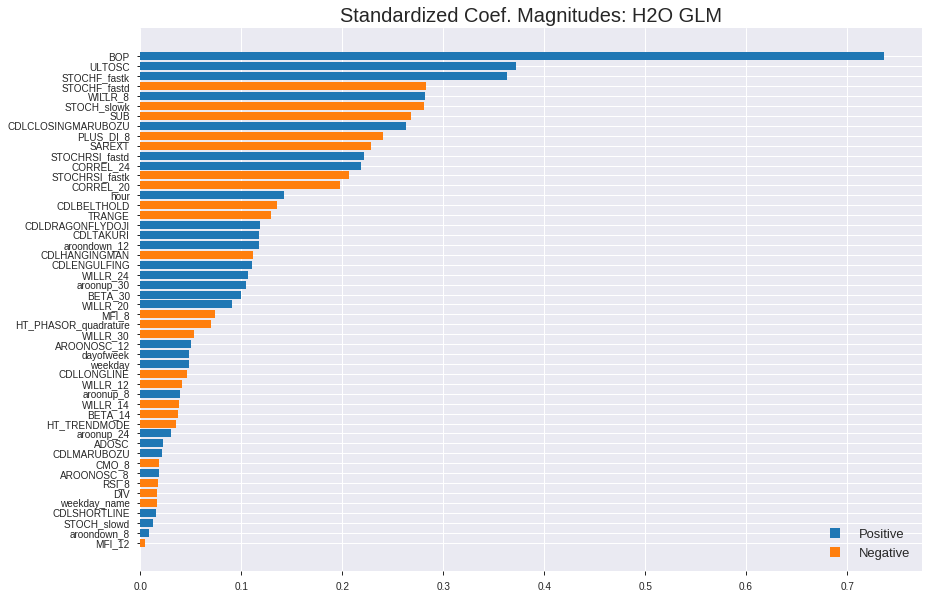

'log_likelihood'
--2019-09-03 04:42:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_044206_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_044206_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'WILLR_8',
 'STOCH_slowk',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_8',
 'SAREXT',
 'STOCHRSI_fastd',
 'CORREL_24',
 'STOCHRSI_fastk',
 'CORREL_20',
 'hour',
 'CDLBELTHOLD',
 'TRANGE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'aroondown_12',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'WILLR_24',
 'aroonup_30',
 'BETA_30',
 'WILLR_20',
 'MFI_8',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'AROONOSC_12',
 'dayofweek',
 'weekday',
 'CDLLONGLINE',
 'WILLR_12',
 'aroonup_8',
 'WILLR_14',
 'BETA_14',
 'HT_TRENDMODE',
 'aroonup_24',
 'ADOSC',
 'CDLMARUBOZU',
 'CMO_8',
 'AROONOSC_8',
 'RSI_8',
 'DIV',
 'weekday_name',
 'CDLSHORTLINE',
 'STOCH_slowd',
 'aroondown_8',
 'MFI_12']

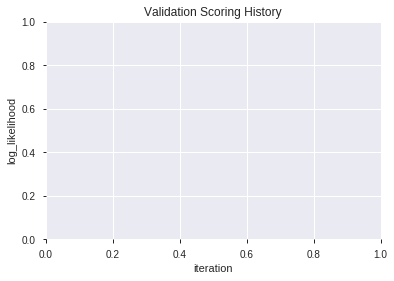

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_044217_model_6  0.789876  0.564482              0.274143  0.438414  0.192207
1               XGBoost_1_AutoML_20190903_044217  0.785852  0.568260              0.282311  0.440174  0.193754
2               XGBoost_2_AutoML_20190903_044217  0.784243  0.571565              0.278529  0.440439  0.193986
3  XGBoost_grid_1_AutoML_20190903_044217_model_2  0.783357  0.571134              0.270159  0.440954  0.194440
4  XGBoost_grid_1_AutoML_20190903_044217_model_1  0.779817  0.571445              0.292894  0.441285  0.194733
5  XGBoost_grid_1_AutoML_20190903_044217_model_3  0.777483  0.571353              0.321986  0.441853  0.195234
6               XGBoost_3_AutoML_20190903_044217  0.773861  0.576884              0.325769  0.443536  0.196724
7  XGBoost_grid_1_AutoML_20190903_044217_model_4  0.770079  0.584451              0.317198  0.447427  0.200191
8  XGBoost_grid_1_AutoML_20190903_044217_model_7  0.766699  0.588022              0.308426  0.449102  0.201693
9  XGBoost_grid_1_AutoML_20190903_044217_model_5  0.757846  0.602874              0.312611  0.455966  0.207905

variable  relative_importance  scaled_importance  percentage
0                    BOP          1878.419189           1.000000    0.193008
1           STOCHF_fastk           562.087708           0.299234    0.057755
2                 TRANGE           546.097534           0.290722    0.056112
3                    DIV           474.981781           0.252863    0.048804
4                 SAREXT           452.215363           0.240743    0.046465
5                BETA_30           375.162964           0.199723    0.038548
6                  MFI_8           338.703278           0.180313    0.034802
7              PLUS_DI_8           308.640076           0.164308    0.031713
8   HT_PHASOR_quadrature           303.061523           0.161339    0.031140
9         STOCHRSI_fastk           294.140625           0.156589    0.030223
10               BETA_14           281.706146           0.149970    0.028945
11                   SUB           258.146637           0.137428    0.026525
12                ULTOSC           249.625122           0.132891    0.025649
13                 ADOSC           246.972641           0.131479    0.025376
14                  hour           229.886017           0.122383    0.023621
15                MFI_12           214.201965           0.114033    0.022009
16               WILLR_8           209.663666           0.111617    0.021543
17              WILLR_12           171.775085           0.091447    0.017650
18        STOCHRSI_fastd           145.470627           0.077443    0.014947
19                 CMO_8           136.791748           0.072823    0.014055
20             CORREL_24           133.660294           0.071156    0.013734
21              WILLR_20           129.054855           0.068704    0.013260
22           STOCH_slowk           126.186378           0.067177    0.012966
23           STOCH_slowd           125.247780           0.066677    0.012869
24    CDLCLOSINGMARUBOZU           123.547295           0.065772    0.012695
25          aroondown_12           116.316315           0.061922    0.011952
26             aroonup_8           109.993484           0.058556    0.011302
27            aroonup_30           105.608093           0.056222    0.010851
28           AROONOSC_12           104.967979           0.055881    0.010785
29              WILLR_30           103.870491           0.055297    0.010673
30              WILLR_24            95.165977           0.050663    0.009778
31            aroonup_24            87.543823           0.046605    0.008995
32            AROONOSC_8            81.313972           0.043289    0.008355
33                 RSI_8            75.703773           0.040302    0.007779
34             dayofweek            75.496948           0.040192    0.007757
35              WILLR_14            71.141388           0.037873    0.007310
36             CORREL_20            67.650665           0.036015    0.006951
37          weekday_name            57.425125           0.030571    0.005900
38      CDLDRAGONFLYDOJI            51.155727           0.027233    0.005256
39           aroondown_8            46.959652           0.025000    0.004825
40           CDLBELTHOLD            42.866905           0.022821    0.004405
41          STOCHF_fastd            34.652481           0.018448    0.003561
42         CDLHANGINGMAN            22.039333           0.011733    0.002265
43               weekday            18.078600           0.009624    0.001858
44           CDLLONGLINE            17.248337           0.009182    0.001772
45          CDLSHORTLINE            13.672640           0.007279    0.001405
46          CDLENGULFING             7.336114           0.003905    0.000754
47             CDLTAKURI             5.668436           0.003018    0.000582
48           CDLMARUBOZU             3.920778           0.002087    0.000403
49          HT_TRENDMODE             1.098589           0.000585    0.000113

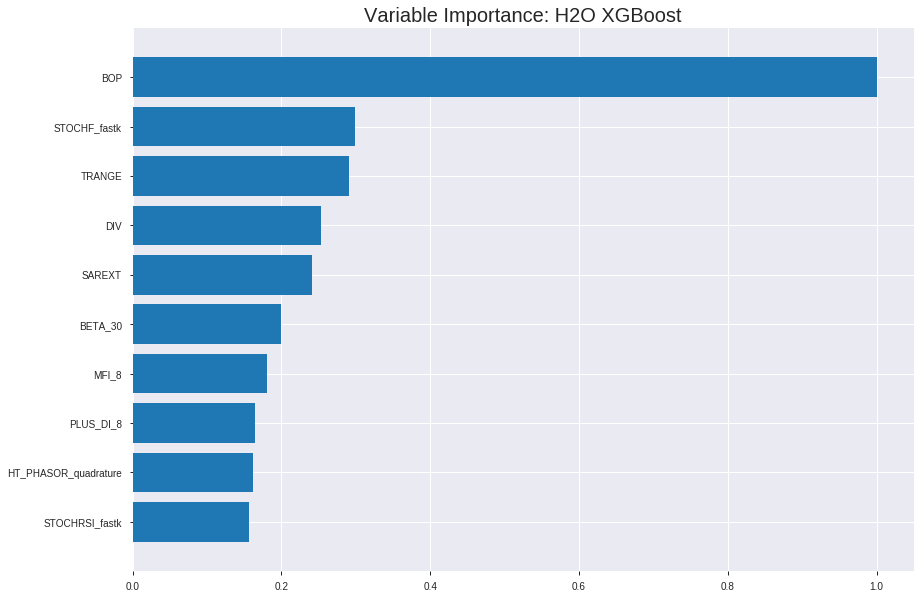

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_044217_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12728485066817904
RMSE: 0.3567700249014469
LogLoss: 0.41641729922652176
Mean Per-Class Error: 0.14262736793533337
AUC: 0.9296792214961973
pr_auc: 0.9328905485633323
Gini: 0.8593584429923946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5100728869438171: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      649  124  0.1604   (124.0/773.0)
1      98   687  0.1248   (98.0/785.0)
Total  747  811  0.1425   (222.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510073     0.860902  197
max f2                       0.32599      0.90222   276
max f0point5                 0.611296     0.863566  148
max accuracy                 0.510073     0.85751   197
max precision                0.933921     1         0
max recall                   0.179367     1         340
max specificity              0.933921     1         0
max absolute_mcc             0.510073     0.715328  197
max min_per_class_accuracy   0.519985     0.851229  192
max mean_per_class_accuracy  0.510073     0.857373  197

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.900158           1.98471    1.98471            1                0.910089  1                           0.910089            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.882238           1.98471    1.98471            1                0.890048  1                           0.900069            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.872185           1.98471    1.98471            1                0.876022  1                           0.892394            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.863313           1.98471    1.98471            1                0.867216  1                           0.886               0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.85892            1.98471    1.98471            1                0.861333  1                           0.881256            0.0191083       0.0993631                  98.4713   98.4713
    6        0.100128                    0.823548           1.98471    1.98471            1                0.840713  1                           0.860984            0.0993631       0.198726                   98.4713   98.4713
    7        0.150193                    0.790756           1.98471    1.98471            1                0.807677  1                           0.843215            0.0993631       0.298089                   98.4713   98.4713
    8        0.200257                    0.762116           1.90838    1.96563            0.961538         0.777511  0.990385                    0.826789            0.0955414       0.393631                   90.8378   96.563
    9        0.300385                    0.685779           1.75571    1.89566            0.884615         0.723609  0.955128                    0.792396            0.175796        0.569427                   75.5708   89.5656
    10       0.399872                    0.604119           1.51094    1.79994            0.76129          0.645462  0.906902                    0.755839            0.150318        0.719745                   51.0943   79.9941
    11       0.5                         0.523414           1.28497    1.69682            0.647436         0.566065  0.854942                    0.717835            0.128662        0.848408                   28.4975   69.6815
    12       0.600128                    0.433716           0.750629   1.53895            0.378205         0.479131  0.775401                    0.678009            0.0751592       0.923567                   -24.9371  53.8949
    13       0.699615                    0.326548           0.486575   1.3893             0.245161         0.382764  0.7                         0.636025            0.0484076       0.971975                   -51.3425  38.9299
    14       0.799743                    0.238723           0.216283   1.24244            0.108974         0.287675  0.626003                    0.592411            0.0216561       0.993631                   -78.3717  24.2437
    15       0.899872                    0.15341            0.0636126  1.11127            0.0320513        0.195708  0.559914                    0.54827             0.00636943      1                          -93.6387  11.127
    16       1                           0.0474046          0          1                  0                0.107358  0.503851                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19777252351162253
RMSE: 0.44471622807316413
LogLoss: 0.580001897913275
Mean Per-Class Error: 0.27681598062953994
AUC: 0.7683716707021792
pr_auc: 0.743547718044487
Gini: 0.5367433414043583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36861640214920044: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  89   0.4238   (89.0/210.0)
1      32   204  0.1356   (32.0/236.0)
Total  153  293  0.2713   (121.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368616     0.771267  261
max f2                       0.166963     0.869237  337
max f0point5                 0.421406     0.731061  240
max accuracy                 0.421406     0.7287    240
max precision                0.893205     1         0
max recall                   0.0772651    1         394
max specificity              0.893205     1         0
max absolute_mcc             0.368616     0.463263  261
max min_per_class_accuracy   0.484054     0.690476  201
max mean_per_class_accuracy  0.421406     0.723184  240

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 46.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.866015           1.88983   1.88983            1                0.879297  1                           0.879297            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.847546           1.88983   1.88983            1                0.856514  1                           0.869171            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.833602           1.1339    1.61985            0.6              0.839776  0.857143                    0.858673            0.0127119       0.0508475                  13.3898   61.9855
    4        0.0403587                   0.824103           1.41737   1.57486            0.75             0.829094  0.833333                    0.8521              0.0127119       0.0635593                  41.7373   57.4859
    5        0.0515695                   0.81286            0.755932  1.39683            0.4              0.818898  0.73913                     0.844882            0.00847458      0.0720339                  -24.4068  39.6831
    6        0.100897                    0.762714           1.37442   1.38588            0.727273         0.785129  0.733333                    0.81567             0.0677966       0.139831                   37.4422   38.5876
    7        0.150224                    0.730432           1.71803   1.49494            0.909091         0.746205  0.791045                    0.79286             0.0847458       0.224576                   71.8028   49.4941
    8        0.201794                    0.6929             1.479     1.49087            0.782609         0.709717  0.788889                    0.771613            0.0762712       0.300847                   47.8998   49.0866
    9        0.300448                    0.61778            1.50327   1.49494            0.795455         0.652403  0.791045                    0.732469            0.148305        0.449153                   50.3274   49.4941
    10       0.401345                    0.55695            1.17589   1.41473            0.622222         0.587347  0.748603                    0.695986            0.118644        0.567797                   17.5895   41.4733
    11       0.5                         0.488109           1.11672   1.35593            0.590909         0.524971  0.717489                    0.662243            0.110169        0.677966                   11.6718   35.5932
    12       0.600897                    0.425502           1.30188   1.34686            0.688889         0.454887  0.712687                    0.627426            0.131356        0.809322                   30.1883   34.6857
    13       0.699552                    0.321929           0.816063  1.272              0.431818         0.373586  0.673077                    0.591628            0.0805085       0.889831                   -18.3937  27.2001
    14       0.800448                    0.213094           0.503955  1.17519            0.266667         0.261144  0.621849                    0.54997             0.0508475       0.940678                   -49.6045  17.5189
    15       0.899103                    0.131066           0.386556  1.08866            0.204545         0.167668  0.57606                     0.508022            0.0381356       0.978814                   -61.3444  8.86555
    16       1                           0.0534744          0.209981  1                  0.111111         0.102181  0.529148                    0.467074         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:42:28  7.047 sec   0                  0.5              0.693147            0.5             0                  1                0.496149                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 04:42:28  7.164 sec   5                  0.469398         0.633417            0.853328        0.844318           1.98471          0.231707                         0.480051           0.653773              0.748194          0.714063             1.51186            0.316143
    2019-09-03 04:42:28  7.237 sec   10                 0.445802         0.588486            0.869186        0.859257           1.98471          0.222721                         0.466501           0.627063              0.759816          0.718338             1.51186            0.29148
    2019-09-03 04:42:29  7.298 sec   15                 0.42801          0.554622            0.878559        0.879432           1.98471          0.209243                         0.457468           0.608818              0.764992          0.730014             1.51186            0.284753
    2019-09-03 04:42:29  7.375 sec   20                 0.414801         0.529124            0.886434        0.886915           1.98471          0.195764                         0.452667           0.598697              0.764619          0.729263             1.88983            0.262332
    2019-09-03 04:42:29  7.445 sec   25                 0.403327         0.506752            0.892814        0.895128           1.98471          0.184852                         0.447575           0.587891              0.770732          0.733952             1.88983            0.266816
    2019-09-03 04:42:29  7.508 sec   30                 0.394321         0.488726            0.897531        0.898384           1.98471          0.189987                         0.445647           0.583342              0.769905          0.736845             1.51186            0.275785
    2019-09-03 04:42:29  7.576 sec   35                 0.385633         0.471637            0.904119        0.907927           1.98471          0.179718                         0.443948           0.579589              0.771065          0.740368             1.88983            0.29148
    2019-09-03 04:42:29  7.635 sec   40                 0.378696         0.45813             0.910699        0.9144             1.98471          0.178434                         0.444958           0.581358              0.767776          0.736987             1.51186            0.29148
    2019-09-03 04:42:29  7.706 sec   45                 0.373063         0.447121            0.914818        0.919188           1.98471          0.165597                         0.445023           0.581205              0.766737          0.736031             1.88983            0.282511
    2019-09-03 04:42:29  7.778 sec   50                 0.366053         0.434086            0.921574        0.925754           1.98471          0.156611                         0.446027           0.582925              0.765274          0.734706             1.88983            0.284753
    2019-09-03 04:42:29  7.840 sec   55                 0.361475         0.425151            0.925183        0.929223           1.98471          0.15276                          0.445387           0.581321              0.767575          0.73

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           1878.419189453125      1.0                    0.19300793207306086
STOCHF_fastk  562.0877075195312      0.2992344364216036     0.05775461977878151
TRANGE        546.0975341796875      0.29072186721999793    0.05611162640055078
DIV           474.9817810058594      0.2528625046383515     0.04880446911906299
SAREXT        452.2153625488281      0.2407425164137533     0.04646521525508344
---           ---                    ---                    ---
CDLSHORTLINE  13.672639846801758     0.00727880119814063    0.0014048663672240407
CDLENGULFING  7.336114406585693      0.0039054724567211744  0.0007537871626400505
CDLTAKURI     5.668436050415039      0.003017662980788289   0.0005824328916153765
CDLMARUBOZU   3.920778274536133      0.002087275458295127   0.00040286071987239287
HT_TRENDMODE  1.098589301109314      0.0005848477843910616  0.00011288026144283017


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7596899224806203)

('auc', 0.7898760663125705)

('logloss', 0.56448201731774)

('mean_per_class_error', 0.2701995815226139)

('rmse', 0.4384141118618801)

('mse', 0.19220693347964113)

xgboost prediction progress: |████████████████████████████████████████████| 100%


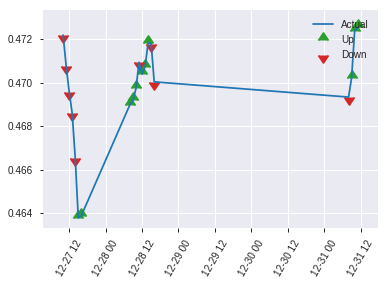


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19220693347964113
RMSE: 0.4384141118618801
LogLoss: 0.56448201731774
Mean Per-Class Error: 0.2701995815226139
AUC: 0.7898760663125705
pr_auc: 0.7537006940434877
Gini: 0.5797521326251409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24902132153511047: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   51   0.4474   (51.0/114.0)
1      11   98   0.1009   (11.0/109.0)
Total  74   149  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249021     0.75969   148
max f2                       0.160219     0.85622   182
max f0point5                 0.497801     0.732673  98
max accuracy                 0.497801     0.730942  98
max precision                0.915653     1         0
max recall                   0.0946513    1         214
max specificity              0.915653     1         0
max absolute_mcc             0.249021     0.479535  148
max min_per_class_accuracy   0.394621     0.715596  108
max mean_per_class_accuracy  0.497801     0.7298    98

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.884835           2.04587    2.04587            1                0.898696  1                           0.898696            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.868133           1.02294    1.6367             0.5              0.870741  0.8                         0.887514            0.00917431      0.0366972                  2.29358   63.6697
    3        0.0313901                   0.86206            2.04587    1.7536             1                0.865615  0.857143                    0.881257            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.841612           2.04587    1.81855            1                0.85193   0.888889                    0.87474             0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.835653           2.04587    1.87538            1                0.838733  0.916667                    0.865738            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.793969           1.67389    1.77902            0.818182         0.809765  0.869565                    0.838969            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.732849           1.48791    1.68484            0.727273         0.765385  0.823529                    0.815162            0.0733945       0.256881                   48.7907   68.4835
    8        0.201794                    0.703233           1.48791    1.6367             0.727273         0.725113  0.8                         0.79315             0.0733945       0.330275                   48.7907   63.6697
    9        0.300448                    0.603496           1.5809     1.61838            0.772727         0.657105  0.791045                    0.748479            0.155963        0.486239                   58.0901   61.8376
    10       0.399103                    0.534728           1.11593    1.49418            0.545455         0.566751  0.730337                    0.703557            0.110092        0.59633                    11.593    49.4176
    11       0.502242                    0.372096           1.15636    1.4248             0.565217         0.465985  0.696429                    0.65477             0.119266        0.715596                   15.6362   42.4803
    12       0.600897                    0.293766           0.929942   1.34356            0.454545         0.325434  0.656716                    0.6007              0.0917431       0.807339                   -7.00584  34.3557
    13       0.699552                    0.233228           1.02294    1.29834            0.5              0.262395  0.634615                    0.55299             0.100917        0.908257                   2.29358   29.8342
    14       0.798206                    0.176945           0.557965   1.20683            0.272727         0.20289   0.589888                    0.509719            0.0550459       0.963303                   -44.2035  20.6834
    15       0.896861                    0.122991           0.278982   1.10477            0.136364         0.147005  0.54                        0.469821            0.0275229       0.990826                   -72.1018  10.4771
    16       1                           0.0681154          0.0889509  1                  0.0434783        0.100968  0.488789                   

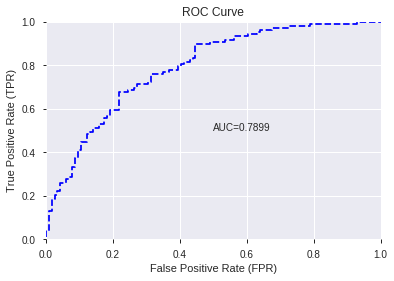

This function is available for GLM models only


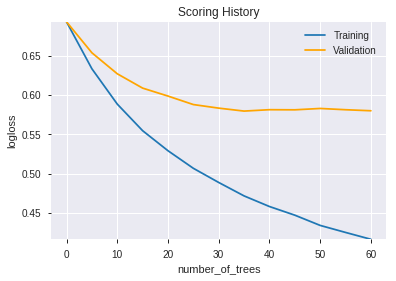

--2019-09-03 04:42:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_044217_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_044217_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'SAREXT',
 'BETA_30',
 'MFI_8',
 'PLUS_DI_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'BETA_14',
 'SUB',
 'ULTOSC',
 'ADOSC',
 'hour',
 'MFI_12',
 'WILLR_8',
 'WILLR_12',
 'STOCHRSI_fastd',
 'CMO_8',
 'CORREL_24',
 'WILLR_20',
 'STOCH_slowk',
 'STOCH_slowd',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'aroonup_8',
 'aroonup_30',
 'AROONOSC_12',
 'WILLR_30',
 'WILLR_24',
 'aroonup_24',
 'AROONOSC_8',
 'RSI_8',
 'dayofweek',
 'WILLR_14',
 'CORREL_20',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'aroondown_8',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLHANGINGMAN',
 'weekday',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


36

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190903_044243  0.783277  0.609461              0.308225  0.459243  0.210904
1  DeepLearning_grid_1_AutoML_20190903_044243_model_8  0.775551  0.565929              0.318606  0.440841  0.194341
2  DeepLearning_grid_1_AutoML_20190903_044243_model_4  0.773137  0.632938              0.360655  0.456140  0.208064
3  DeepLearning_grid_1_AutoML_20190903_044243_model_3  0.771447  0.591487              0.318003  0.447547  0.200298
4  DeepLearning_grid_1_AutoML_20190903_044243_model_9  0.767182  0.578530              0.306655  0.444380  0.197474
5  DeepLearning_grid_1_AutoML_20190903_044243_model_2  0.763399  0.597251              0.297682  0.451489  0.203842
6  DeepLearning_grid_1_AutoML_20190903_044243_model_5  0.757122  0.582366              0.352487  0.447914  0.200627
7  DeepLearning_grid_1_AutoML_20190903_044243_model_6  0.756800  0.610602              0.298286  0.453438  0.205606
8  DeepLearning_grid_1_AutoML_20190903_044243_model_7  0.751408  0.621453              0.291888  0.460824  0.212359
9  DeepLearning_grid_1_AutoML_20190903_044243_model_1  0.745373  0.695935              0.343916  0.479007  0.229448

variable  relative_importance  scaled_importance  percentage
0             WILLR_24             1.000000           1.000000    0.038391
1     CDLDRAGONFLYDOJI             0.992083           0.992083    0.038087
2               CCI_12             0.979515           0.979515    0.037604
3                  SUB             0.968438           0.968438    0.037179
4                  BOP             0.935741           0.935741    0.035924
5             WILLR_12             0.869901           0.869901    0.033396
6               RSI_14             0.841114           0.841114    0.032291
7            ROCR100_8             0.804026           0.804026    0.030867
8                RSI_8             0.802089           0.802089    0.030793
9         STOCHF_fastk             0.789246           0.789246    0.030300
10  CDLCLOSINGMARUBOZU             0.785927           0.785927    0.030172
11        CDLENGULFING             0.777707           0.777707    0.029857
12               ROC_8             0.774965           0.774965    0.029752
13                 DIV             0.761341           0.761341    0.029229
14              CMO_12             0.758873           0.758873    0.029134
15              ROCR_8             0.737993           0.737993    0.028332
16         CDLBELTHOLD             0.731788           0.731788    0.028094
17      STOCHRSI_fastk             0.711675           0.711675    0.027322
18            WILLR_14             0.706437           0.706437    0.027121
19              RSI_12             0.703196           0.703196    0.026996
20              ROCP_8             0.700809           0.700809    0.026905
21              CMO_14             0.693195           0.693195    0.026612
22              ULTOSC             0.682540           0.682540    0.026203
23         CDLMARUBOZU             0.680174           0.680174    0.026113
24               MOM_8             0.678709           0.678709    0.026056
25               CMO_8             0.672080           0.672080    0.025802
26            WILLR_20             0.662715           0.662715    0.025442
27               ADOSC             0.650973           0.650973    0.024991
28               CCI_8             0.633000           0.633000    0.024301
29        CDLSHORTLINE             0.622010           0.622010    0.023880
30              TRANGE             0.619113           0.619113    0.023768
31         CDLLONGLINE             0.509338           0.509338    0.019554
32              CCI_14             0.482137           0.482137    0.018510
33            WILLR_30             0.467501           0.467501    0.017948
34             WILLR_8             0.448121           0.448121    0.017204
35           CDLTAKURI             0.413342           0.413342    0.015869

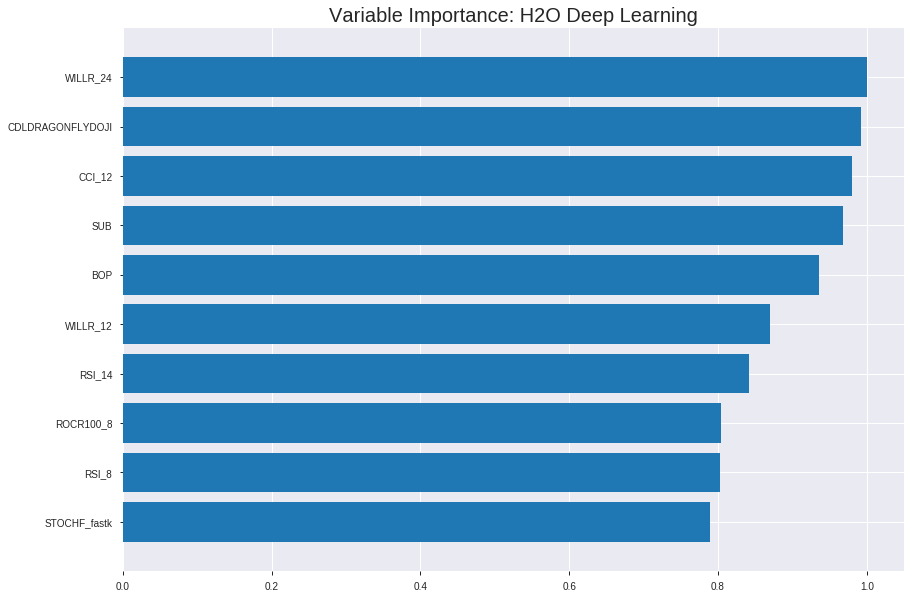

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190903_044243


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19059498125212543
RMSE: 0.4365718511907581
LogLoss: 0.5605082756961037
Mean Per-Class Error: 0.2748362323975577
AUC: 0.7992262753273293
pr_auc: 0.7969083454625612
Gini: 0.5984525506546585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23756894591261812: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  398   0.5149   (398.0/773.0)
1      79   706   0.1006   (79.0/785.0)
Total  454  1104  0.3062   (477.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237569     0.747485  291
max f2                       0.112692     0.853793  350
max f0point5                 0.514365     0.727518  166
max accuracy                 0.372417     0.725289  229
max precision                0.996558     1         0
max recall                   0.00436675   1         399
max specificity              0.996558     1         0
max absolute_mcc             0.372417     0.450605  229
max min_per_class_accuracy   0.383772     0.72445   224
max mean_per_class_accuracy  0.372417     0.725164  229

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 42.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.96953            1.98471   1.98471            1                0.987058   1                           0.987058            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.938186           1.86067   1.92269            0.9375           0.955321   0.96875                     0.97119             0.0191083       0.0394904                  86.0669   92.2691
    3        0.0301669                   0.917574           1.8524    1.90026            0.933333         0.928088   0.957447                    0.957434            0.0178344       0.0573248                  85.2399   90.0257
    4        0.0404365                   0.893947           1.98471   1.92171            1                0.906507   0.968254                    0.9445              0.0203822       0.077707                   98.4713   92.1707
    5        0.0500642                   0.874767           1.98471   1.93382            1                0.882277   0.974359                    0.932534            0.0191083       0.0968153                  98.4713   93.3823
    6        0.100128                    0.786348           1.78115   1.85749            0.897436         0.827905   0.935897                    0.88022             0.089172        0.185987                   78.1153   85.7488
    7        0.150193                    0.732336           1.60304   1.77267            0.807692         0.759018   0.893162                    0.839819            0.0802548       0.266242                   60.3038   77.2671
    8        0.200257                    0.676515           1.55215   1.71754            0.782051         0.701575   0.865385                    0.805258            0.077707        0.343949                   55.2148   71.754
    9        0.300385                    0.574009           1.38675   1.60728            0.698718         0.626435   0.809829                    0.74565             0.138854        0.482803                   38.6755   60.7279
    10       0.399872                    0.468158           1.22924   1.51322            0.619355         0.518605   0.76244                     0.689162            0.122293        0.605096                   22.9242   51.3224
    11       0.5                         0.383729           1.15775   1.44204            0.583333         0.425979   0.726573                    0.636458            0.115924        0.721019                   15.7749   44.2038
    12       0.600128                    0.310005           0.903299  1.35215            0.455128         0.347886   0.681283                    0.588311            0.0904459       0.811465                   -9.6701   35.2152
    13       0.699615                    0.243854           0.80669   1.27459            0.406452         0.27812    0.642202                    0.544201            0.0802548       0.89172                    -19.331   27.4587
    14       0.799743                    0.178189           0.572513  1.18669            0.288462         0.210776   0.597913                    0.502456            0.0573248       0.949045                   -42.7487  18.6687
    15       0.899872                    0.101906           0.356231  1.09428            0.179487         0.14147    0.551355                    0.46229             0.0356688       0.984713                   -64.3769  9.42821
    16       1                           0.00346363         0.15267   1                  0.0769231        0.0524516  0.503851                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22457170851355018
RMSE: 0.47388997511400277
LogLoss: 0.6440007849610295
Mean Per-Class Error: 0.294592413236481
AUC: 0.7540960451977401
pr_auc: 0.745984991120993
Gini: 0.5081920903954802
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15546928583509234: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   129  0.6143   (129.0/210.0)
1      14   222  0.0593   (14.0/236.0)
Total  95   351  0.3206   (143.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.155469     0.756388  315
max f2                       0.081955     0.865527  358
max f0point5                 0.350574     0.722789  216
max accuracy                 0.350574     0.706278  216
max precision                0.99753      1         0
max recall                   0.0116344    1         391
max specificity              0.99753      1         0
max absolute_mcc             0.350574     0.410712  216
max min_per_class_accuracy   0.363857     0.699153  210
max mean_per_class_accuracy  0.350574     0.705408  216

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 38.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.976746           1.88983   1.88983            1                0.992687   1                           0.992687            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.945285           1.88983   1.88983            1                0.956728   1                           0.976705            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.903873           1.88983   1.88983            1                0.918738   1                           0.956003            0.0211864       0.059322                   88.9831   88.9831
    4        0.0403587                   0.859885           1.41737   1.78484            0.75             0.887248   0.944444                    0.940724            0.0127119       0.0720339                  41.7373   78.484
    5        0.0515695                   0.839194           1.51186   1.7255             0.8              0.849226   0.913043                    0.920833            0.0169492       0.0889831                  51.1864   72.5497
    6        0.100897                    0.754033           1.20262   1.46987            0.636364         0.785464   0.777778                    0.854653            0.059322        0.148305                   20.2619   46.9868
    7        0.150224                    0.678014           1.46032   1.46673            0.772727         0.712624   0.776119                    0.808016            0.0720339       0.220339                   46.0324   46.6734
    8        0.201794                    0.617679           1.31466   1.42787            0.695652         0.648129   0.755556                    0.767156            0.0677966       0.288136                   31.4665   42.7872
    9        0.300448                    0.51623            1.54622   1.46673            0.818182         0.564526   0.776119                    0.700621            0.152542        0.440678                   54.6225   46.6734
    10       0.401345                    0.446174           1.21789   1.40418            0.644444         0.479359   0.743017                    0.644997            0.122881        0.563559                   21.7891   40.4176
    11       0.5                         0.370781           1.20262   1.36441            0.636364         0.40415    0.721973                    0.597475            0.118644        0.682203                   20.2619   36.4407
    12       0.600897                    0.284022           0.797928  1.26929            0.422222         0.329032   0.671642                    0.552401            0.0805085       0.762712                   -20.2072  26.9289
    13       0.699552                    0.223632           1.07377   1.24172            0.568182         0.250877   0.657051                    0.509878            0.105932        0.868644                   7.37673   24.1716
    14       0.800448                    0.151259           0.713936  1.17519            0.377778         0.183493   0.621849                    0.468737            0.0720339       0.940678                   -28.6064  17.5189
    15       0.899103                    0.0829426          0.429507  1.09337            0.227273         0.112651   0.578554                    0.429665            0.0423729       0.983051                   -57.0493  9.33683
    16       1                           0.00349743         0.167985  1                  0.0888889        0.0333127  0.529148                    


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:42:43  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:42:43  0.051 sec   111285 obs/sec    1         1             1558       0.494405         0.714322            0.0221975      0.690953        0.693756           1.98471          0.401797                         0.518805           0.769758              -0.0803072       0.668836          0.677844             1.88983            0.367713
    2019-09-03 04:42:43  0.185 sec   116268 obs/sec    10        10            15580      0.436572         0.560508            0.237575       0.799226        0.796908           1.98471          0.306162                         0.47389            0.644001              0.09865          0.754096          0.745985             1.88983            0.320628

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
WILLR_24          1.0                    1.0                  0.03839094361588389
CDLDRAGONFLYDOJI  0.9920830726623535     0.9920830726623535   0.038087005304853254
CCI_12            0.9795146584510803     0.9795146584510803   0.03760449202352719
SUB               0.9684380292892456     0.9684380292892456   0.037179249777921135
BOP               0.9357409477233887     0.9357409477233887   0.03592397796312237
---               ---                    ---                  ---
CDLLONGLINE       0.5093377232551575     0.5093377232551575   0.019553955814931422
CCI_14            0.4821374714374542     0.4821374714374542   0.018509712481060134
WILLR_30          0.4675006568431854     0.4675006568431854   0.017947791357255414
WILLR_8           0.44812142848968506    0.44812142848968506  0.01720380449421684
CDLTAKURI         0.4133417308330536     0.4133417308330536   0.015868579082503616


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7463768115942029)

('auc', 0.7832769998390472)

('logloss', 0.6094613571430958)

('mean_per_class_error', 0.2811443746982134)

('rmse', 0.4592425923352011)

('mse', 0.21090375861475572)

deeplearning prediction progress: |███████████████████████████████████████| 100%


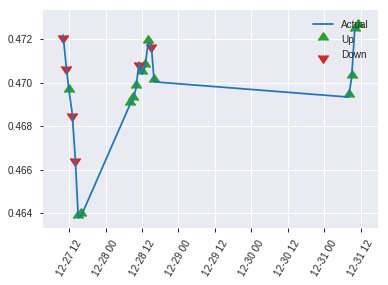


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21090375861475572
RMSE: 0.4592425923352011
LogLoss: 0.6094613571430958
Mean Per-Class Error: 0.2811443746982134
AUC: 0.7832769998390472
pr_auc: 0.7654147003413353
Gini: 0.5665539996780944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14468754971583025: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   64   0.5614   (64.0/114.0)
1      6    103  0.055    (6.0/109.0)
Total  56   167  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144688     0.746377  166
max f2                       0.103478     0.86039   179
max f0point5                 0.420257     0.710956  79
max accuracy                 0.292653     0.717489  109
max precision                0.980329     1         0
max recall                   0.0263006    1         214
max specificity              0.980329     1         0
max absolute_mcc             0.144688     0.442116  166
max min_per_class_accuracy   0.292653     0.715596  109
max mean_per_class_accuracy  0.255234     0.718856  123

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 36.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.970033           2.04587   2.04587            1                0.976387   1                           0.976387            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.940846           2.04587   2.04587            1                0.952056   1                           0.966654            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.903857           2.04587   2.04587            1                0.922773   1                           0.954117            0.0183486       0.0642202                  104.587   104.587
    4        0.0403587                   0.873687           2.04587   2.04587            1                0.896805   1                           0.941381            0.0183486       0.0825688                  104.587   104.587
    5        0.0538117                   0.84793            2.04587   2.04587            1                0.86296    1                           0.921776            0.0275229       0.110092                   104.587   104.587
    6        0.103139                    0.76339            1.48791   1.77902            0.727273         0.80534    0.869565                    0.866089            0.0733945       0.183486                   48.7907   77.9019
    7        0.152466                    0.724282           1.67389   1.74501            0.818182         0.739076   0.852941                    0.824997            0.0825688       0.266055                   67.3895   74.5008
    8        0.201794                    0.631763           1.48791   1.68216            0.727273         0.681905   0.822222                    0.790019            0.0733945       0.33945                    48.7907   68.2161
    9        0.300448                    0.491047           1.20892   1.52677            0.590909         0.572188   0.746269                    0.718492            0.119266        0.458716                   20.8924   52.677
    10       0.399103                    0.389174           1.39491   1.49418            0.681818         0.430739   0.730337                    0.647362            0.137615        0.59633                    39.4912   49.4176
    11       0.502242                    0.284479           1.15636   1.4248             0.565217         0.332983   0.696429                    0.582802            0.119266        0.715596                   15.6362   42.4803
    12       0.600897                    0.224767           0.743953  1.31302            0.363636         0.255818   0.641791                    0.529118            0.0733945       0.788991                   -25.6047  31.3022
    13       0.699552                    0.168449           1.02294   1.27211            0.5              0.194172   0.621795                    0.481882            0.100917        0.889908                   2.29358   27.2112
    14       0.798206                    0.112717           0.743953  1.20683            0.363636         0.143394   0.589888                    0.440047            0.0733945       0.963303                   -25.6047  20.6834
    15       0.896861                    0.0622885          0.185988  1.09454            0.0909091        0.0837365  0.535                       0.400852            0.0183486       0.981651                   -81.4012  9.45413
    16       1                           0.00835408         0.177902  1                  0.0869565        0.0341526  0.488789                    

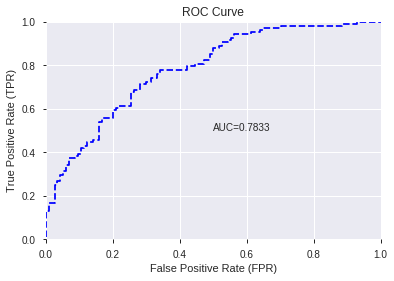

This function is available for GLM models only


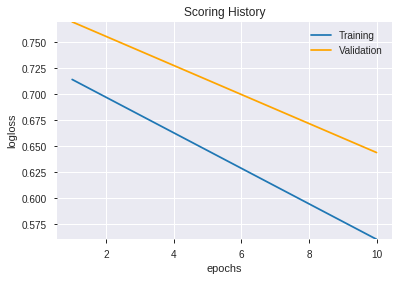

--2019-09-03 04:49:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190903_044243',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190903_044243',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b794'

['WILLR_24',
 'CDLDRAGONFLYDOJI',
 'CCI_12',
 'SUB',
 'BOP',
 'WILLR_12',
 'RSI_14',
 'ROCR100_8',
 'RSI_8',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'ROC_8',
 'DIV',
 'CMO_12',
 'ROCR_8',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'WILLR_14',
 'RSI_12',
 'ROCP_8',
 'CMO_14',
 'ULTOSC',
 'CDLMARUBOZU',
 'MOM_8',
 'CMO_8',
 'WILLR_20',
 'ADOSC',
 'CCI_8',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLLONGLINE',
 'CCI_14',
 'WILLR_30',
 'WILLR_8',
 'CDLTAKURI']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_044940_model_1  0.783679  0.564179               0.28211  0.439436  0.193104

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.823111           1.000000    0.165430
1         STOCHF_fastk             0.295124           0.358547    0.059315
2   CDLCLOSINGMARUBOZU             0.277204           0.336776    0.055713
3               ULTOSC             0.250407           0.304220    0.050327
4                CCI_8             0.249856           0.303551    0.050217
5               TRANGE             0.243175           0.295435    0.048874
6                  SUB             0.225270           0.273681    0.045275
7              WILLR_8             0.213019           0.258797    0.042813
8               RSI_14             0.205436           0.249585    0.041289
9               CMO_14             0.201167           0.244399    0.040431
10               CMO_8             0.171889           0.208829    0.034547
11               RSI_8             0.170572           0.207228    0.034282
12               MOM_8             0.170546           0.207197    0.034277
13              CCI_12             0.163079           0.198125    0.032776
14            WILLR_30             0.156856           0.190565    0.031525
15         CDLBELTHOLD             0.144247           0.175247    0.028991
16    CDLDRAGONFLYDOJI             0.125858           0.152905    0.025295
17           CDLTAKURI             0.125750           0.152775    0.025274
18            WILLR_24             0.123433           0.149959    0.024808
19            WILLR_14             0.107410           0.130493    0.021587
20        CDLENGULFING             0.082996           0.100832    0.016681
21              CCI_14             0.078387           0.095233    0.015754
22      STOCHRSI_fastk             0.069017           0.083849    0.013871
23              CMO_12             0.061271           0.074438    0.012314
24              RSI_12             0.055529           0.067463    0.011160
25         CDLLONGLINE             0.050405           0.061238    0.010131
26         CDLMARUBOZU             0.027464           0.033366    0.005520
27            WILLR_12             0.026143           0.031762    0.005254
28               ROC_8             0.014061           0.017083    0.002826
29              ROCP_8             0.014017           0.017029    0.002817
30           ROCR100_8             0.013830           0.016802    0.002780
31              ROCR_8             0.013501           0.016402    0.002713
32            WILLR_20             0.010586           0.012861    0.002128
33                 DIV             0.008645           0.010502    0.001737
34        CDLSHORTLINE             0.003984           0.004840    0.000801
35               ADOSC             0.002330           0.002830    0.000468

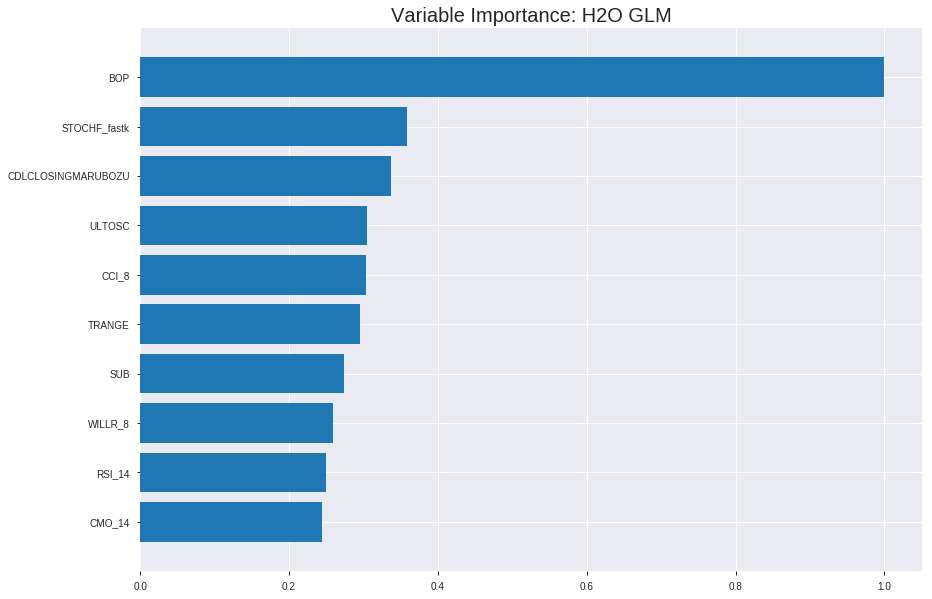

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_044940_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1907107036387412
RMSE: 0.4367043664067732
LogLoss: 0.5610485069809654
Null degrees of freedom: 1557
Residual degrees of freedom: 1521
Null deviance: 2159.7541875235074
Residual deviance: 1748.227147752688
AIC: 1822.227147752688
AUC: 0.7803141042015145
pr_auc: 0.7762138795566349
Gini: 0.560628208403029
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46919099118972274: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      509  264  0.3415   (264.0/773.0)
1      176  609  0.2242   (176.0/785.0)
Total  685  873  0.2824   (440.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469191     0.73462   211
max f2                       0.114244     0.848544  367
max f0point5                 0.547908     0.717599  175
max accuracy                 0.469191     0.717587  211
max precision                0.960341     1         0
max recall                   0.050954     1         390
max specificity              0.960341     1         0
max absolute_mcc             0.469191     0.437453  211
max min_per_class_accuracy   0.516089     0.712102  189
max mean_per_class_accuracy  0.469191     0.717135  211

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.925939           1.86067   1.86067            0.9375           0.940738  0.9375                      0.940738            0.0191083       0.0191083                  86.0669   86.0669
    2        0.0205392                   0.912603           1.86067   1.86067            0.9375           0.920582  0.9375                      0.93066             0.0191083       0.0382166                  86.0669   86.0669
    3        0.0301669                   0.903168           1.8524    1.85803            0.933333         0.907264  0.93617                     0.923193            0.0178344       0.056051                   85.2399   85.803
    4        0.0404365                   0.891068           1.73662   1.8272             0.875            0.897652  0.920635                    0.916707            0.0178344       0.0738854                  73.6624   82.7196
    5        0.0500642                   0.879278           1.98471   1.85749            1                0.885305  0.935897                    0.910668            0.0191083       0.0929936                  98.4713   85.7488
    6        0.100128                    0.817025           1.65393   1.75571            0.833333         0.849909  0.884615                    0.880288            0.0828025       0.175796                   65.3928   75.5708
    7        0.150193                    0.764149           1.67937   1.73026            0.846154         0.789431  0.871795                    0.850003            0.0840764       0.259873                   67.9373   73.0263
    8        0.200257                    0.725346           1.60304   1.69846            0.807692         0.74407   0.855769                    0.82352             0.0802548       0.340127                   60.3038   69.8457
    9        0.300385                    0.657686           1.24681   1.54791            0.628205         0.690283  0.779915                    0.779107            0.124841        0.464968                   24.6807   54.7907
    10       0.399872                    0.597963           1.31887   1.49092            0.664516         0.626451  0.751204                    0.741127            0.13121         0.596178                   31.8874   49.0924
    11       0.5                         0.515279           1.15775   1.4242             0.583333         0.554718  0.717587                    0.703797            0.115924        0.712102                   15.7749   42.4204
    12       0.600128                    0.429434           0.916022  1.33942            0.461538         0.474107  0.674866                    0.665475            0.0917197       0.803822                   -8.39784  33.9416
    13       0.699615                    0.359507           0.717058  1.25092            0.36129          0.395316  0.630275                    0.627058            0.0713376       0.875159                   -28.2942  25.0916
    14       0.799743                    0.27693            0.597959  1.16917            0.301282         0.322572  0.589085                    0.588936            0.0598726       0.935032                   -40.2041  16.9165
    15       0.899872                    0.170327           0.407121  1.08437            0.205128         0.228599  0.546362                    0.548841            0.0407643       0.975796                   -59.2879  8.43726
    16       1                           0.00251181         0.241728  1                  0.121795         0.099516  0.503851                    0.503851          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19900591001412196
RMSE: 0.4461007845925873
LogLoss: 0.5789855887380281
Null degrees of freedom: 445
Residual degrees of freedom: 409
Null deviance: 617.9132227761654
Residual deviance: 516.455145154321
AIC: 590.455145154321
AUC: 0.7635290556900727
pr_auc: 0.7555534660227297
Gini: 0.5270581113801454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3092658360668297: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   113  0.5381   (113.0/210.0)
1      24   212  0.1017   (24.0/236.0)
Total  121  325  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309266     0.755793  292
max f2                       0.133604     0.867953  362
max f0point5                 0.49618      0.721326  194
max accuracy                 0.440307     0.713004  232
max precision                0.94101      1         0
max recall                   0.0924169    1         377
max specificity              0.94101      1         0
max absolute_mcc             0.440307     0.423042  232
max min_per_class_accuracy   0.473221     0.695238  202
max mean_per_class_accuracy  0.440307     0.708616  232

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.911628           1.88983   1.88983            1                0.925692   1                           0.925692            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.888226           1.88983   1.88983            1                0.897943   1                           0.913359            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.876982           1.88983   1.88983            1                0.882437   1                           0.902316            0.0211864       0.059322                   88.9831   88.9831
    4        0.0403587                   0.865054           0.944915  1.67985            0.5              0.871606   0.888889                    0.895491            0.00847458      0.0677966                  -5.50847  67.9849
    5        0.0515695                   0.844742           1.51186   1.64333            0.8              0.853384   0.869565                    0.886338            0.0169492       0.0847458                  51.1864   64.3331
    6        0.100897                    0.774885           1.46032   1.55386            0.772727         0.805977   0.822222                    0.84705             0.0720339       0.15678                    46.0324   55.3861
    7        0.150224                    0.729329           1.54622   1.55135            0.818182         0.750173   0.820896                    0.81524             0.0762712       0.233051                   54.6225   55.1353
    8        0.201794                    0.699196           1.39683   1.51186            0.73913          0.712691   0.8                         0.789033            0.0720339       0.305085                   39.6831   51.1864
    9        0.300448                    0.625628           1.41737   1.48084            0.75             0.671649   0.783582                    0.750489            0.139831        0.444915                   41.7373   48.0837
    10       0.401345                    0.554139           1.17589   1.40418            0.622222         0.592814   0.743017                    0.71085             0.118644        0.563559                   17.5895   40.4176
    11       0.5                         0.488467           1.24557   1.37288            0.659091         0.521979   0.726457                    0.673584            0.122881        0.686441                   24.557    37.2881
    12       0.600897                    0.432098           1.04991   1.31865            0.555556         0.455891   0.697761                    0.637031            0.105932        0.792373                   4.99058   31.865
    13       0.699552                    0.334617           0.773112  1.24172            0.409091         0.378096   0.657051                    0.600515            0.0762712       0.868644                   -22.6888  24.1716
    14       0.800448                    0.247097           0.713936  1.17519            0.377778         0.291318   0.621849                    0.56154             0.0720339       0.940678                   -28.6064  17.5189
    15       0.899103                    0.135438           0.472458  1.09808            0.25             0.199474   0.581047                    0.521812            0.0466102       0.987288                   -52.7542  9.80811
    16       1                           0.00257613         0.125989  1                  0.0666667        0.0794167  0.529148                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 04:49:41  0.000 sec   2            .2E2      37            1.3642245230787404  1.3640160705832074
     2019-09-03 04:49:41  0.007 sec   4            .13E2     37            1.3540365978757465  1.3541405037844387
     2019-09-03 04:49:41  0.014 sec   6            .78E1     37            1.3406242930324945  1.3412207824969686
     2019-09-03 04:49:41  0.021 sec   8            .49E1     37            1.3237723677167008  1.3251552049289599
     2019-09-03 04:49:41  0.028 sec   10           .3E1      37            1.3034030009597684  1.306054214504972
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 04:49:41  0.126 sec   38           .38E-2    37            1.120545175719351   1.1585741440750459
     2019-09-03 04:49:41  0.133 sec   40           .24E-2    37            1.1193377100917343  1.1596230659567592
     2019-09-03 04:49:41  0.140 sec   42           .15E-2    37            1.118303553226063   1.160869346276392
     2019-09-03 04:49:41  0.147 sec   44           .92E-3    37            1.1173163609536012  1.162260841853555
     2019-09-03 04:49:41  0.154 sec   46           .57E-3    37            1.1163969544631691  1.1637611608099105


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7611940298507462)

('auc', 0.7836793819410913)

('logloss', 0.5641791800269974)

('mean_per_class_error', 0.2821100917431192)

('rmse', 0.4394361566449222)

('mse', 0.1931041357668606)

glm prediction progress: |████████████████████████████████████████████████| 100%


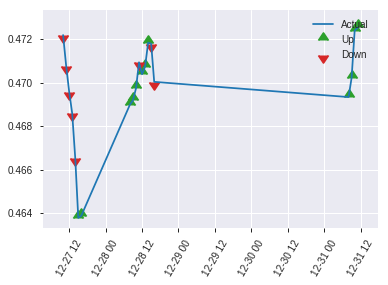


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1931041357668606
RMSE: 0.4394361566449222
LogLoss: 0.5641791800269974
Null degrees of freedom: 222
Residual degrees of freedom: 186
Null deviance: 309.23389543359224
Residual deviance: 251.62391429204084
AIC: 325.6239142920408
AUC: 0.7836793819410913
pr_auc: 0.7634600957143233
Gini: 0.5673587638821826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2628790084522237: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   57   0.5      (57.0/114.0)
1      7    102  0.0642   (7.0/109.0)
Total  64   159  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262879     0.761194  158
max f2                       0.262879     0.857143  158
max f0point5                 0.537197     0.709677  88
max accuracy                 0.285396     0.713004  148
max precision                0.928052     1         0
max recall                   0.0885958    1         210
max specificity              0.928052     1         0
max absolute_mcc             0.262879     0.481553  158
max min_per_class_accuracy   0.419643     0.701754  110
max mean_per_class_accuracy  0.262879     0.71789   158

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.906586           2.04587   2.04587            1                0.913798   1                           0.913798            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.90443            2.04587   2.04587            1                0.905777   1                           0.91059             0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.896039           2.04587   2.04587            1                0.89978    1                           0.907501            0.0183486       0.0642202                  104.587   104.587
    4        0.0403587                   0.895479           2.04587   2.04587            1                0.895778   1                           0.904896            0.0183486       0.0825688                  104.587   104.587
    5        0.0538117                   0.875434           1.36391   1.87538            0.666667         0.882295   0.916667                    0.899246            0.0183486       0.100917                   36.3914   87.5382
    6        0.103139                    0.785552           1.85988   1.86797            0.909091         0.8284     0.913043                    0.865363            0.0917431       0.192661                   85.9883   86.797
    7        0.152466                    0.750579           1.48791   1.74501            0.727273         0.762472   0.852941                    0.832075            0.0733945       0.266055                   48.7907   74.5008
    8        0.201794                    0.705169           1.85988   1.77309            0.909091         0.724488   0.866667                    0.805776            0.0917431       0.357798                   85.9883   77.3089
    9        0.300448                    0.622879           1.20892   1.58784            0.590909         0.667654   0.776119                    0.760422            0.119266        0.477064                   20.8924   58.7841
    10       0.399103                    0.527635           1.30192   1.51716            0.636364         0.578798   0.741573                    0.715526            0.12844         0.605505                   30.1918   51.7163
    11       0.502242                    0.410853           0.97846   1.40654            0.478261         0.475634   0.6875                      0.666263            0.100917        0.706422                   -2.15397  40.6537
    12       0.600897                    0.331997           0.836947  1.31302            0.409091         0.367316   0.641791                    0.617182            0.0825688       0.788991                   -16.3053  31.3022
    13       0.699552                    0.263968           1.30192   1.31146            0.636364         0.296873   0.641026                    0.57201             0.12844         0.917431                   30.1918   31.1456
    14       0.798206                    0.211882           0.278982  1.18385            0.136364         0.236611   0.578652                    0.530556            0.0275229       0.944954                   -72.1018  18.3847
    15       0.896861                    0.162421           0.278982  1.08431            0.136364         0.190752   0.53                        0.493178            0.0275229       0.972477                   -72.1018  8.43119
    16       1                           0.0240376          0.266853  1                  0.130435         0.0888703  0.488789                    

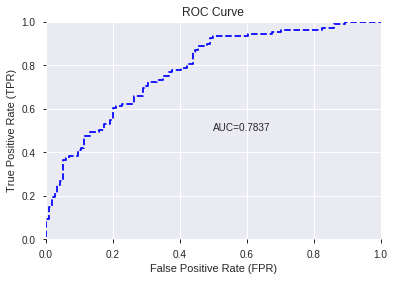

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


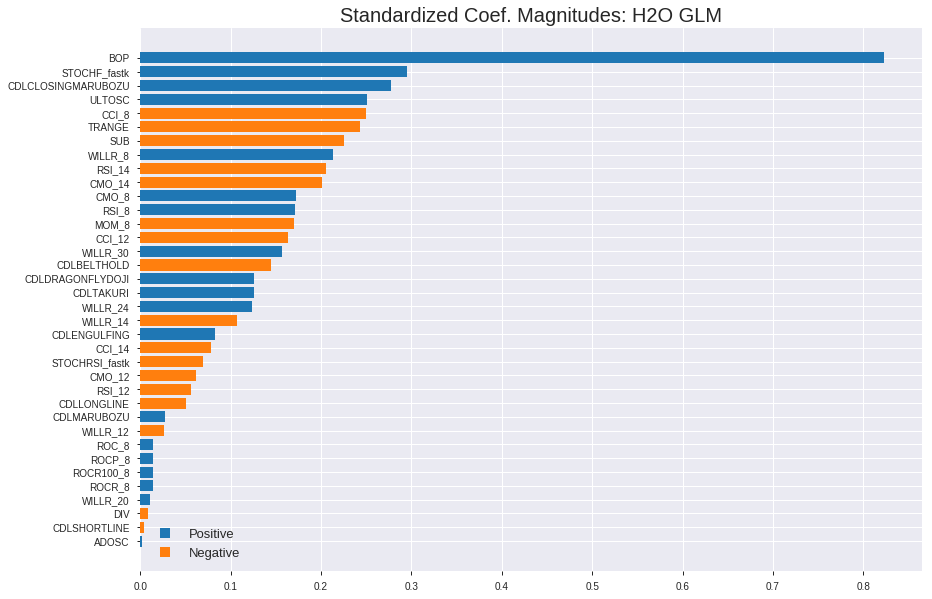

'log_likelihood'
--2019-09-03 04:49:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_044940_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_044940_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CCI_8',
 'TRANGE',
 'SUB',
 'WILLR_8',
 'RSI_14',
 'CMO_14',
 'CMO_8',
 'RSI_8',
 'MOM_8',
 'CCI_12',
 'WILLR_30',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'WILLR_24',
 'WILLR_14',
 'CDLENGULFING',
 'CCI_14',
 'STOCHRSI_fastk',
 'CMO_12',
 'RSI_12',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'WILLR_12',
 'ROC_8',
 'ROCP_8',
 'ROCR100_8',
 'ROCR_8',
 'WILLR_20',
 'DIV',
 'CDLSHORTLINE',
 'ADOSC']

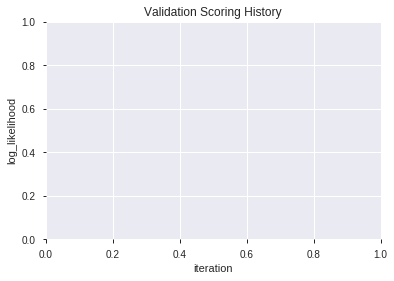

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190903_044951  0.782231  0.570301              0.295872  0.440605  0.194133
1               XGBoost_3_AutoML_20190903_044951  0.771366  0.579138              0.284524  0.445310  0.198301
2  XGBoost_grid_1_AutoML_20190903_044951_model_4  0.770843  0.587172              0.280541  0.449251  0.201826
3  XGBoost_grid_1_AutoML_20190903_044951_model_6  0.770159  0.579461              0.272372  0.445324  0.198313
4               XGBoost_1_AutoML_20190903_044951  0.768147  0.584866              0.289715  0.446741  0.199577
5  XGBoost_grid_1_AutoML_20190903_044951_model_7  0.767423  0.584987              0.310840  0.446032  0.198945
6  XGBoost_grid_1_AutoML_20190903_044951_model_1  0.764365  0.586545              0.356671  0.447608  0.200353
7  XGBoost_grid_1_AutoML_20190903_044951_model_3  0.760905  0.588124              0.281346  0.449367  0.201931
8  XGBoost_grid_1_AutoML_20190903_044951_model_2  0.759617  0.592987              0.305448  0.451191  0.203574
9  XGBoost_grid_1_AutoML_20190903_044951_model_5  0.748270  0.624378              0.335949  0.462223  0.213650

variable  relative_importance  scaled_importance  percentage
0                  BOP          1685.993530           1.000000    0.286999
1               TRANGE           460.487885           0.273126    0.078387
2       STOCHRSI_fastk           402.252808           0.238585    0.068474
3         STOCHF_fastk           351.880859           0.208708    0.059899
4                CCI_8           282.650085           0.167646    0.048114
5                  DIV           264.815552           0.157068    0.045078
6               CCI_12           236.608170           0.140338    0.040277
7                ADOSC           225.862579           0.133964    0.038448
8               ULTOSC           206.559357           0.122515    0.035162
9             WILLR_14           200.662292           0.119017    0.034158
10             WILLR_8           190.667221           0.113089    0.032456
11                 SUB           187.473648           0.111195    0.031913
12            WILLR_30           128.065338           0.075958    0.021800
13            WILLR_24           113.142403           0.067107    0.019260
14               ROC_8           106.662247           0.063264    0.018157
15              CCI_14           106.219765           0.063001    0.018081
16              CMO_14           100.930527           0.059864    0.017181
17            WILLR_12            90.689682           0.053790    0.015438
18               CMO_8            85.356888           0.050627    0.014530
19               MOM_8            82.122391           0.048709    0.013979
20            WILLR_20            60.861938           0.036099    0.010360
21  CDLCLOSINGMARUBOZU            56.057301           0.033249    0.009542
22              ROCP_8            52.986046           0.031427    0.009020
23               RSI_8            43.768173           0.025960    0.007450
24              CMO_12            43.281940           0.025671    0.007368
25              RSI_14            36.193405           0.021467    0.006161
26         CDLBELTHOLD            31.218828           0.018517    0.005314
27              RSI_12            24.890423           0.014763    0.004237
28              ROCR_8            16.195625           0.009606    0.002757

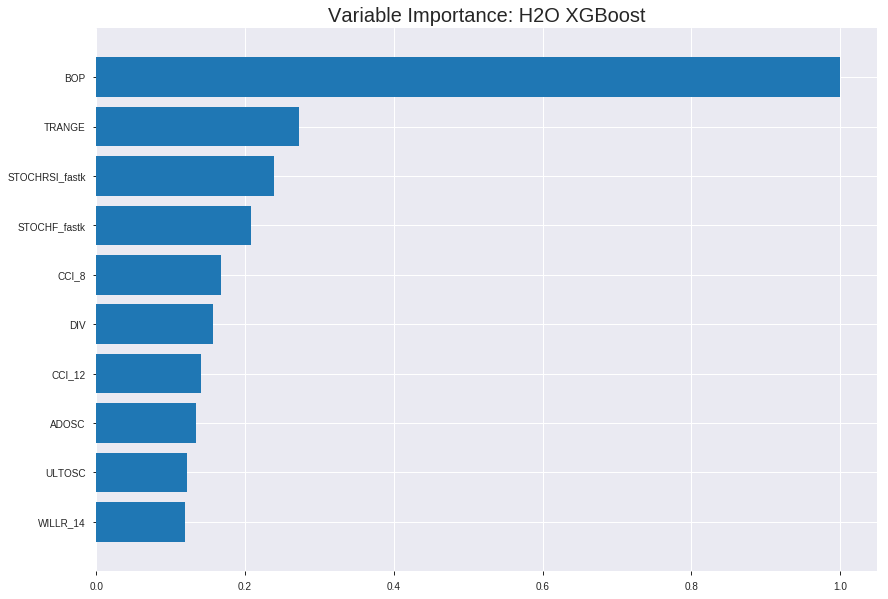

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190903_044951


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15036067997849092
RMSE: 0.3877636908975503
LogLoss: 0.47014321177367924
Mean Per-Class Error: 0.19970089237893562
AUC: 0.879848551017213
pr_auc: 0.8790379611890202
Gini: 0.7596971020344261
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4379608829816182: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      537  236  0.3053   (236.0/773.0)
1      90   695  0.1146   (90.0/785.0)
Total  627  931  0.2092   (326.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437961     0.810023  234
max f2                       0.329469     0.881253  286
max f0point5                 0.567159     0.81157   172
max accuracy                 0.509915     0.800385  198
max precision                0.905651     1         0
max recall                   0.0859573    1         391
max specificity              0.905651     1         0
max absolute_mcc             0.509915     0.600799  198
max min_per_class_accuracy   0.520874     0.796178  192
max mean_per_class_accuracy  0.509915     0.800299  198

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.885318           1.98471    1.98471            1                0.894866  1                           0.894866            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.874635           1.98471    1.98471            1                0.878943  1                           0.886904            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.865891           1.98471    1.98471            1                0.87077   1                           0.881755            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.860704           1.98471    1.98471            1                0.86318   1                           0.877038            0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.851056           1.98471    1.98471            1                0.856004  1                           0.872993            0.0191083       0.0993631                  98.4713   98.4713
    6        0.100128                    0.81242            1.93382    1.95927            0.974359         0.829429  0.987179                    0.851211            0.0968153       0.196178                   93.3823   95.9268
    7        0.150193                    0.77857            1.70482    1.87445            0.858974         0.795312  0.944444                    0.832578            0.0853503       0.281529                   70.4818   87.4452
    8        0.200257                    0.751771           1.8066     1.85749            0.910256         0.765927  0.935897                    0.815915            0.0904459       0.371975                   80.6598   85.7488
    9        0.300385                    0.681889           1.61576    1.77691            0.814103         0.715556  0.895299                    0.782462            0.161783        0.533758                   61.576    77.6912
    10       0.399872                    0.603478           1.42131    1.68844            0.716129         0.643009  0.850722                    0.747766            0.141401        0.675159                   42.1311   68.844
    11       0.5                         0.520438           1.20864    1.59236            0.608974         0.562857  0.802311                    0.710737            0.121019        0.796178                   20.864    59.2357
    12       0.600128                    0.431757           0.903299   1.47739            0.455128         0.477096  0.744385                    0.671755            0.0904459       0.886624                   -9.6701   47.7391
    13       0.699615                    0.350044           0.601816   1.35288            0.303226         0.393434  0.681651                    0.632177            0.0598726       0.946497                   -39.8184  35.2883
    14       0.799743                    0.255112           0.292618   1.22014            0.147436         0.308314  0.614767                    0.59163             0.0292994       0.975796                   -70.7382  22.0137
    15       0.899872                    0.164019           0.20356    1.10702            0.102564         0.207347  0.557775                    0.548871            0.0203822       0.996178                   -79.644   10.7023
    16       1                           0.059851           0.0381676  1                  0.0192308        0.117204  0.503851                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19972166507533148
RMSE: 0.44690229925044184
LogLoss: 0.5858584176771471
Mean Per-Class Error: 0.26705004035512503
AUC: 0.7615819209039548
pr_auc: 0.7326093287448269
Gini: 0.5231638418079096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2687322795391083: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   115  0.5476   (115.0/210.0)
1      19   217  0.0805   (19.0/236.0)
Total  114  332  0.3004   (134.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268732     0.764085  297
max f2                       0.111515     0.861943  381
max f0point5                 0.445067     0.745114  224
max accuracy                 0.445067     0.735426  224
max precision                0.890911     1         0
max recall                   0.111515     1         381
max specificity              0.890911     1         0
max absolute_mcc             0.438993     0.468081  229
max min_per_class_accuracy   0.480732     0.714286  206
max mean_per_class_accuracy  0.445067     0.73295   224

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 47.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.852862           1.88983   1.88983            1                0.878082  1                           0.878082            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.84243            1.41737   1.67985            0.75             0.848936  0.888889                    0.865128            0.0127119       0.0338983                  41.7373   67.9849
    3        0.0313901                   0.835803           1.1339    1.48487            0.6              0.840149  0.785714                    0.856207            0.0127119       0.0466102                  13.3898   48.4867
    4        0.0403587                   0.822106           1.41737   1.46987            0.75             0.826557  0.777778                    0.849618            0.0127119       0.059322                   41.7373   46.9868
    5        0.0515695                   0.80879            1.1339    1.39683            0.6              0.815244  0.73913                     0.842145            0.0127119       0.0720339                  13.3898   39.6831
    6        0.100897                    0.767564           1.28852   1.34388            0.681818         0.787643  0.711111                    0.8155              0.0635593       0.135593                   28.8521   34.3879
    7        0.150224                    0.735615           1.63213   1.43853            0.863636         0.752248  0.761194                    0.79473             0.0805085       0.216102                   63.2126   43.8528
    8        0.201794                    0.698823           1.56116   1.46987            0.826087         0.718848  0.777778                    0.775338            0.0805085       0.29661                    56.1164   46.9868
    9        0.300448                    0.644932           1.37442   1.43853            0.727273         0.673329  0.761194                    0.741843            0.135593        0.432203                   37.4422   43.8528
    10       0.401345                    0.570816           1.34388   1.41473            0.711111         0.603411  0.748603                    0.707042            0.135593        0.567797                   34.3879   41.4733
    11       0.5                         0.486313           1.33147   1.39831            0.704545         0.528864  0.73991                     0.671885            0.131356        0.699153                   33.1471   39.8305
    12       0.600897                    0.414375           1.04991   1.33981            0.555556         0.450444  0.708955                    0.634703            0.105932        0.805085                   4.99058   33.9805
    13       0.699552                    0.319237           0.773112  1.25989            0.409091         0.364513  0.666667                    0.596599            0.0762712       0.881356                   -22.6888  25.9887
    14       0.800448                    0.220028           0.545951  1.1699             0.288889         0.268109  0.619048                    0.555193            0.0550847       0.936441                   -45.4049  16.9895
    15       0.899103                    0.139063           0.300655  1.07452            0.159091         0.170199  0.568579                    0.512949            0.029661        0.966102                   -69.9345  7.45171
    16       1                           0.0706336          0.33597   1                  0.177778         0.113051  0.529148                    0.472601         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:49:53  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.496149                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 04:49:54  0.042 sec   5                  0.474835         0.643785            0.820606        0.811106           1.86797          0.252888                         0.480528           0.65475               0.76023           0.723304             1.51186            0.273543
    2019-09-03 04:49:54  0.078 sec   10                 0.455225         0.605984            0.830843        0.829675           1.98471          0.256739                         0.467885           0.629898              0.761935          0.730293             1.51186            0.273543
    2019-09-03 04:49:54  0.113 sec   15                 0.442051         0.580394            0.838067        0.838443           1.98471          0.256739                         0.460049           0.614295              0.761088          0.732438             1.88983            0.273543
    2019-09-03 04:49:54  0.157 sec   20                 0.430874         0.558401            0.844981        0.844642           1.98471          0.244544                         0.45555            0.604951              0.759685          0.721647             1.1339             0.2713
    2019-09-03 04:49:54  0.198 sec   25                 0.422331         0.541076            0.849458        0.850269           1.98471          0.247112                         0.451494           0.596181              0.761965          0.728328             1.88983            0.269058
    2019-09-03 04:49:54  0.238 sec   30                 0.415337         0.526867            0.853277        0.854209           1.98471          0.241977                         0.451001           0.594865              0.757819          0.725102             1.88983            0.273543
    2019-09-03 04:49:54  0.282 sec   35                 0.408989         0.513975            0.860037        0.859736           1.98471          0.235558                         0.449827           0.591829              0.758111          0.722997             1.51186            0.289238
    2019-09-03 04:49:54  0.328 sec   40                 0.403833         0.50329             0.863928        0.863581           1.98471          0.225289                         0.448035           0.588041              0.761451          0.7287               1.88983            0.278027
    2019-09-03 04:49:54  0.371 sec   45                 0.399711         0.494571            0.866852        0.867621           1.98471          0.226573                         0.448028           0.587943              0.760048          0.723905             1.51186            0.302691
    2019-09-03 04:49:54  0.434 sec   50                 0.395395         0.485671            0.871445        0.871863           1.98471          0.213736                         0.447553           0.58728               0.759362          0.725257             1.51186            0.29148
    2019-09-03 04:49:54  0.490 sec   55                 0.391651         0.477977            0.875478        0.871984           1.98471          0.205392                         0.446718           0.585499              0.761481          0.72

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1685.9935302734375     1.0                   0.2869992677446375
TRANGE          460.4878845214844      0.2731255347384409    0.0783868284722951
STOCHRSI_fastk  402.2528076171875      0.23858502443479093   0.06847372730762144
STOCHF_fastk    351.880859375          0.20870830940729132   0.05989913197211385
CCI_8           282.65008544921875     0.16764600834700596   0.0481142816359021
---             ---                    ---                   ---
CMO_12          43.28194046020508      0.025671474820656955  0.007367694475453445
RSI_14          36.19340515136719      0.021467107970157676  0.006161044268030325
CDLBELTHOLD     31.218828201293945     0.018516576511554476  0.0053142438999536894
RSI_12          24.890422821044922     0.014763059510084922  0.004236987269064879
ROCR_8          16.19562530517578      0.009605983068362751  0.0027569101065874958


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7471698113207547)

('auc', 0.7822308063737324)

('logloss', 0.5703005035077818)

('mean_per_class_error', 0.2837598583615001)

('rmse', 0.44060544092022597)

('mse', 0.19413315456850674)

xgboost prediction progress: |████████████████████████████████████████████| 100%


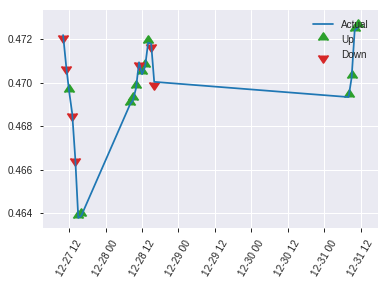


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19413315456850674
RMSE: 0.44060544092022597
LogLoss: 0.5703005035077818
Mean Per-Class Error: 0.2837598583615001
AUC: 0.7822308063737324
pr_auc: 0.745002445664831
Gini: 0.5644616127474649
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2502136528491974: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   57   0.5      (57.0/114.0)
1      10   99   0.0917   (10.0/109.0)
Total  67   156  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250214     0.74717   155
max f2                       0.128847     0.852895  202
max f0point5                 0.519144     0.72043   88
max accuracy                 0.473209     0.717489  97
max precision                0.801015     0.928571  13
max recall                   0.128847     1         202
max specificity              0.8771       0.991228  0
max absolute_mcc             0.250214     0.445143  155
max min_per_class_accuracy   0.415753     0.706422  108
max mean_per_class_accuracy  0.473209     0.71624   97

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.846983           1.36391   1.36391            0.666667         0.858464  0.666667                    0.858464            0.0183486       0.0183486                  36.3914   36.3914
    2        0.0224215                   0.835792           2.04587   1.6367             1                0.841689  0.8                         0.851754            0.0183486       0.0366972                  104.587   63.6697
    3        0.0313901                   0.820468           2.04587   1.7536             1                0.828317  0.857143                    0.845058            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.811035           2.04587   1.81855            1                0.815282  0.888889                    0.838441            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.806177           2.04587   1.87538            1                0.808625  0.916667                    0.830987            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.778159           1.67389   1.77902            0.818182         0.78906   0.869565                    0.810935            0.0825688       0.183486                   67.3895   77.9019
    7        0.152466                    0.748822           1.85988   1.80518            0.909091         0.766379  0.882353                    0.79652             0.0917431       0.275229                   85.9883   80.5181
    8        0.201794                    0.718542           1.30192   1.68216            0.636364         0.7373    0.822222                    0.782044            0.0642202       0.33945                    30.1918   68.2161
    9        0.300448                    0.613155           1.48791   1.61838            0.727273         0.656941  0.791045                    0.740966            0.146789        0.486239                   48.7907   61.8376
    10       0.399103                    0.513356           1.30192   1.54015            0.636364         0.564619  0.752809                    0.697374            0.12844         0.614679                   30.1918   54.015
    11       0.502242                    0.406627           0.97846   1.4248             0.478261         0.456827  0.696429                    0.647976            0.100917        0.715596                   -2.15397  42.4803
    12       0.600897                    0.341913           0.929942  1.34356            0.454545         0.373637  0.656716                    0.602935            0.0917431       0.807339                   -7.00584  34.3557
    13       0.699552                    0.247519           1.02294   1.29834            0.5              0.283947  0.634615                    0.55795             0.100917        0.908257                   2.29358   29.8342
    14       0.798206                    0.181375           0.278982  1.17235            0.136364         0.211536  0.573034                    0.515135            0.0275229       0.93578                    -72.1018  17.2353
    15       0.896861                    0.134008           0.464971  1.09454            0.227273         0.157596  0.535                       0.475805            0.0458716       0.981651                   -53.5029  9.45413
    16       1                           0.0755601          0.177902  1                  0.0869565        0.107648  0.488789                    0.437834          

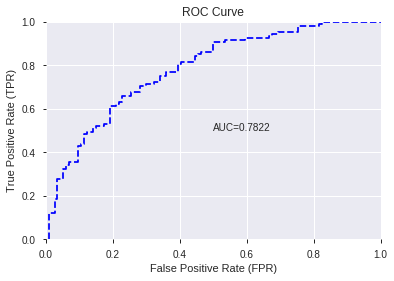

This function is available for GLM models only


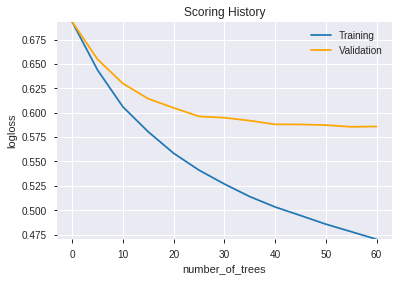

--2019-09-03 04:50:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


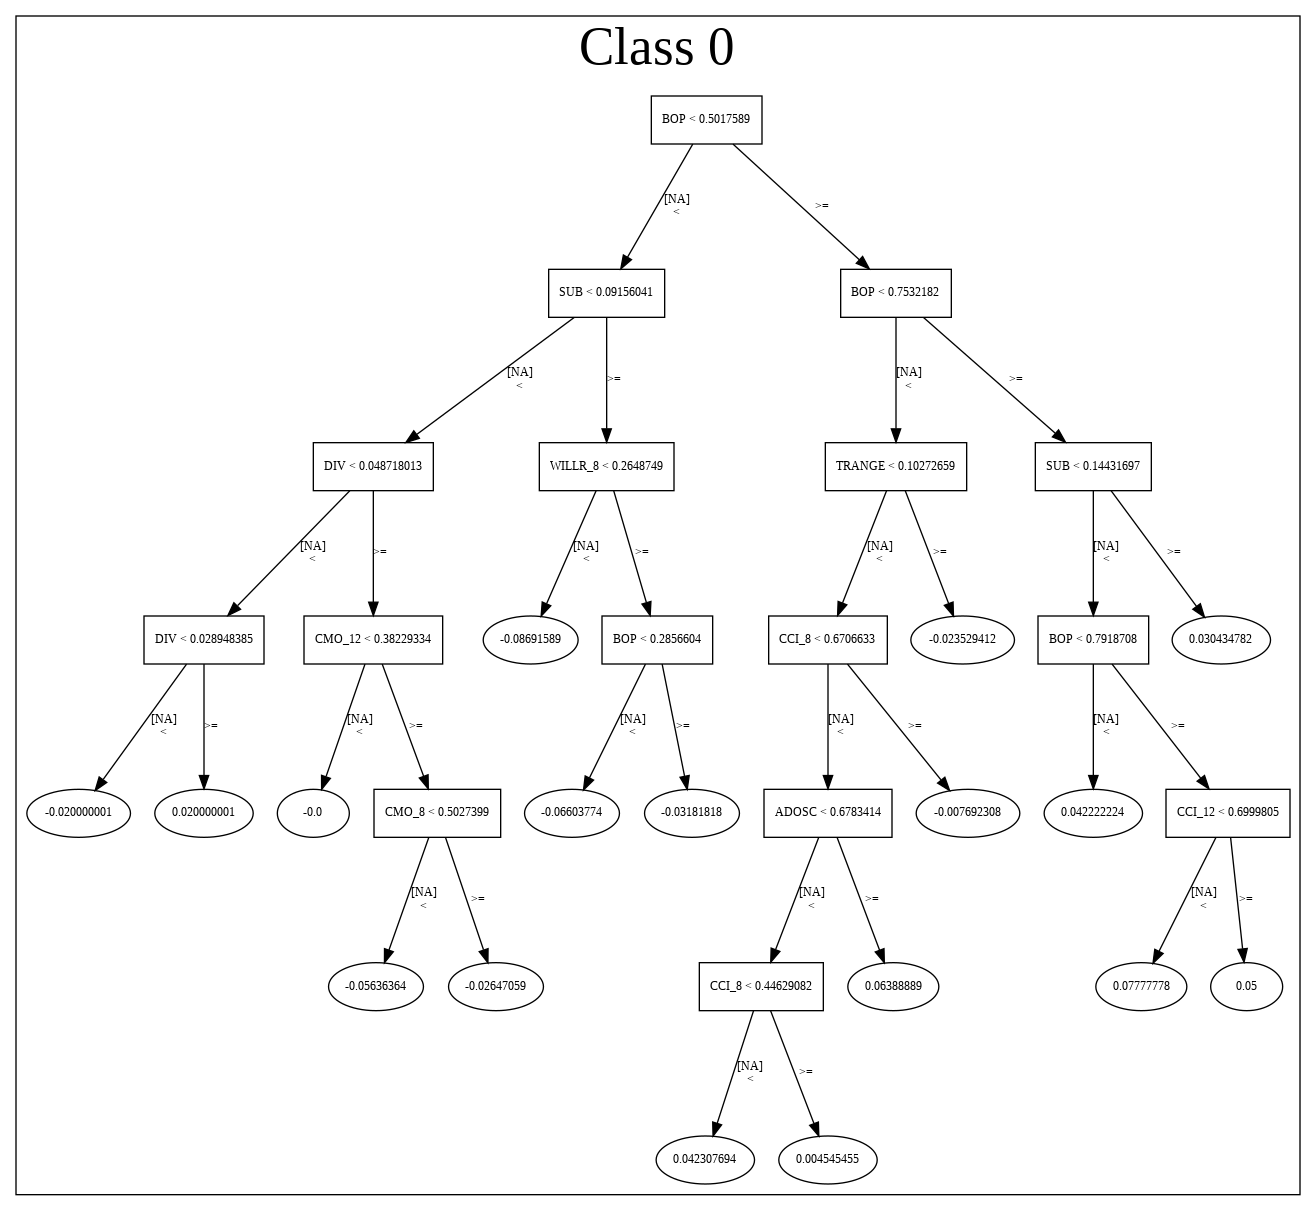

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190903_044951',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190903_044951',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b794',
   'type

['BOP',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CCI_8',
 'DIV',
 'CCI_12',
 'ADOSC',
 'ULTOSC',
 'WILLR_14',
 'WILLR_8',
 'SUB',
 'WILLR_30',
 'WILLR_24',
 'ROC_8',
 'CCI_14',
 'CMO_14',
 'WILLR_12',
 'CMO_8',
 'MOM_8',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'ROCP_8',
 'RSI_8',
 'CMO_12',
 'RSI_14',
 'CDLBELTHOLD',
 'RSI_12',
 'ROCR_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

164

['BBANDS_lowerband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'MA_14_7',
 'MAVP_14_7',
 'BBANDS_upperband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_7_5',
 'KAMA_20',
 'SAR_0.2',
 'TRIMA_20',
 'BBANDS_middleband_20_0_2',
 'BBANDS_lowerband_20_0_2',
 'BBANDS_upperband_20_0_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_middleband_20_0_5',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_middleband_20_1_2',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_1_5',
 'BBANDS_upperband_20_2_4',
 'BBANDS_middleband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'MAVP_20_3',
 'BBANDS_middleband_20_3_2',
 'BBANDS_lowerband_20_3_3',
 'BBANDS_lowerband_20_3_4',
 'MAVP_20_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_7_2',
 'BBANDS_upperband_20_7_3',
 'BBANDS_middleband_20_7_4',
 'BBANDS_lowerband_20_7_4',
 'BBA

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_045119_model_8  0.778287  0.581989              0.347900  0.447684  0.200421
1  DeepLearning_grid_1_AutoML_20190903_045119_model_9  0.765009  0.579615              0.319210  0.444764  0.197815
2  DeepLearning_grid_1_AutoML_20190903_045119_model_7  0.757122  0.670685              0.302873  0.473630  0.224326
3  DeepLearning_grid_1_AutoML_20190903_045119_model_5  0.752133  0.600490              0.310035  0.453588  0.205742
4  DeepLearning_grid_1_AutoML_20190903_045119_model_3  0.751811  0.666872              0.336150  0.469223  0.220170
5               DeepLearning_1_AutoML_20190903_045119  0.749396  0.655012              0.306655  0.464997  0.216222
6  DeepLearning_grid_1_AutoML_20190903_045119_model_6  0.748270  0.592747              0.315025  0.451677  0.204012
7  DeepLearning_grid_1_AutoML_20190903_045119_model_4  0.738210  1.205368              0.329189  0.564063  0.318167
8  DeepLearning_grid_1_AutoML_20190903_045119_model_1  0.717769  1.191759              0.359086  0.542406  0.294204
9  DeepLearning_grid_1_AutoML_20190903_045119_model_2  0.667713  0.880843              0.384999  0.527877  0.278654

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             1.000000           1.000000    0.020279
1                         BOP             0.968466           0.968466    0.019639
2          CDLCLOSINGMARUBOZU             0.846261           0.846261    0.017161
3                   CDLTAKURI             0.628737           0.628737    0.012750
4                       ADOSC             0.509198           0.509198    0.010326
..                        ...                  ...                ...         ...
159  BBANDS_middleband_30_6_5             0.221278           0.221278    0.004487
160   BBANDS_lowerband_20_0_5             0.221092           0.221092    0.004484
161                   MA_14_7             0.217144           0.217144    0.004403
162                  TRIMA_20             0.216994           0.216994    0.004400
163  BBANDS_middleband_20_2_4             0.211493           0.211493    0.004289

[164 rows x 4 columns]

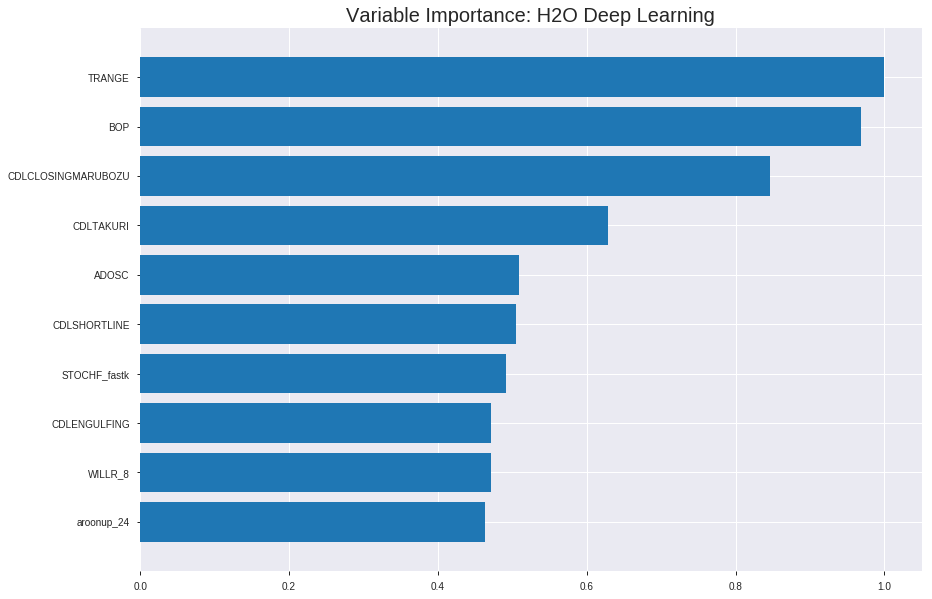

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_045119_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17658626596191346
RMSE: 0.4202216866868171
LogLoss: 0.5189804584775012
Mean Per-Class Error: 0.2731528250426414
AUC: 0.8151012269180379
pr_auc: 0.8176254058776891
Gini: 0.6302024538360758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3206917311106269: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  398   0.5149   (398.0/773.0)
1      55   730   0.0701   (55.0/785.0)
Total  430  1128  0.2908   (453.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320692     0.763199  273
max f2                       0.122611     0.861688  351
max f0point5                 0.556677     0.739615  156
max accuracy                 0.479277     0.727214  204
max precision                0.999228     1         0
max recall                   0.0667638    1         374
max specificity              0.999228     1         0
max absolute_mcc             0.320692     0.464244  273
max min_per_class_accuracy   0.50562      0.717197  188
max mean_per_class_accuracy  0.479277     0.726847  204

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 47.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.992718           1.98471    1.98471            1                0.996749   1                           0.996749            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.98223            1.98471    1.98471            1                0.987893   1                           0.992321            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.971561           1.98471    1.98471            1                0.977851   1                           0.987703            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.94877            1.98471    1.98471            1                0.960702   1                           0.980846            0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.938021           1.8524     1.95927            0.933333         0.943586   0.987179                    0.97368             0.0178344       0.0980892                  85.2399   95.9268
    6        0.100128                    0.81882            1.90838    1.93382            0.961538         0.887426   0.974359                    0.930553            0.0955414       0.193631                   90.8378   93.3823
    7        0.150193                    0.712276           1.62848    1.83204            0.820513         0.759028   0.923077                    0.873378            0.0815287       0.275159                   62.8483   83.2043
    8        0.200257                    0.636423           1.70482    1.80024            0.858974         0.670159   0.907051                    0.822573            0.0853503       0.36051                    70.4818   80.0237
    9        0.300385                    0.572824           1.2977     1.63272            0.653846         0.60224    0.82265                     0.749129            0.129936        0.490446                   29.7697   63.2724
    10       0.399872                    0.541864           1.19083    1.52278            0.6              0.555925   0.767255                    0.70106             0.118471        0.608917                   19.0828   52.2782
    11       0.5                         0.505517           1.08141    1.43439            0.544872         0.52699    0.722721                    0.666202            0.10828         0.717197                   8.14143   43.4395
    12       0.600128                    0.434144           1.05597    1.37126            0.532051         0.474209   0.690909                    0.634169            0.105732        0.82293                    5.59693   37.1257
    13       0.699615                    0.339506           0.845104   1.29644            0.425806         0.387842   0.653211                    0.59914             0.0840764       0.907006                   -15.4896  29.6437
    14       0.799743                    0.233              0.508901   1.19784            0.25641          0.292593   0.603531                    0.560761            0.0509554       0.957962                   -49.1099  19.7837
    15       0.899872                    0.107674           0.368953   1.10561            0.185897         0.174873   0.557061                    0.517823            0.0369427       0.994904                   -63.1047  10.5607
    16       1                           0.00431413         0.0508901  1                  0.025641         0.0547337  0.503851 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2105006844288694
RMSE: 0.45880353576326044
LogLoss: 0.614045621384423
Mean Per-Class Error: 0.2887610976594027
AUC: 0.7634382566585957
pr_auc: 0.7536951881201425
Gini: 0.5268765133171913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31373624878931766: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  93   0.4429   (93.0/210.0)
1      35   201  0.1483   (35.0/236.0)
Total  152  294  0.287    (128.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313736     0.758491  256
max f2                       0.0513651    0.863836  377
max f0point5                 0.419384     0.729167  201
max accuracy                 0.335058     0.717489  248
max precision                0.999191     1         0
max recall                   0.0513651    1         377
max specificity              0.999191     1         0
max absolute_mcc             0.335058     0.436389  248
max min_per_class_accuracy   0.419384     0.709524  201
max mean_per_class_accuracy  0.401057     0.711239  211

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 43.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.993009           1.88983   1.88983            1                0.997023   1                           0.997023            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.987677           1.88983   1.88983            1                0.990088   1                           0.993941            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.9812             1.51186   1.75484            0.8              0.984994   0.928571                    0.990746            0.0169492       0.0550847                  51.1864   75.4843
    4        0.0403587                   0.971499           1.41737   1.67985            0.75             0.976225   0.888889                    0.987519            0.0127119       0.0677966                  41.7373   67.9849
    5        0.0515695                   0.948319           1.51186   1.64333            0.8              0.962184   0.869565                    0.982011            0.0169492       0.0847458                  51.1864   64.3331
    6        0.100897                    0.846624           1.80393   1.72185            0.954545         0.900855   0.911111                    0.942335            0.0889831       0.173729                   80.3929   72.1846
    7        0.150224                    0.737115           1.20262   1.55135            0.636364         0.795439   0.820896                    0.8941              0.059322        0.233051                   20.2619   55.1353
    8        0.201794                    0.635758           1.15033   1.44887            0.608696         0.670081   0.766667                    0.836851            0.059322        0.292373                   15.0332   44.887
    9        0.300448                    0.537244           1.58918   1.49494            0.840909         0.574484   0.791045                    0.750701            0.15678         0.449153                   58.9176   49.4941
    10       0.401345                    0.49359            1.1339    1.40418            0.6              0.515579   0.743017                    0.691592            0.114407        0.563559                   13.3898   40.4176
    11       0.5                         0.430127           1.24557   1.37288            0.659091         0.457729   0.726457                    0.645449            0.122881        0.686441                   24.557    37.2881
    12       0.600897                    0.358876           1.04991   1.31865            0.555556         0.39312    0.697761                    0.60308             0.105932        0.792373                   4.99058   31.865
    13       0.699552                    0.287211           0.816063  1.24777            0.431818         0.322689   0.660256                    0.563538            0.0805085       0.872881                   -18.3937  24.7773
    14       0.800448                    0.199651           0.587947  1.1646             0.311111         0.243806   0.616246                    0.523235            0.059322        0.932203                   -41.2053  16.4601
    15       0.899103                    0.0913926          0.386556  1.07923            0.204545         0.138641   0.571072                    0.481035            0.0381356       0.970339                   -61.3444  7.92299
    16       1                           0.00116694         0.293974  1                  0.155556         0.0458964  0.529148                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:56:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 04:56:48  1 min 10.719 sec  620 obs/sec       0.539795  1             841        0.492828         0.713191            0.0284257      0.686991        0.690292           1.86067          0.435173                         0.493453           0.706816              0.0226947        0.683263          0.67395              1.1339             0.347534
    2019-09-03 04:56:58  1 min 20.943 sec  883 obs/sec       5.98524   11            9325       0.436366         0.5617              0.238293       0.784876        0.780241           1.98471          0.311297                         0.461335           0.627332              0.145775         0.749163          0.738701             1.88983            0.302691
    2019-09-03 04:57:09  1 min 31.349 sec  980 obs/sec       12.5494   23            19552      0.43259          0.549837            0.251418       0.798069        0.795077           1.98471          0.29525                          0.464815           0.630859              0.132839         0.757587          0.748753             1.88983            0.311659
    2019-09-03 04:57:19  1 min 41.855 sec  1064 obs/sec      20.1874   37            31452      0.423596         0.529837            0.282224       0.812328        0.810157           1.98471          0.299101                         0.457868           0.629191              0.158567         0.754187          0.744859             1.88983            0.29148
    2019-09-03 04:57:29  1 min 51.001 sec  1128 obs/sec      27.3594   50            42626      0.420222         0.51898             0.293613       0.815101        0.817625           1.98471          0.290757                         0.458804           0.614046              0.155126         0.763438          0.753695             1.88983            0.286996
    2019-09-03 04:57:38  2 min  0.387 sec  1178 obs/sec      34.9743   64            54490      0.407297         0.491701            0.336398       0.840266        0.843662           1.98471          0.278562                         0.45851            0.625054              0.156207         0.750817          0.735019             1.88983            0.284753
    2019-09-03 04:57:47  2 min  9.669 sec  1200 obs/sec      42.0533   77            65519      0.401465         0.476844            0.355266       0.844316        0.82963            1.98471          0.279204                         0.47087            0.659943              0.110102         0.739225          0.732042             1.88983            0.356502
    2019-09-03 04:57:48  2 min 10.623 sec  1199 obs/sec      42.0533   77            65519      0.420222         0.51898             0.293613       0.815101        0.817625           1.98471          0.290757                         0.458804           0.614046              0.155126         0.763438          0.753695             1.88983            0.286996

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
TRANGE                    1.0                    1.0                  0.020278978137316855
BOP                       0.9684658646583557     0.9684658646583557   0.01963949809614446
CDLCLOSINGMARUBOZU        0.8462610840797424     0.8462610840797424   0.017161310022515155
CDLTAKURI                 0.6287367343902588     0.6287367343902588   0.012750138490828051
ADOSC                     0.5091983675956726     0.5091983675956726   0.010326022564030075
---                       ---                    ---                  ---
BBANDS_middleband_30_6_5  0.2212778776884079     0.2212778776884079   0.004487289243915097
BBANDS_lowerband_20_0_5   0.2210923433303833     0.2210923433303833   0.004483526796724995
MA_14_7                   0.21714438498020172    0.21714438498020172  0.004403466235654625
TRIMA_20                  0.216993510723114      0.216993510723114    0.00440040665989366
BBANDS_middleband_20_2_4  0.2114930897951126     0.2114930897951126   0.004288863744148679


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7208480565371025)

('auc', 0.7782874617737003)

('logloss', 0.5819889647384818)

('mean_per_class_error', 0.2811846129084179)

('rmse', 0.4476840888775226)

('mse', 0.20042104343409756)

deeplearning prediction progress: |███████████████████████████████████████| 100%


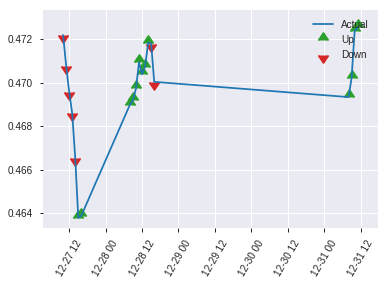


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20042104343409756
RMSE: 0.4476840888775226
LogLoss: 0.5819889647384818
Mean Per-Class Error: 0.2811846129084179
AUC: 0.7782874617737003
pr_auc: 0.7715122214036078
Gini: 0.5565749235474007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23737495524419064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   72   0.6316   (72.0/114.0)
1      7    102  0.0642   (7.0/109.0)
Total  49   174  0.3543   (79.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237375     0.720848  173
max f2                       0.131535     0.84252   198
max f0point5                 0.487501     0.743405  76
max accuracy                 0.487501     0.721973  76
max precision                0.998281     1         0
max recall                   0.0693301    1         214
max specificity              0.998281     1         0
max absolute_mcc             0.487501     0.459676  76
max min_per_class_accuracy   0.369551     0.701754  110
max mean_per_class_accuracy  0.481181     0.718815  78

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 41.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.996872           2.04587   2.04587            1                0.997591   1                           0.997591            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.995501           2.04587   2.04587            1                0.9963     1                           0.997075            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.993578           2.04587   2.04587            1                0.994859   1                           0.996441            0.0183486       0.0642202                  104.587   104.587
    4        0.0403587                   0.98365            2.04587   2.04587            1                0.991352   1                           0.99531             0.0183486       0.0825688                  104.587   104.587
    5        0.0538117                   0.942679           2.04587   2.04587            1                0.957491   1                           0.985856            0.0275229       0.110092                   104.587   104.587
    6        0.103139                    0.78319            1.48791   1.77902            0.727273         0.902204   0.869565                    0.945848            0.0733945       0.183486                   48.7907   77.9019
    7        0.152466                    0.621374           1.85988   1.80518            0.909091         0.690792   0.882353                    0.86333             0.0917431       0.275229                   85.9883   80.5181
    8        0.201794                    0.569617           1.48791   1.72762            0.727273         0.586416   0.844444                    0.79564             0.0733945       0.348624                   48.7907   72.7625
    9        0.300448                    0.526534           1.48791   1.64891            0.727273         0.545658   0.80597                     0.713556            0.146789        0.495413                   48.7907   64.8911
    10       0.399103                    0.438821           1.02294   1.49418            0.5              0.487285   0.730337                    0.657624            0.100917        0.59633                    2.29358   49.4176
    11       0.502242                    0.366708           1.06741   1.40654            0.521739         0.402409   0.6875                      0.605214            0.110092        0.706422                   6.74112   40.6537
    12       0.600897                    0.308344           0.836947  1.31302            0.409091         0.337267   0.641791                    0.561223            0.0825688       0.788991                   -16.3053  31.3022
    13       0.699552                    0.268596           0.650959  1.21965            0.318182         0.289337   0.596154                    0.52288             0.0642202       0.853211                   -34.9041  21.9654
    14       0.798206                    0.223074           0.929942  1.18385            0.454545         0.245411   0.578652                    0.488586            0.0917431       0.944954                   -7.00584  18.3847
    15       0.896861                    0.130138           0.371977  1.09454            0.181818         0.169558   0.535                       0.453493            0.0366972       0.981651                   -62.8023  9.45413
    16       1                           0.014614           0.177902  1                  0.0869565        0.0831239  0.488789                   

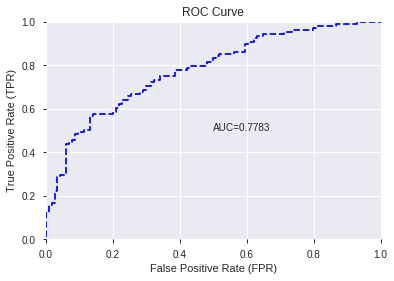

This function is available for GLM models only


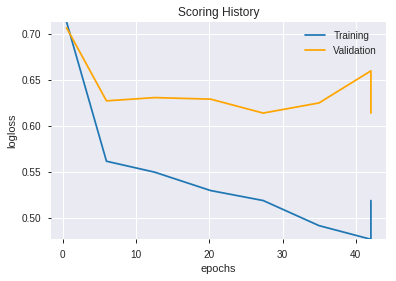

--2019-09-03 04:58:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


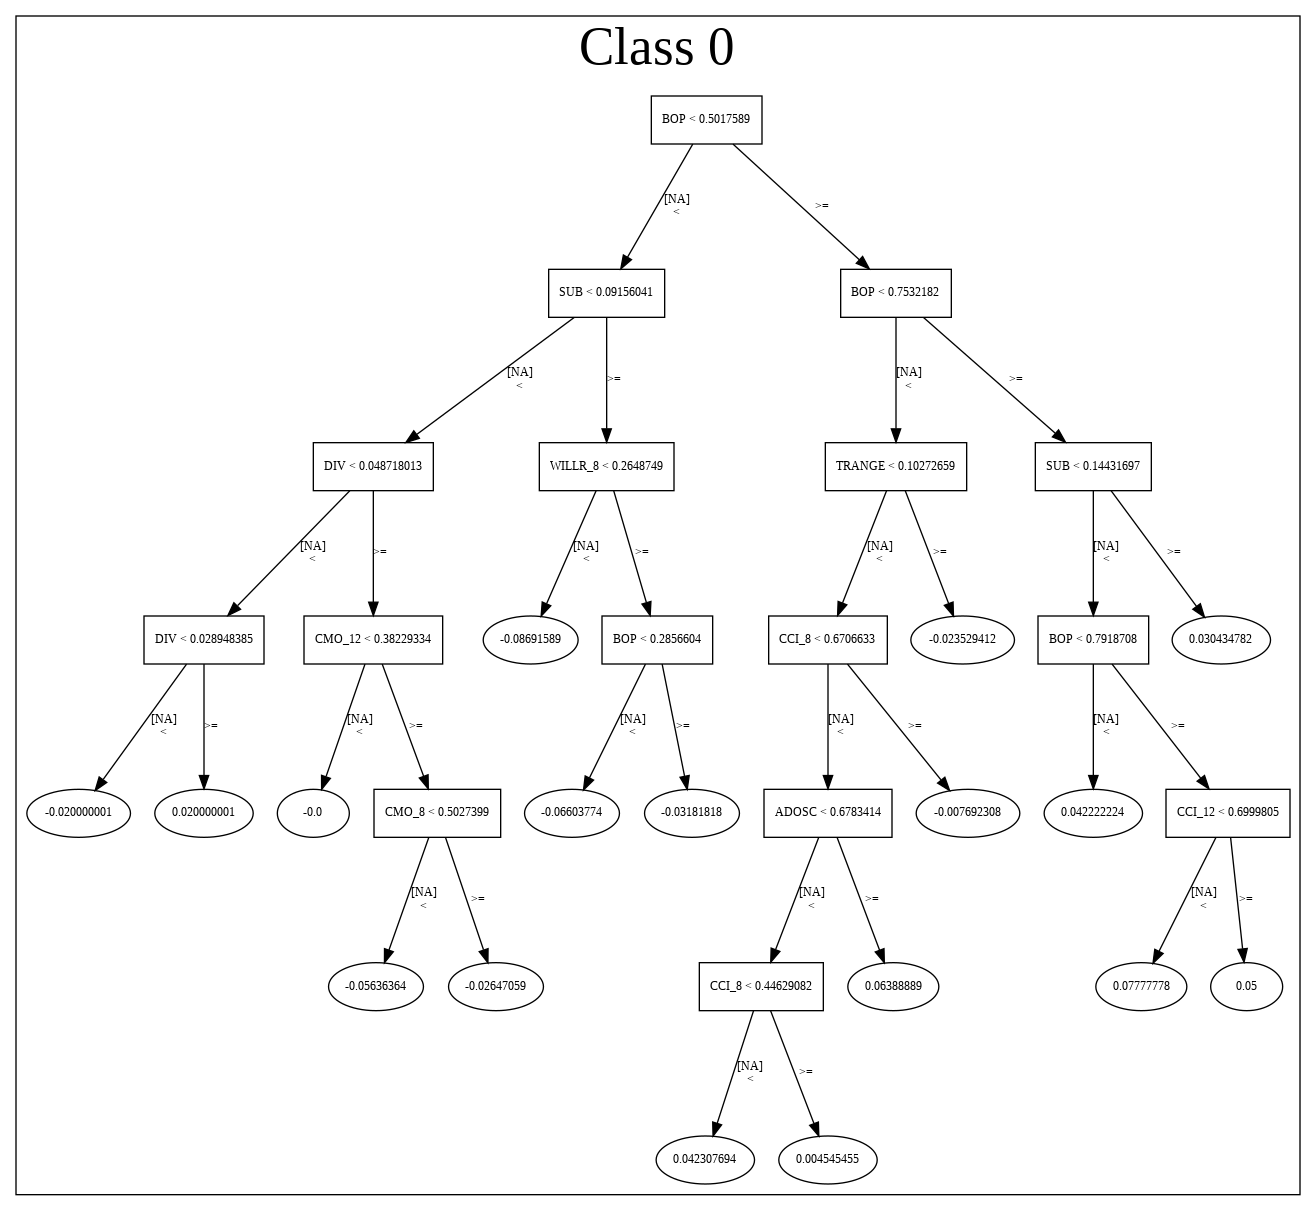

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_045119_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_045119_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'ADOSC',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'CDLENGULFING',
 'WILLR_8',
 'aroonup_24',
 'MFI_30',
 'BETA_12',
 'aroonup_20',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'aroondown_12',
 'PLUS_DI_12',
 'HT_TRENDMODE',
 'MFI_24',
 'aroondown_24',
 'HT_PHASOR_quadrature',
 'MFI_20',
 'ADX_8',
 'DX_14',
 'DX_20',
 'STOCHRSI_fastd',
 'CDLDOJI',
 'AROONOSC_20',
 'aroondown_8',
 'ADX_14',
 'CCI_8',
 'CDLSPINNINGTOP',
 'ADXR_12',
 'aroondown_20',
 'STOCH_slowk',
 'PLUS_DI_24',
 'CDLHAMMER',
 'CDLHIGHWAVE',
 'HT_PHASOR_inphase',
 'CCI_12',
 'DX_30',
 'AROONOSC_8',
 'ADXR_14',
 'CDL3OUTSIDE',
 'WILLR_12',
 'CCI_14',
 'ROC_8',
 'STDDEV_8',
 'CDLHARAMI',
 'ROCR100_8',
 'ADX_24',
 'STOCHF_fastd',
 'MACDFIX_signal_24',
 'WILLR_30',
 'VAR_8',
 'ATR_24',
 'NATR_8',
 'ROCP_8',
 'WILLR_24',
 'OBV',
 'ATR_30',
 'MINUS_DM_20',
 'PLUS_DI_20',
 'CCI_30',
 'PLUS_DI_30',
 'MACDFIX_signal_20',
 'MINUS_DI_30',
 'PLUS_DM_24',
 'ATR_20',
 'ATR_14',
 'ROCP_12',
 'RO

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_045903_model_1  0.780782  0.574576              0.309029  0.441932  0.195304

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.361940           1.000000    0.080891
1                      TRANGE             0.259079           0.715808    0.057902
2          CDLCLOSINGMARUBOZU             0.222431           0.614553    0.049712
3                STOCHF_fastk             0.172284           0.476001    0.038504
4                   CDLTAKURI             0.142220           0.392939    0.031785
..                        ...                  ...                ...         ...
159  BBANDS_middleband_30_2_3             0.000257           0.000711    0.000058
160  BBANDS_middleband_24_0_5             0.000236           0.000652    0.000053
161  BBANDS_middleband_20_1_2             0.000164           0.000454    0.000037
162  BBANDS_middleband_20_2_4             0.000124           0.000342    0.000028
163  BBANDS_middleband_24_1_2             0.000007           0.000020    0.000002

[164 rows x 4 columns]

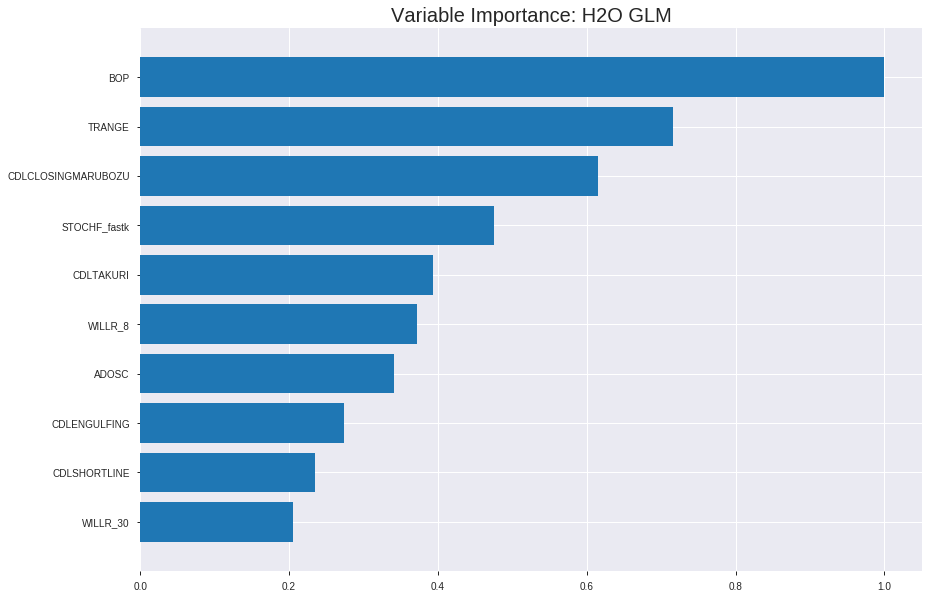

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_045903_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19214861782552267
RMSE: 0.4383475993153409
LogLoss: 0.5662225581195688
Null degrees of freedom: 1557
Residual degrees of freedom: 1393
Null deviance: 2159.7541875235074
Residual deviance: 1764.3494911005764
AIC: 2094.3494911005764
AUC: 0.782899778347245
pr_auc: 0.7796796978024615
Gini: 0.56579955669449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4185413058872475: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      415  358   0.4631   (358.0/773.0)
1      117  668   0.149    (117.0/785.0)
Total  532  1026  0.3049   (475.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418541     0.737714  243
max f2                       0.21468      0.851811  344
max f0point5                 0.543505     0.719791  171
max accuracy                 0.543505     0.710526  171
max precision                0.918388     1         0
max recall                   0.110061     1         384
max specificity              0.918388     1         0
max absolute_mcc             0.543505     0.423296  171
max min_per_class_accuracy   0.522498     0.707006  184
max mean_per_class_accuracy  0.543505     0.71087   171

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.866978           1.86067   1.86067            0.9375           0.886733  0.9375                      0.886733            0.0191083       0.0191083                  86.0669   86.0669
    2        0.0205392                   0.846706           1.86067   1.86067            0.9375           0.858249  0.9375                      0.872491            0.0191083       0.0382166                  86.0669   86.0669
    3        0.0301669                   0.837579           1.98471   1.90026            1                0.842495  0.957447                    0.862918            0.0191083       0.0573248                  98.4713   90.0257
    4        0.0404365                   0.823178           1.86067   1.8902             0.9375           0.830899  0.952381                    0.854786            0.0191083       0.0764331                  86.0669   89.0203
    5        0.0500642                   0.812947           1.72008   1.85749            0.866667         0.817756  0.935897                    0.847665            0.0165605       0.0929936                  72.0085   85.7488
    6        0.100128                    0.759299           1.78115   1.81932            0.897436         0.788174  0.916667                    0.817919            0.089172        0.182166                   78.1153   81.9321
    7        0.150193                    0.71783            1.65393   1.76419            0.833333         0.736291  0.888889                    0.79071             0.0828025       0.264968                   65.3928   76.419
    8        0.200257                    0.686677           1.42492   1.67937            0.717949         0.701307  0.846154                    0.768359            0.0713376       0.336306                   42.4922   67.9373
    9        0.300385                    0.631142           1.4122    1.59032            0.711538         0.65761   0.801282                    0.731443            0.141401        0.477707                   41.22     59.0315
    10       0.399872                    0.579846           1.22924   1.50048            0.619355         0.604841  0.756019                    0.699945            0.122293        0.6                        22.9242   50.0482
    11       0.5                         0.522428           1.05597   1.41146            0.532051         0.549227  0.711168                    0.669762            0.105732        0.705732                   5.59693   41.1465
    12       0.600128                    0.453879           0.916022  1.3288             0.461538         0.48844   0.669519                    0.63951             0.0917197       0.797452                   -8.39784  32.8803
    13       0.699615                    0.391146           0.793885  1.25274            0.4              0.423616  0.631193                    0.608809            0.0789809       0.876433                   -20.6115  25.2737
    14       0.799743                    0.315183           0.597959  1.17076            0.301282         0.353459  0.589888                    0.576839            0.0598726       0.936306                   -40.2041  17.0758
    15       0.899872                    0.219684           0.483456  1.09428            0.24359          0.270441  0.551355                    0.542747            0.0484076       0.984713                   -51.6544  9.42821
    16       1                           0.0323972          0.15267   1                  0.0769231        0.154291  0.503851                    0.503851          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20601629497174692
RMSE: 0.4538901794176064
LogLoss: 0.5967856812522603
Null degrees of freedom: 445
Residual degrees of freedom: 281
Null deviance: 617.9132227761654
Residual deviance: 532.3328276770162
AIC: 862.3328276770162
AUC: 0.7588781275221953
pr_auc: 0.762799754439704
Gini: 0.5177562550443906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3247380540303837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  109  0.519    (109.0/210.0)
1      30   206  0.1271   (30.0/236.0)
Total  131  315  0.3117   (139.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324738     0.747731  285
max f2                       0.10888      0.863204  377
max f0point5                 0.47676      0.730337  192
max accuracy                 0.47676      0.704036  192
max precision                0.869006     1         0
max recall                   0.10888      1         377
max specificity              0.869006     1         0
max absolute_mcc             0.47676      0.413632  192
max min_per_class_accuracy   0.446623     0.695238  211
max mean_per_class_accuracy  0.47676      0.706699  192

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 44.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.832706           1.88983   1.88983            1                0.849879  1                           0.849879            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.819927           1.88983   1.88983            1                0.825451  1                           0.839022            0.0169492       0.0381356                  88.9831   88.9831
    3        0.0313901                   0.792073           1.88983   1.88983            1                0.809526  1                           0.828488            0.0211864       0.059322                   88.9831   88.9831
    4        0.0403587                   0.778501           0.944915  1.67985            0.5              0.785633  0.888889                    0.818964            0.00847458      0.0677966                  -5.50847  67.9849
    5        0.0515695                   0.763861           1.88983   1.7255             1                0.772357  0.913043                    0.808832            0.0211864       0.0889831                  88.9831   72.5497
    6        0.100897                    0.699477           1.37442   1.55386            0.727273         0.736642  0.822222                    0.773539            0.0677966       0.15678                    37.4422   55.3861
    7        0.150224                    0.66831            1.63213   1.57956            0.863636         0.682278  0.835821                    0.743573            0.0805085       0.237288                   63.2126   57.956
    8        0.201794                    0.63153            1.39683   1.53286            0.73913          0.649568  0.811111                    0.719549            0.0720339       0.309322                   39.6831   53.2863
    9        0.300448                    0.572131           1.46032   1.50904            0.772727         0.600461  0.798507                    0.680446            0.144068        0.45339                    46.0324   50.9044
    10       0.401345                    0.522624           1.21789   1.43585            0.644444         0.547056  0.759777                    0.646912            0.122881        0.576271                   21.7891   43.5849
    11       0.5                         0.452027           1.07377   1.36441            0.568182         0.487132  0.721973                    0.615386            0.105932        0.682203                   7.37673   36.4407
    12       0.600897                    0.396394           0.839925  1.27634            0.444444         0.424881  0.675373                    0.583398            0.0847458       0.766949                   -16.0075  27.6341
    13       0.699552                    0.32883            0.944915  1.2296             0.5              0.359544  0.650641                    0.551829            0.0932203       0.860169                   -5.50847  22.9601
    14       0.800448                    0.265914           0.545951  1.14343            0.288889         0.298729  0.605042                    0.519926            0.0550847       0.915254                   -45.4049  14.3427
    15       0.899103                    0.160545           0.60131   1.08394            0.318182         0.215182  0.573566                    0.486487            0.059322        0.974576                   -39.869   8.39427
    16       1                           0.0117887          0.251977  1                  0.133333         0.10486   0.529148                    0.447982          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 04:59:04  0.000 sec   2            .2E2      165           1.366707475218825   1.3677818746211712
     2019-09-03 04:59:04  0.066 sec   4            .15E2     165           1.361001914911173   1.3625402835686635
     2019-09-03 04:59:04  0.127 sec   6            .11E2     165           1.3539296720999041  1.356021484235763
     2019-09-03 04:59:04  0.186 sec   8            .78E1     165           1.345301517176862   1.348081388291748
     2019-09-03 04:59:04  0.244 sec   10           .57E1     165           1.3349238242596733  1.3385721825764993
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 04:59:05  1.099 sec   38           .67E-1    165           1.1235924857695045  1.1958892522752633
     2019-09-03 04:59:05  1.160 sec   40           .49E-1    165           1.1160697400004922  1.2011755789492946
     2019-09-03 04:59:05  1.222 sec   42           .35E-1    165           1.1096635433892537  1.2093304729429433
     2019-09-03 04:59:05  1.286 sec   44           .26E-1    165           1.1041721395543522  1.2201087818556187
     2019-09-03 04:59:05  1.352 sec   46           .19E-1    165           1.0994258378665411  1.2329222490110914


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7388059701492538)

('auc', 0.7807822308063737)

('logloss', 0.574576077084202)

('mean_per_class_error', 0.2821503299533237)

('rmse', 0.44193181712923413)

('mse', 0.19530373099114684)

glm prediction progress: |████████████████████████████████████████████████| 100%


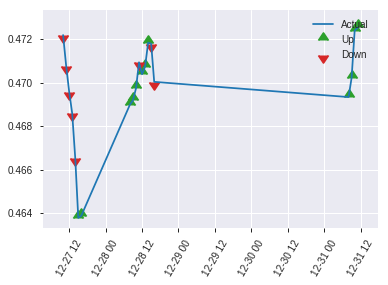


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19530373099114684
RMSE: 0.44193181712923413
LogLoss: 0.574576077084202
Null degrees of freedom: 222
Residual degrees of freedom: 58
Null deviance: 309.23389543359224
Residual deviance: 256.2609303795541
AIC: 586.2609303795541
AUC: 0.7807822308063737
pr_auc: 0.7686472170178378
Gini: 0.5615644616127473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28619475659439886: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   60   0.5263   (60.0/114.0)
1      10   99   0.0917   (10.0/109.0)
Total  64   159  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286195     0.738806  158
max f2                       0.211525     0.845295  190
max f0point5                 0.531107     0.734266  79
max accuracy                 0.531107     0.717489  79
max precision                0.871267     1         0
max recall                   0.10273      1         217
max specificity              0.871267     1         0
max absolute_mcc             0.531107     0.446958  79
max min_per_class_accuracy   0.420331     0.715596  109
max mean_per_class_accuracy  0.40471      0.71785   113

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.830734           2.04587   2.04587            1                0.845135  1                           0.845135            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.825235           2.04587   2.04587            1                0.829994  1                           0.839079            0.0183486       0.0458716                  104.587   104.587
    3        0.0313901                   0.808508           1.02294   1.7536             0.5              0.81468   0.857143                    0.832108            0.00917431      0.0550459                  2.29358   75.3604
    4        0.0403587                   0.80219            2.04587   1.81855            1                0.806413  0.888889                    0.826398            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.795989           2.04587   1.87538            1                0.799822  0.916667                    0.819754            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.711566           2.04587   1.95692            1                0.753863  0.956522                    0.788241            0.100917        0.201835                   104.587   95.6921
    7        0.152466                    0.677385           1.48791   1.80518            0.727273         0.692774  0.882353                    0.757355            0.0733945       0.275229                   48.7907   80.5181
    8        0.201794                    0.630559           1.67389   1.77309            0.818182         0.657465  0.866667                    0.732937            0.0825688       0.357798                   67.3895   77.3089
    9        0.300448                    0.560175           1.39491   1.64891            0.681818         0.598255  0.80597                     0.688713            0.137615        0.495413                   39.4912   64.8911
    10       0.399103                    0.484831           0.929942  1.47119            0.454545         0.529504  0.719101                    0.649358            0.0917431       0.587156                   -7.00584  47.1189
    11       0.502242                    0.416031           1.33426   1.44307            0.652174         0.450868  0.705357                    0.608597            0.137615        0.724771                   33.4264   44.307
    12       0.600897                    0.349243           0.557965  1.29775            0.272727         0.380032  0.634328                    0.571071            0.0550459       0.779817                   -44.2035  29.7754
    13       0.699552                    0.301636           1.11593   1.27211            0.545455         0.318888  0.621795                    0.535507            0.110092        0.889908                   11.593    27.2112
    14       0.798206                    0.249839           0.557965  1.18385            0.272727         0.270897  0.578652                    0.502802            0.0550459       0.944954                   -44.2035  18.3847
    15       0.896861                    0.186535           0.278982  1.08431            0.136364         0.216659  0.53                        0.471327            0.0275229       0.972477                   -72.1018  8.43119
    16       1                           0.0657593          0.266853  1                  0.130435         0.135571  0.488789                    0.436697          

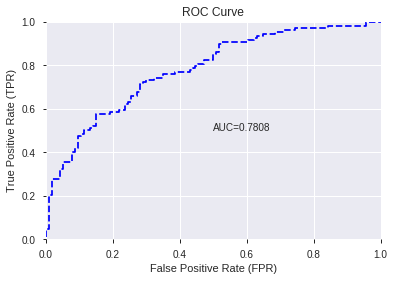

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


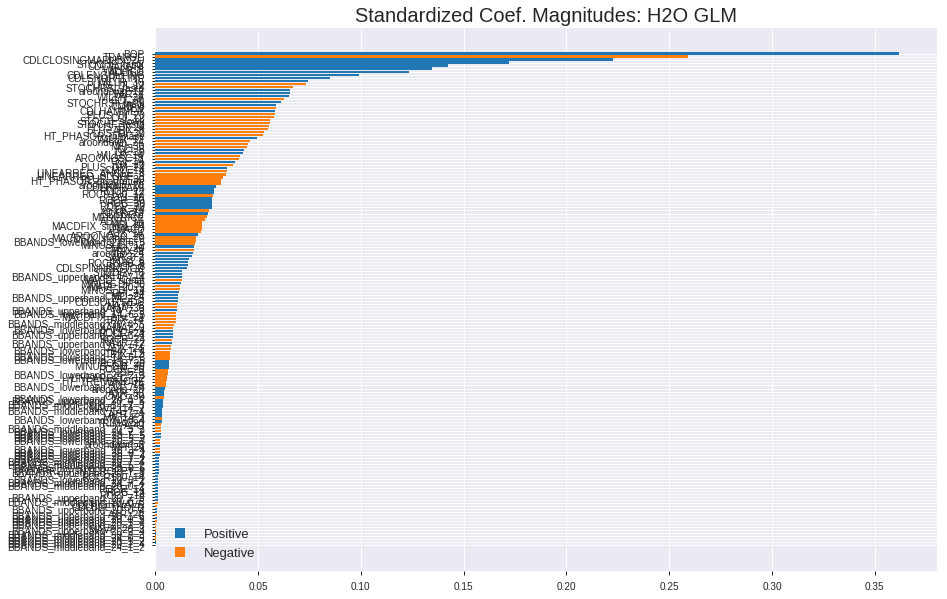

'log_likelihood'
--2019-09-03 04:59:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


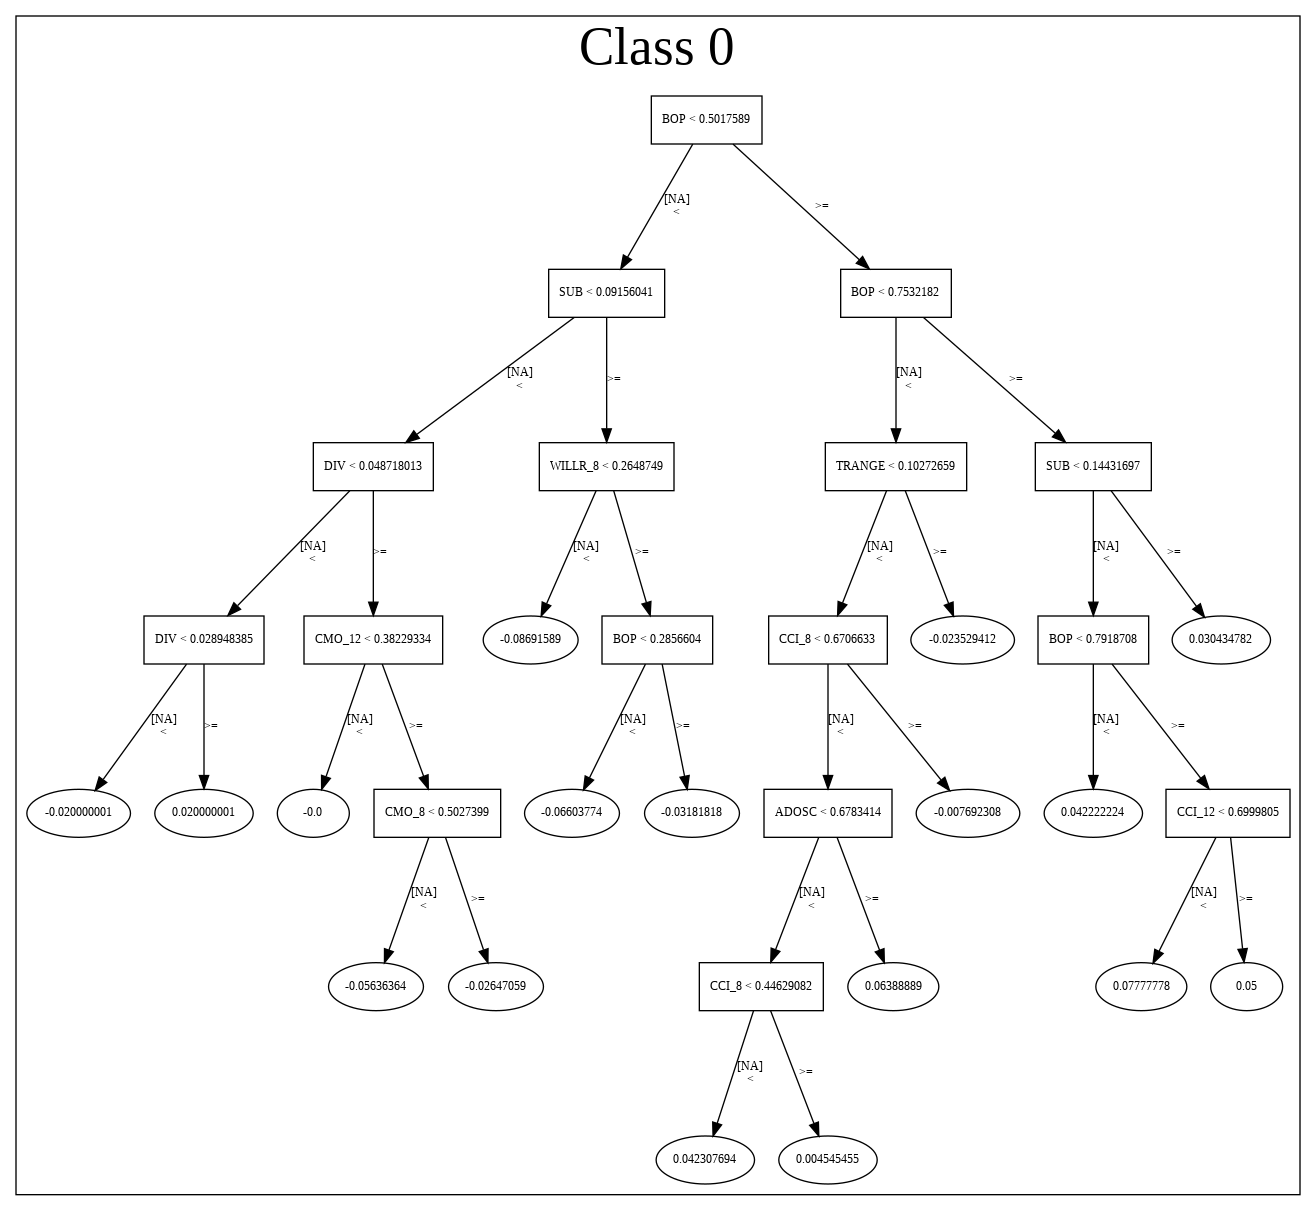

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_045903_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_045903_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLTAKURI',
 'WILLR_8',
 'ADOSC',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'WILLR_30',
 'PLUS_DI_12',
 'STOCHRSI_fastd',
 'aroondown_12',
 'VAR_8',
 'WILLR_24',
 'CCI_30',
 'STOCHRSI_fastk',
 'CMO_8',
 'OBV',
 'CDLHAMMER',
 'PLUS_DI_20',
 'CCI_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'PLUS_DI_24',
 'ADX_8',
 'PLUS_DI_30',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'aroondown_24',
 'MFI_30',
 'CCI_8',
 'DX_30',
 'WILLR_14',
 'AROONOSC_8',
 'CCI_14',
 'DX_20',
 'PLUS_DM_24',
 'CMO_14',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'PLUS_DM_30',
 'HT_PHASOR_quadrature',
 'aroondown_20',
 'CDLHARAMI',
 'ROCP_12',
 'ROCR100_12',
 'CCI_20',
 'ROCR_30',
 'ROC_30',
 'ROCP_30',
 'DX_14',
 'ADXR_12',
 'CDLDOJI',
 'MEDPRICE',
 'ADXR_14',
 'MFI_20',
 'MACDFIX_signal_24',
 'MACD',
 'ADX_14',
 'AROONOSC_20',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_24_6_5',
 'MINUS_DI_12',
 'CMO_20',
 'TRIX_8',
 'aroonup_24',
 'SAR_0.2',
 'ROC_8',
 'ROCR100_8',
 'ROCP_8',

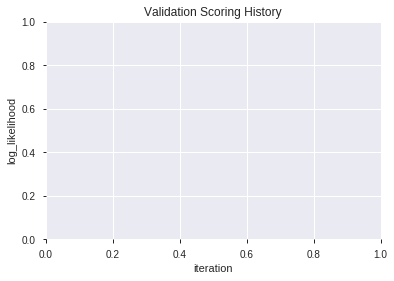

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190903_045918  0.770803  0.582335              0.279535  0.447166  0.199957
1  XGBoost_grid_1_AutoML_20190903_045918_model_6  0.767021  0.580816              0.285530  0.445111  0.198123
2  XGBoost_grid_1_AutoML_20190903_045918_model_3  0.766618  0.582763              0.310438  0.446953  0.199767
3  XGBoost_grid_1_AutoML_20190903_045918_model_7  0.766055  0.588408              0.330758  0.449021  0.201619
4  XGBoost_grid_1_AutoML_20190903_045918_model_4  0.759939  0.593455              0.283921  0.451656  0.203994
5               XGBoost_1_AutoML_20190903_045918  0.759697  0.596375              0.293095  0.454049  0.206160
6  XGBoost_grid_1_AutoML_20190903_045918_model_2  0.757846  0.600023              0.326573  0.453833  0.205965
7               XGBoost_3_AutoML_20190903_045918  0.755110  0.600696              0.347497  0.455062  0.207082
8  XGBoost_grid_1_AutoML_20190903_045918_model_1  0.754949  0.598802              0.276155  0.453587  0.205741
9  XGBoost_grid_1_AutoML_20190903_045918_model_5  0.733704  0.626968              0.332368  0.466308  0.217444

variable  relative_importance  scaled_importance  percentage
0                        BOP          1607.283813           1.000000    0.225293
1                     TRANGE           757.691345           0.471411    0.106206
2               STOCHF_fastk           352.256927           0.219163    0.049376
3             STOCHRSI_fastk           278.039581           0.172987    0.038973
4                      CCI_8           154.096451           0.095874    0.021600
..                       ...                  ...                ...         ...
130  BBANDS_upperband_20_2_5             3.520025           0.002190    0.000493
131  BBANDS_lowerband_20_0_5             3.408254           0.002121    0.000478
132              aroondown_8             3.274115           0.002037    0.000459
133                MAVP_20_3             3.156647           0.001964    0.000442
134                   CCI_20             2.736954           0.001703    0.000384

[135 rows x 4 columns]

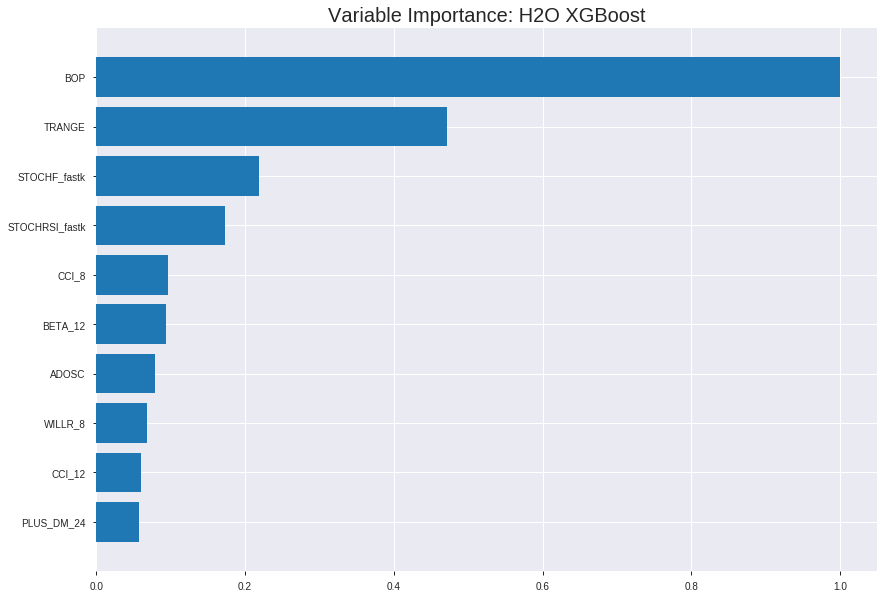

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190903_045918


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13515647000314512
RMSE: 0.3676363284594507
LogLoss: 0.4371467420748452
Mean Per-Class Error: 0.16251102083865487
AUC: 0.917558358945625
pr_auc: 0.9193506981802112
Gini: 0.83511671789125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4819074869155884: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  159  0.2057   (159.0/773.0)
1      96   689  0.1223   (96.0/785.0)
Total  710  848  0.1637   (255.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481907     0.843846  206
max f2                       0.356029     0.893749  265
max f0point5                 0.619089     0.866709  142
max accuracy                 0.507868     0.837612  194
max precision                0.918316     1         0
max recall                   0.168437     1         355
max specificity              0.918316     1         0
max absolute_mcc             0.498106     0.675928  198
max min_per_class_accuracy   0.518053     0.833118  189
max mean_per_class_accuracy  0.507868     0.837489  194

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.889402           1.98471    1.98471            1                0.898715  1                           0.898715            0.0203822       0.0203822                  98.4713   98.4713
    2        0.0205392                   0.871531           1.98471    1.98471            1                0.879622  1                           0.889168            0.0203822       0.0407643                  98.4713   98.4713
    3        0.0301669                   0.861224           1.98471    1.98471            1                0.866114  1                           0.881811            0.0191083       0.0598726                  98.4713   98.4713
    4        0.0404365                   0.854231           1.98471    1.98471            1                0.85775   1                           0.8757              0.0203822       0.0802548                  98.4713   98.4713
    5        0.0500642                   0.846317           1.98471    1.98471            1                0.850678  1                           0.870888            0.0191083       0.0993631                  98.4713   98.4713
    6        0.100128                    0.808031           1.93382    1.95927            0.974359         0.82629   0.987179                    0.848589            0.0968153       0.196178                   93.3823   95.9268
    7        0.150193                    0.779501           1.90838    1.9423             0.961538         0.793706  0.978632                    0.830295            0.0955414       0.29172                    90.8378   94.2305
    8        0.200257                    0.746436           1.88293    1.92746            0.948718         0.762471  0.971154                    0.813339            0.0942675       0.385987                   88.2933   92.7462
    9        0.300385                    0.67189            1.8066     1.88717            0.910256         0.709449  0.950855                    0.778709            0.180892        0.566879                   80.6598   88.7174
    10       0.399872                    0.599622           1.47253    1.78401            0.741935         0.634604  0.898876                    0.742856            0.146497        0.713376                   47.2529   78.4012
    11       0.5                         0.520183           1.15775    1.6586             0.583333         0.56191   0.835687                    0.70662             0.115924        0.829299                   15.7749   65.8599
    12       0.600128                    0.424939           0.814241   1.51772            0.410256         0.47414   0.764706                    0.667832            0.0815287       0.910828                   -18.5759  51.7722
    13       0.699615                    0.341183           0.499379   1.37291            0.251613         0.382629  0.691743                    0.627276            0.0496815       0.96051                    -50.0621  37.2912
    14       0.799743                    0.244086           0.25445    1.23288            0.128205         0.293776  0.621188                    0.585521            0.0254777       0.985987                   -74.555   23.288
    15       0.899872                    0.172992           0.127225   1.10985            0.0641026        0.210366  0.559201                    0.543778            0.0127389       0.998726                   -87.2775  10.9854
    16       1                           0.0619194          0.0127225  1                  0.00641026       0.12805   0.503851                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20121317917261933
RMSE: 0.44856792035612547
LogLoss: 0.5887188098043069
Mean Per-Class Error: 0.283999192897498
AUC: 0.7614608555286521
pr_auc: 0.7266265422618922
Gini: 0.5229217110573041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3559720814228058: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  94   0.4476   (94.0/210.0)
1      32   204  0.1356   (32.0/236.0)
Total  148  298  0.2825   (126.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355972     0.764045  266
max f2                       0.198516     0.862199  344
max f0point5                 0.443315     0.731605  215
max accuracy                 0.405712     0.719731  239
max precision                0.894716     1         0
max recall                   0.139066     1         382
max specificity              0.894716     1         0
max absolute_mcc             0.355972     0.441816  266
max min_per_class_accuracy   0.464584     0.695238  205
max mean_per_class_accuracy  0.443315     0.716001  215

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.858544           1.88983   1.88983            1                0.876542  1                           0.876542            0.0211864       0.0211864                  88.9831   88.9831
    2        0.0201794                   0.844832           0.944915  1.46987            0.5              0.851371  0.777778                    0.865355            0.00847458      0.029661                   -5.50847  46.9868
    3        0.0313901                   0.839113           0.755932  1.21489            0.4              0.841806  0.642857                    0.856945            0.00847458      0.0381356                  -24.4068  21.4891
    4        0.0403587                   0.818013           1.41737   1.25989            0.75             0.827382  0.666667                    0.850375            0.0127119       0.0508475                  41.7373   25.9887
    5        0.0515695                   0.798575           1.88983   1.39683            1                0.806386  0.73913                     0.840812            0.0211864       0.0720339                  88.9831   39.6831
    6        0.100897                    0.759997           1.37442   1.38588            0.727273         0.777471  0.733333                    0.809845            0.0677966       0.139831                   37.4422   38.5876
    7        0.150224                    0.723162           1.46032   1.41032            0.772727         0.740225  0.746269                    0.786985            0.0720339       0.211864                   46.0324   41.0321
    8        0.201794                    0.695855           1.56116   1.44887            0.826087         0.709548  0.766667                    0.767196            0.0805085       0.292373                   56.1164   44.887
    9        0.300448                    0.625228           1.46032   1.45263            0.772727         0.65164   0.768657                    0.729252            0.144068        0.436441                   46.0324   45.2631
    10       0.401345                    0.552889           1.38588   1.43585            0.733333         0.595182  0.759777                    0.695547            0.139831        0.576271                   38.5876   43.5849
    11       0.5                         0.47892            1.03082   1.35593            0.545455         0.512966  0.717489                    0.659522            0.101695        0.677966                   3.08166   35.5932
    12       0.600897                    0.404957           1.21789   1.33275            0.644444         0.438232  0.705224                    0.622365            0.122881        0.800847                   21.7891   33.2754
    13       0.699552                    0.337677           0.730162  1.24777            0.386364         0.371581  0.660256                    0.586998            0.0720339       0.872881                   -26.9838  24.7773
    14       0.800448                    0.223692           0.629944  1.1699             0.333333         0.281551  0.619048                    0.548496            0.0635593       0.936441                   -37.0056  16.9895
    15       0.899103                    0.170126           0.429507  1.08866            0.227273         0.200004  0.57606                     0.510258            0.0423729       0.978814                   -57.0493  8.86555
    16       1                           0.0883767          0.209981  1                  0.111111         0.13974   0.529148                    0.472874          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 04:59:20  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.496149                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 04:59:21  0.110 sec   5                  0.473227         0.640709            0.827718        0.829161           1.86797          0.264442                         0.479653           0.65304               0.766112          0.732238             1.51186            0.284753
    2019-09-03 04:59:21  0.191 sec   10                 0.454277         0.604272            0.840537        0.845015           1.98471          0.259307                         0.469545           0.633119              0.755297          0.711027             1.1339             0.293722
    2019-09-03 04:59:21  0.273 sec   15                 0.439049         0.574974            0.850682        0.85321            1.98471          0.244544                         0.462085           0.618132              0.757002          0.719547             1.51186            0.284753
    2019-09-03 04:59:21  0.366 sec   20                 0.426839         0.551246            0.857703        0.856896           1.98471          0.227214                         0.457623           0.608804              0.759171          0.724272             1.88983            0.273543
    2019-09-03 04:59:21  0.459 sec   25                 0.417355         0.532875            0.868789        0.870109           1.98471          0.225289                         0.454199           0.601502              0.761874          0.725128             1.51186            0.273543
    2019-09-03 04:59:21  0.544 sec   30                 0.409417         0.517231            0.874709        0.875287           1.98471          0.21887                          0.453577           0.599967              0.75793           0.718028             1.51186            0.29148
    2019-09-03 04:59:21  0.639 sec   35                 0.401472         0.501679            0.882088        0.883831           1.98471          0.198973                         0.450649           0.593807              0.763206          0.730375             1.51186            0.282511
    2019-09-03 04:59:21  0.742 sec   40                 0.394756         0.488509            0.88888         0.89167            1.98471          0.191913                         0.448992           0.590362              0.764619          0.729519             1.51186            0.280269
    2019-09-03 04:59:21  0.834 sec   45                 0.388661         0.476745            0.894603        0.896135           1.98471          0.188703                         0.447037           0.586202              0.767676          0.73369              1.51186            0.26009
    2019-09-03 04:59:21  0.928 sec   50                 0.382887         0.465799            0.901729        0.904312           1.98471          0.170732                         0.44785            0.587594              0.766092          0.730897             1.88983            0.304933
    2019-09-03 04:59:21  1.049 sec   55                 0.377943         0.455873            0.905377        0.907981           1.98471          0.171374                         0.447427           0.586375              0.764487          0.7

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1607.2838134765625     1.0                    0.2252931984485196
TRANGE                   757.6913452148438      0.47141104692391184    0.10620570254545325
STOCHF_fastk             352.2569274902344      0.21916286628202955    0.04937590312582365
STOCHRSI_fastk           278.0395812988281      0.17298723409490896    0.03897284726000484
CCI_8                    154.09645080566406     0.09587382733131164    0.021599721206972296
---                      ---                    ---                    ---
BBANDS_upperband_20_2_5  3.5200247764587402     0.002190045558192308   0.0004934023685531186
BBANDS_lowerband_20_0_5  3.408254384994507      0.002120505635916557   0.0004777354970437531
aroondown_8              3.2741146087646484     0.0020370482059933913  0.00045893310572206995
MAVP_20_3                3.156646728515625      0.0019639634904850957  0.00044246761640750587
CCI_20                   2.7369537353515625     0.0017028440854086116  0.0003836391904608502


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7469879518072289)

('auc', 0.77080315467568)

('logloss', 0.5823345430765748)

('mean_per_class_error', 0.279534846290037)

('rmse', 0.44716585334776315)

('mse', 0.1999573004002332)

xgboost prediction progress: |████████████████████████████████████████████| 100%


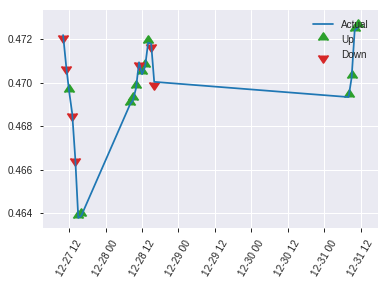


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1999573004002332
RMSE: 0.44716585334776315
LogLoss: 0.5823345430765748
Mean Per-Class Error: 0.279534846290037
AUC: 0.77080315467568
pr_auc: 0.7365942267887049
Gini: 0.5416063093513599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3099309802055359: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   47   0.4123   (47.0/114.0)
1      16   93   0.1468   (16.0/109.0)
Total  83   140  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309931     0.746988  139
max f2                       0.159349     0.849057  199
max f0point5                 0.361839     0.698835  122
max accuracy                 0.309931     0.717489  139
max precision                0.869737     1         0
max recall                   0.139835     1         209
max specificity              0.869737     1         0
max absolute_mcc             0.309931     0.455966  139
max min_per_class_accuracy   0.412729     0.684211  110
max mean_per_class_accuracy  0.309931     0.720465  139

Gains/Lift Table: Avg response rate: 48.88 %, avg score: 43.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.85603            2.04587    2.04587            1                0.862475  1                           0.862475            0.0275229       0.0275229                  104.587   104.587
    2        0.0224215                   0.83354            1.02294    1.6367             0.5              0.842861  0.8                         0.854629            0.00917431      0.0366972                  2.29358   63.6697
    3        0.0313901                   0.816608           2.04587    1.7536             1                0.824209  0.857143                    0.845938            0.0183486       0.0550459                  104.587   75.3604
    4        0.0403587                   0.813839           2.04587    1.81855            1                0.814736  0.888889                    0.839004            0.0183486       0.0733945                  104.587   81.8552
    5        0.0538117                   0.798371           2.04587    1.87538            1                0.808899  0.916667                    0.831478            0.0275229       0.100917                   104.587   87.5382
    6        0.103139                    0.754065           1.48791    1.69007            0.727273         0.770998  0.826087                    0.802553            0.0733945       0.174312                   48.7907   69.0068
    7        0.152466                    0.713832           1.67389    1.68484            0.818182         0.729707  0.823529                    0.778985            0.0825688       0.256881                   67.3895   68.4835
    8        0.201794                    0.687701           1.67389    1.68216            0.818182         0.69867   0.822222                    0.759353            0.0825688       0.33945                    67.3895   68.2161
    9        0.300448                    0.603579           1.20892    1.52677            0.590909         0.644405  0.746269                    0.721609            0.119266        0.458716                   20.8924   52.677
    10       0.399103                    0.518666           1.20892    1.4482             0.590909         0.560622  0.707865                    0.681814            0.119266        0.577982                   20.8924   44.8201
    11       0.502242                    0.409854           1.06741    1.37               0.521739         0.467788  0.669643                    0.637862            0.110092        0.688073                   6.74112   37.0003
    12       0.600897                    0.318236           1.30192    1.35883            0.636364         0.356672  0.664179                    0.591697            0.12844         0.816514                   30.1918   35.8825
    13       0.699552                    0.258048           0.557965   1.24588            0.272727         0.291986  0.608974                    0.54943             0.0550459       0.87156                    -44.2035  24.5883
    14       0.798206                    0.220051           0.743953   1.18385            0.363636         0.238538  0.578652                    0.511005            0.0733945       0.944954                   -25.6047  18.3847
    15       0.896861                    0.158841           0.464971   1.10477            0.227273         0.18717   0.54                        0.475383            0.0458716       0.990826                   -53.5029  10.4771
    16       1                           0.0851391          0.0889509  1                  0.0434783        0.129265  0.488789                    

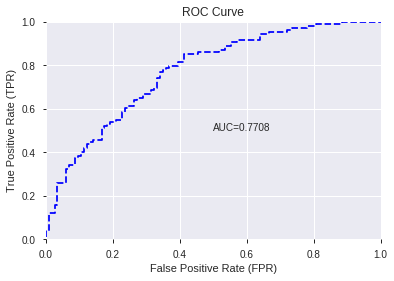

This function is available for GLM models only


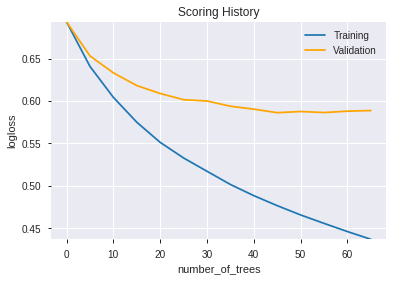

--2019-09-03 04:59:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


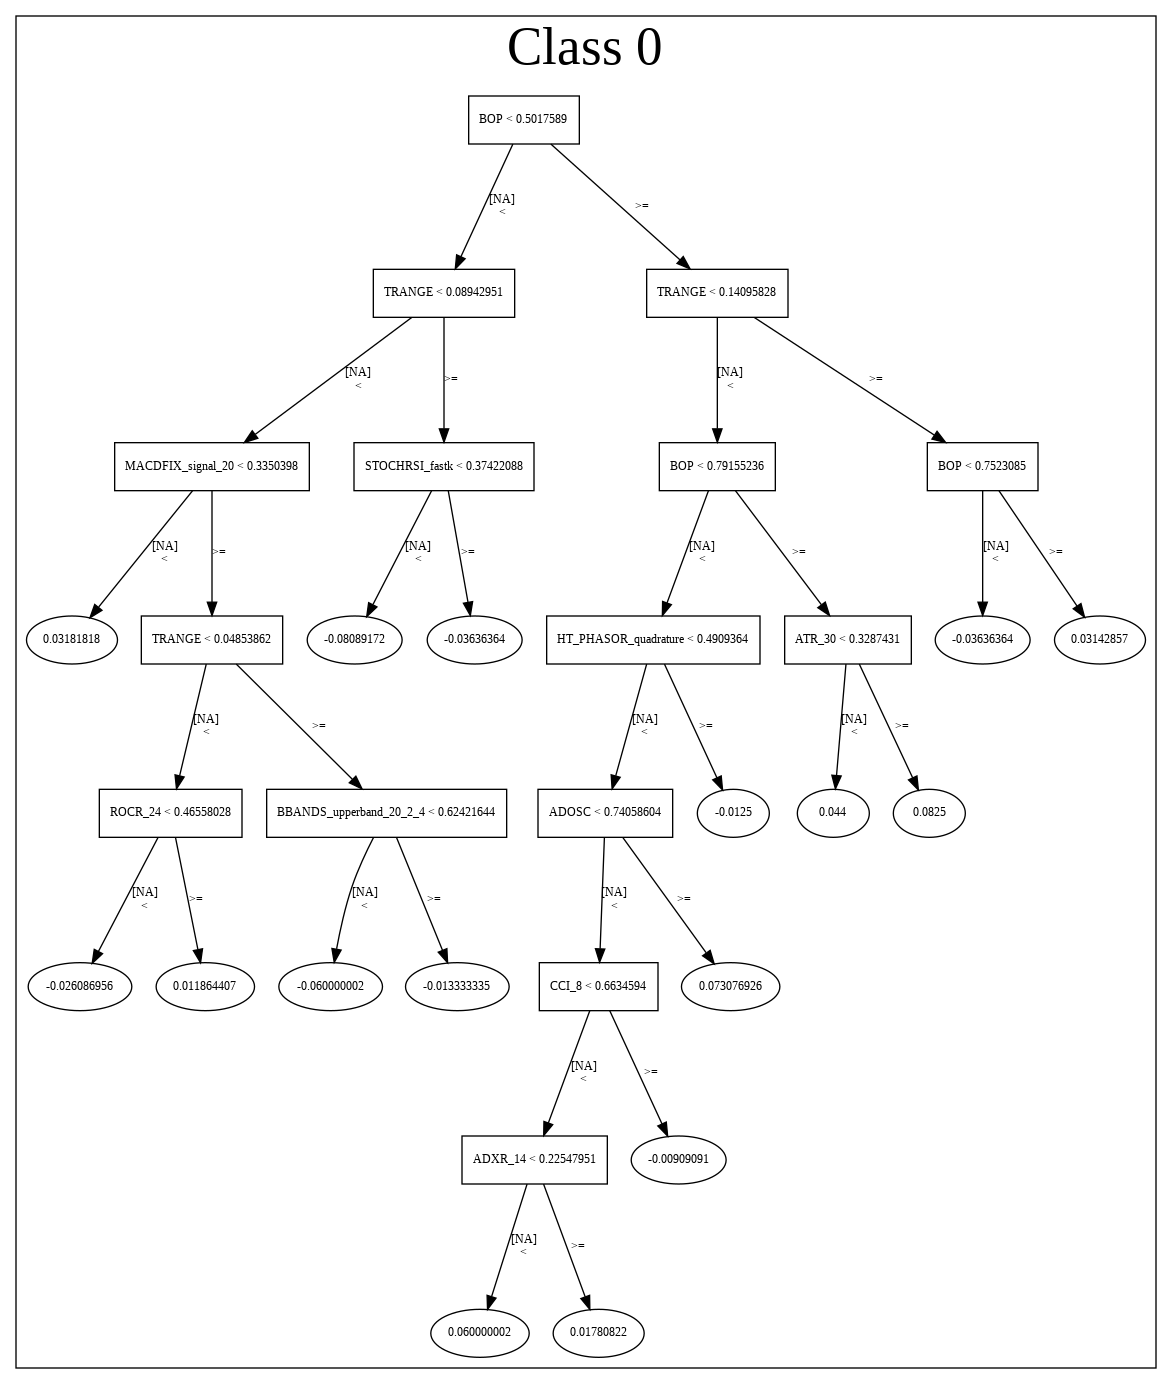

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190903_045918',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190903_045918',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b794',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b794',
   'ty

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CCI_8',
 'BETA_12',
 'ADOSC',
 'WILLR_8',
 'CCI_12',
 'PLUS_DM_24',
 'WILLR_24',
 'PLUS_DI_12',
 'PLUS_DI_30',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_8',
 'ROC_8',
 'STOCHRSI_fastd',
 'MFI_24',
 'MFI_20',
 'STOCH_slowk',
 'HT_PHASOR_inphase',
 'TRIX_14',
 'MFI_30',
 'HT_PHASOR_quadrature',
 'PLUS_DI_20',
 'ADX_8',
 'DX_20',
 'aroonup_20',
 'aroondown_12',
 'WILLR_12',
 'NATR_8',
 'DX_14',
 'CCI_14',
 'aroondown_20',
 'WILLR_14',
 'PLUS_DI_24',
 'ATR_24',
 'LINEARREG_ANGLE_8',
 'MACDFIX_signal_20',
 'ADXR_12',
 'MINUS_DI_30',
 'MINUS_DM_20',
 'NATR_12',
 'ATR_30',
 'ROCP_20',
 'aroondown_24',
 'ROCP_24',
 'PLUS_DM_30',
 'BBANDS_upperband_30_0_5',
 'DX_30',
 'ADX_24',
 'MACDFIX_signal_24',
 'CCI_30',
 'ROCP_12',
 'CMO_30',
 'aroonup_24',
 'BBANDS_upperband_24_2_5',
 'ROC_30',
 'MACDFIX_hist_24',
 'ADXR_14',
 'ATR_14',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_20_0_4',
 'CMO_8',
 'BBANDS_upperband_20_7_5',
 'BBANDS_upperband_20_0_5',


In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.735
GLM             0.731
XGBoost         0.731
dtype: float64

DeepLearning    GLM  XGBoost
All          0.735  0.731    0.722
DLF          0.717  0.709    0.731
Fwe          0.717  0.713    0.717
RFE          0.722  0.717    0.717
XGBF         0.704  0.709    0.731





F1


DeepLearning    0.746
GLM             0.761
XGBoost         0.760
dtype: float64

DeepLearning    GLM  XGBoost
All          0.725  0.729    0.744
DLF          0.735  0.745    0.760
Fwe          0.746  0.761    0.747
RFE          0.721  0.739    0.747
XGBF         0.727  0.745    0.760





auc


DeepLearning    0.783
GLM             0.784
XGBoost         0.790
dtype: float64

DeepLearning    GLM  XGBoost
All          0.779  0.780    0.781
DLF          0.773  0.778    0.790
Fwe          0.783  0.784    0.782
RFE          0.778  0.781    0.771
XGBF         0.775  0.778    0.790





logloss


DeepLearning    0.609
GLM             0.575
XGBoost         0.582
dtype: float64

DeepLearning    GLM  XGBoost
All          0.572  0.564    0.575
DLF          0.572  0.567    0.564
Fwe          0.609  0.564    0.570
RFE          0.582  0.575    0.582
XGBF         0.570  0.567    0.564





mean_per_class_error


DeepLearning    0.296
GLM             0.288
XGBoost         0.284
dtype: float64

DeepLearning    GLM  XGBoost
All          0.266  0.271    0.276
DLF          0.284  0.288    0.270
Fwe          0.281  0.282    0.284
RFE          0.281  0.282    0.280
XGBF         0.296  0.288    0.270





rmse


DeepLearning    0.459
GLM             0.442
XGBoost         0.447
dtype: float64

DeepLearning    GLM  XGBoost
All          0.441  0.436    0.443
DLF          0.442  0.440    0.438
Fwe          0.459  0.439    0.441
RFE          0.448  0.442    0.447
XGBF         0.441  0.440    0.438





mse


DeepLearning    0.211
GLM             0.195
XGBoost         0.200
dtype: float64

DeepLearning    GLM  XGBoost
All          0.194  0.190    0.196
DLF          0.195  0.194    0.192
Fwe          0.211  0.193    0.194
RFE          0.200  0.195    0.200
XGBF         0.195  0.194    0.192

{'F1':       DeepLearning    GLM  XGBoost
 All          0.725    NaN      NaN
 DLF          0.735    NaN      NaN
 DLF            NaN  0.745      NaN
 DLF            NaN    NaN    0.760
 All            NaN  0.729      NaN
 All            NaN    NaN    0.744
 XGBF         0.727    NaN      NaN
 XGBF           NaN  0.745      NaN
 XGBF           NaN    NaN    0.760
 Fwe          0.746    NaN      NaN
 Fwe            NaN  0.761      NaN
 Fwe            NaN    NaN    0.747
 RFE          0.721    NaN      NaN
 RFE            NaN  0.739      NaN
 RFE            NaN    NaN    0.747,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.735    NaN      NaN
 DLF          0.717    NaN      NaN
 DLF            NaN  0.709      NaN
 DLF            NaN    NaN    0.731
 All            NaN  0.731      NaN
 All            NaN    NaN    0.722
 XGBF         0.704    NaN      NaN
 XGBF           NaN  0.709      NaN
 XGBF           NaN    NaN    0.731
 Fwe          0.717    NaN      NaN
 Fwe     